
 # <center> Music-Learning</center>

<center>
Caliandro Pierciro (0299815)
    <br>
Falcone Gian Marco (0300251)
</center>

# Introduction and scope of the notebook
This notebook aims to show the application of Machine Learning models to solve the problem of music genre recognition.

This problem is well know and studied by the literature, since it has a wide set of applications.

For the data we used the [FMA dataset](https://github.com/mdeff/fma), which contains differents zips of .mp3 audio files.
Given the size of the zip, we decided to use the __medium__ version to extract the feature and the classification is performed on the top 16 root genres that are explained in more details in [__1__](https://arxiv.org/abs/1612.01840).

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Classifiers
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

import librosa
from IPython.display import Audio
import scipy
from tinytag import TinyTag
from dataset_generator import calculate_metrics, get_features, retrieve_header, post_processing
import pandas as pd

import ast
import os
import cmath
import csv
import math
import json

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# utility imports from .py files
from plot_utils import basic_plot, bar_plot, three_group_bar_plot, five_group_bar_plot, print_cm
from dataset_utils import drop_complex_cols, get_top_genres, load, write_metrics_header, write_metrics, write_tuning_header, write_on_tuning_file 
from utils import write_cm_on_file, compute_class_metrics, print_acc_table

C:\ProgramData\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


We present two versions of the notebook, associated with the two binary value of  __VERSION__:
- 0: use the dataset from FMA repository;
- 1: use our dataset, extracted by the mp3 archive of the FMA repository.
<br><br>

There is also an __EXEC_PROFILE__ variable that is a dictonary which value will be used as an "operational profile": the keys refers to the fact that during the rur there will be the application of some feature selection/extraction or dataset resampling.
<br> 
This happens by chaning the default value (False) to 'True' for the desired key, keeping in mind that some keys are mutually exclusive (eg: Smote and oversampling, or PCA and feature selection).
<br>


In [2]:
VERSION = 1
EXEC_PROFILE = {"FS": False, "SMOTE": True, "OVERS": True}

legend_validation = ["Plain", "Oversampling", "Smote"]
legend_test = ["PCA", "Feature Selection"]

# Dataset generation

The aim of this section is to generate a .csv file containing all useful informations about the audio files available in the FMA repository.
<br>
A version of the file 'raw_csv_file.csv' is already available in the home directory of the project, so it is not necessary to execute this block of code.<br>
Note: dataset generation may require approximately 24 hours to be ready on AMD Ryzen 7.

In [ ]:
file_name = 'raw_csv_file.csv'

# open the file in the write mode
f = open(file_name, 'w', newline='')

# create the csv writer
writer = csv.writer(f)

# write header to the csv file
header = retrieve_header()
writer.writerow(header)

# write data to the csv file
get_features(writer)

# close the file
f.close()

post_processing(file_name)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


## Data preprocessing
There is the need to do some preliminar operations on the data extracted by the .mp3 files:

1. First, there are some columns (the 'Fourier' related) that have complex numbers as values.
These values can't be treated by the ML models so they are discared.

2. The labels have to be encoded to be processed in the right way.

In [3]:
# Open file, extract feature set and label set
if VERSION:
    path = "out.csv"
    dataframe = pd.read_csv(path)
    y = dataframe["genre"]
    dataframe = dataframe.drop(columns=["title", "artist", "filename", "album", "genre"])
    dataframe = dataframe.drop(columns=drop_complex_cols(dataframe))
    X = dataframe.drop(columns=["fourier_tempogram_std"])

    # Label encoding and extraction of uniques for later purposes
    le = LabelEncoder()
    y = le.fit_transform(y)
    labels = pd.Series(y).unique()
    
else:
    path = "dataset/fma_metadata/"
    tracks_file = "tracks.csv"
    features_file = "features.csv"
    ds_features = load(path+features_file)
    ds_tracks = load(path+tracks_file)
    medium = ds_tracks['set', 'subset'] <= 'medium'
    X = ds_features.loc[medium, 'mfcc'] # mel-frequency cepstral coeffcients: TODO add details 
    y = ds_tracks.loc[medium, ('track', 'genre_top')]
    labels = y.unique()

Each profile contains the value of the parameters to use in the different classificators based on parameter tuning.

In [4]:
# load profiles from json file and store them as dicts
json_profiles = open("execution_profiles.json")
profiles = json.load(json_profiles)

plain = profiles["plain"]
smote = profiles["smote"]
overs = profiles["overs"]
plain_pca = profiles["pca_plain"]
overs_pca = profiles["pca_overs"]
smote_pca = profiles["pca_smote"]

## Feature manipulation
Feature manipulation is considered due to the fact that dataset is made of 105 feature.
<br>
The scope of this phase is to determine if it is possibile to reduce the dimensionality of the problem without losing any information.
<br>
Weather if feature manipulation is applyed or not (depending on the values of the `EXEC_PROFILE` dict), in the end dataset is split into train/validation/test sets.
<br>
The split proposed is, respectively, 80/10/10 as indicated in paper [__1__](https://arxiv.org/abs/1612.01840).
<br><br>
### Feature selection
Feature selection is applyed using Recursive feature elimination with cross-validation (`RFECV`) method.
<br>
The linear model used to determine the suited number of feature is `LassoCV`, with 5-fold cross validation.
<br><br>
### Principal Component Analysis
PCA is a technique of feature extraction: feature extraction is usefull to reduce the dimensionality of the dataset.
<br>

Suppose that dataset $\textbf{X}$ has $D$ features (so, dimensionality is $= D$), with PCA each item is projected on an hyperplane with dimensionality $d' < D$.
<br>

PCA looks for this subspace that must be a "faithfull" representation of the original dataset, that is the distance between a point and its projection is small or the minimum.
<br>

For example, consider $d' = 1$: here, the task is to project each point $x_i$ onto a line which equation can be written as:
<br>
<div style="text-align: center;">
    $
        \begin{equation}
            \textbf{x} = \alpha \cdot \textbf{u}_1 + m
        \end{equation}
    $
</div>
where m is given by:
<div style="text-align: center;">
    $
        \begin{equation}
            \textbf{m} = \frac{1}{n} \cdot \sum\limits_{i=1}^{n} \textbf{x}_i
        \end{equation}
    $
</div>
$\alpha$ is the distance between $\textbf{x}$ and $\textbf{m}$ on the line and $\textbf{u}_1$ is a unity vector that indicates the line direction, as shown in the figure below:
<br>
<img src="images/pca_line.png" alt="MLP first layer" style="height: 300px; width:300px;"/>
<br>

Let $\tilde{\textbf{x}}_i = \alpha \textbf{u}_1 + m$ be the projection of each point onto the line, the task is to find the set of projections that minimize the following cost:
<div style="text-align: center;">
    $
        \begin{equation}
            J(\alpha_1, ...m \alpha_n, \textbf{u}_1) = \sum\limits_{i=1}^{n} ||\tilde{\textbf{x}}_i - \textbf{x}_i ||^2
        \end{equation}
    $
</div>
<br><br>

By deriving $J$ with respect to $\alpha_i$ and $\textbf{u}_1$ and considering the __covariance matrix__ of the dataset, $S$:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            \textbf{S} = \frac{1}{n} \sum\limits_{i=1}^{n} (\textbf{x}_i - \textbf{m}) \cdot (\textbf{x}_i - \textbf{m})^T
        \end{equation}
    $
</div>
<br>

applying __Lagrange multipliers__, it comes out that error function is minimized when $\textbf{u}_1$ is an eigenvector of $\textbf{S}$, corresponding to the eigenvalue $\lambda_1$:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            \textbf{S} \cdot \textbf{u}_1 = \lambda_1 \cdot \textbf{u}_1
        \end{equation}
    $
</div>
<br>

So in general the quadratic error is minimized when vectors are projected onto a hyperplan defined by the directions associated with the $d'$ eigenvectors corresponding to the $d'$ largest eigenvalues of $\textbf{S}$.


Feature extraction can be usefull, for example, to reduce computational time, without losing any information on the original set.

In [5]:
# check if feature selection is enabled for the current run
if EXEC_PROFILE["FS"]:
    print(X.shape)
    X_new = RFECV(LassoCV(tol=1e-1), step=1, cv=5).fit(X, y).transform(X)
    print(X_new.shape)
    
    # Split into train, validate, test
    X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_new, y, random_state=42, 
                                                                    test_size=0.10)
    X_train_fs, X_validate_fs, y_train_fs, y_validate_fs = train_test_split(X_train_fs, 
                                                                            y_train_fs, 
                                                                            random_state=42, 
                                                                            test_size=0.10)

# Split into train/validate/test sets for "plain" case
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.10)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, 
                                                            random_state=42, test_size=0.10)

as shown by the data, the first value for PCA that ensures variance = 1 is 40 components, so that value has been chosen.

### Dataset resampling
Since the dataset, obtained by the medium size mp3 folder, is composed of ~ 16000 tracks and it's very unbalanced, it could be usefull to increase the number of instances in training set for the minority classes. The hope is that, balancing the dataset, classifiers' performances are boosted in the recognition of some classes.
<br>
To do so, both SMOTE and RandomOversampler methods can be applyed:
- SMOTE is a method that creates "synthetic" new instances starting from available data;
- Oversampling is applyed on the least populated classes, adding instances to make these classes "easier" to predict.

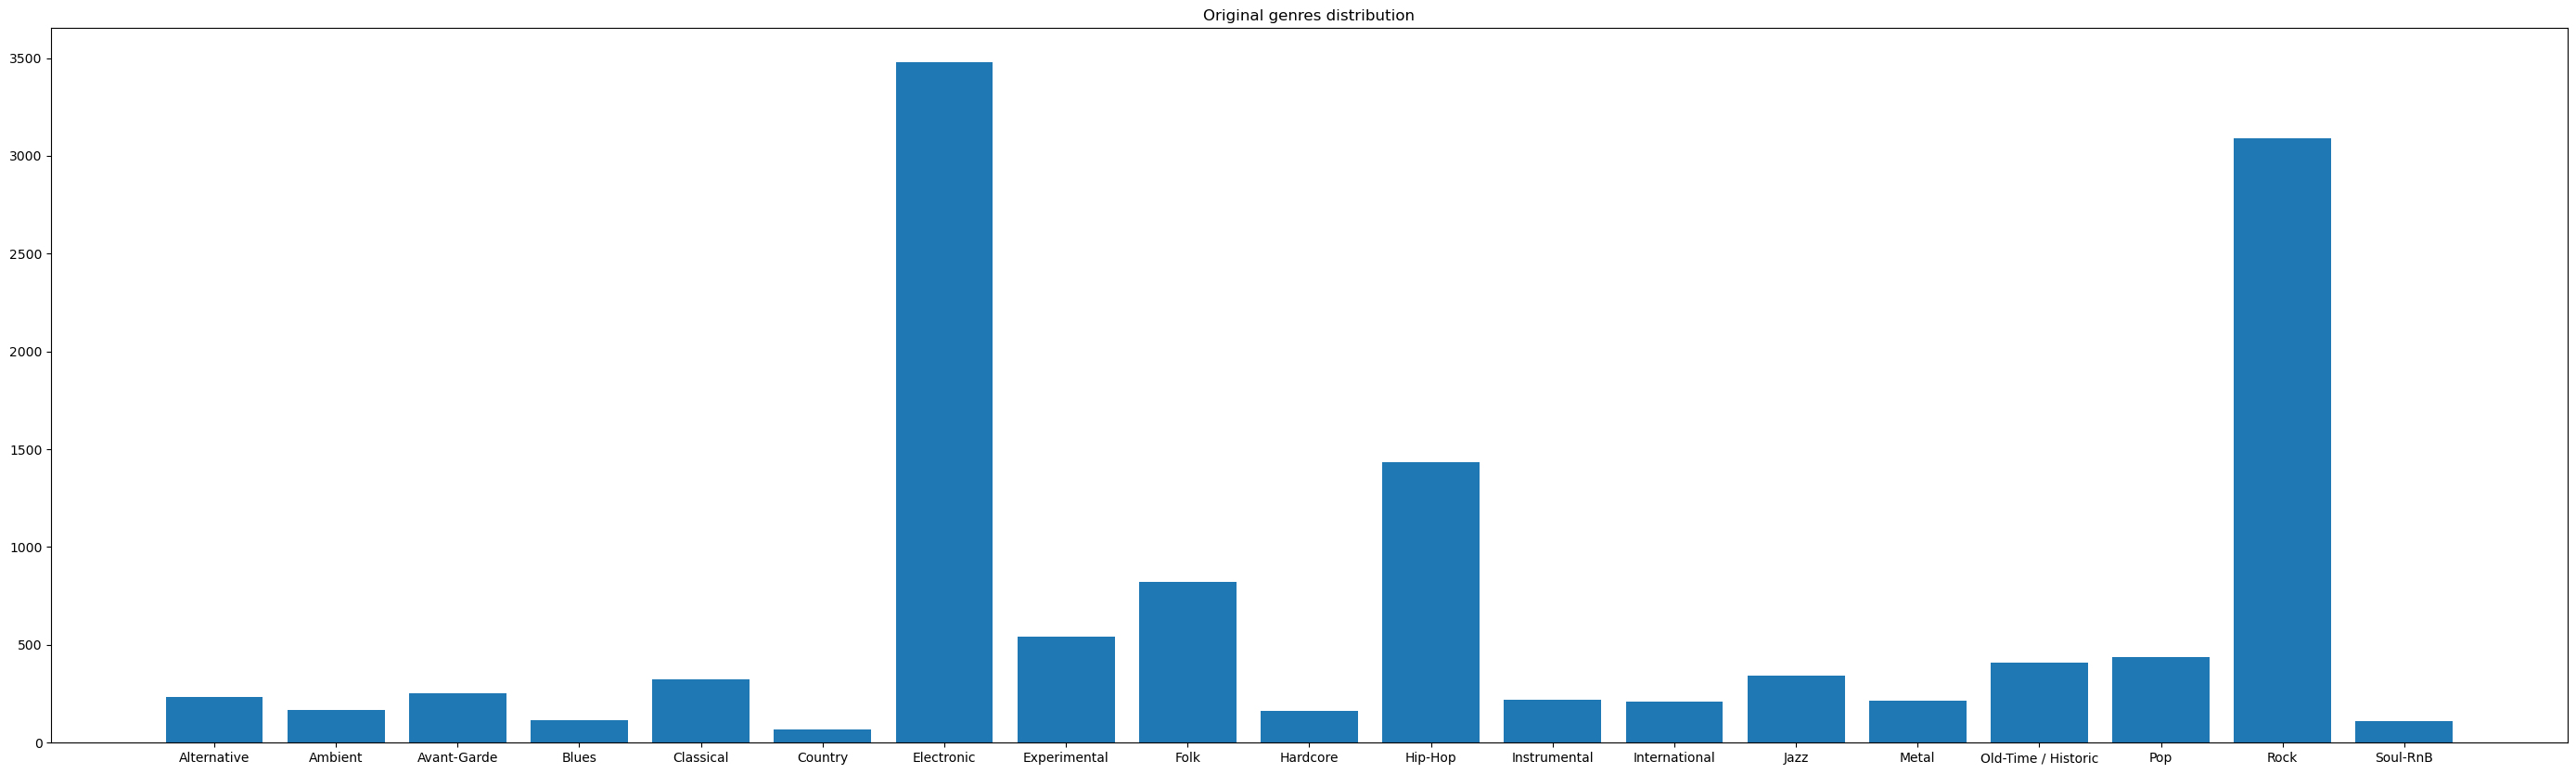

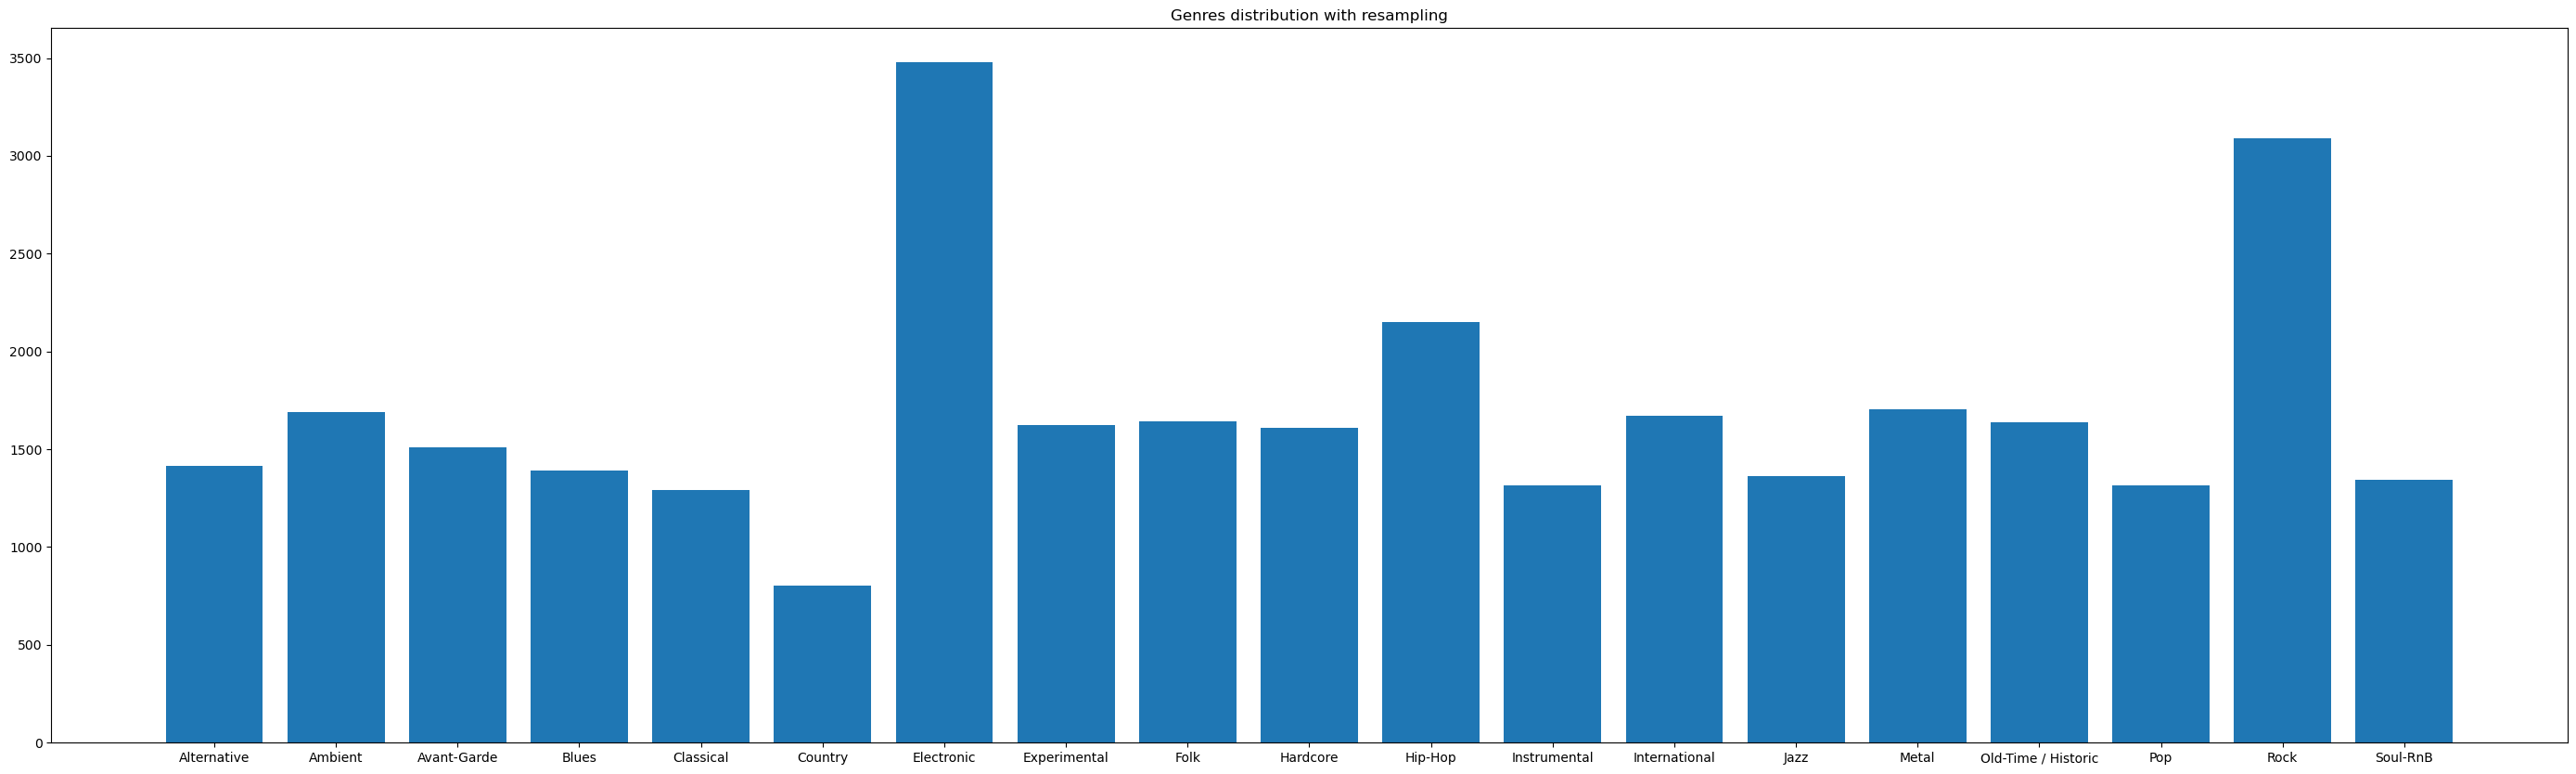

In [6]:
orig_labels = le.inverse_transform(labels)
orig_labels.sort()

# summarize distribution 
counter = Counter(y_train) 
strategy = {} 
for k,v in counter.items(): 
    strategy[k] = v
    
sorted_dict = dict(sorted(strategy.items()))
bar_plot((35,10), sorted_dict.values(), orig_labels, 'Original genres distribution')
     
if EXEC_PROFILE["OVERS"] or EXEC_PROFILE["SMOTE"]:
    # define oversampling strategy 
    max_class = max(strategy, key=strategy.get) 

    for k,v in strategy.items(): 
        if v < strategy[max_class]/24: 
            strategy[k] = v * 12 
        elif v < strategy[max_class]/20: 
            strategy[k] = v * 10
        elif v < strategy[max_class]/16: 
            strategy[k] = v * 8
        elif v < strategy[max_class]/12: 
            strategy[k] = v * 6
        elif v < strategy[max_class]/8: 
            strategy[k] = v * 4
        elif v < strategy[max_class]/6: 
            strategy[k] = math.ceil(v * 3) 
        elif v < strategy[max_class]/4: 
            strategy[k] = math.ceil(v * 2) 
        elif v < strategy[max_class]/2: 
            strategy[k] = math.ceil(v * 1.5) 
        
    # transform the dataset 
    if EXEC_PROFILE["SMOTE"]:
        oversample = SMOTE(sampling_strategy=strategy) 
        # fit and apply the transform
        if EXEC_PROFILE["FS"]:
            X_train_smote_fs, y_train_smote_fs = oversample.fit_resample(X_train_fs, y_train_fs)
        X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)
        
    if EXEC_PROFILE["OVERS"]:
        oversample = RandomOverSampler(sampling_strategy=strategy) 
        # fit and apply the transform
        if EXEC_PROFILE["FS"]:
            X_train_os_fs, y_train_os_fs = oversample.fit_resample(X_train_fs, y_train_fs)
        X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
            
    
    sorted_dict = dict(sorted(strategy.items()))
    bar_plot((35,10), sorted_dict.values(), orig_labels, 'Genres distribution with resampling')

# Model used
For this study, we used 5 different classifiers:

1. Support Vector Machines (SVM)
1. Logistic Regression     (LR)
1. k-Nearest Neighbours    (kNN)
1. Multi Layer Perceptron  (MLP)
1. Decision Tree           (DT)
<br>

For each of them, the first phase was the model selection, that was performed using
<br>
GridSearchCV to determine the best value for the classifier parameters, and even the number of components for PCA to use with that classifier.
<br>
After that, there is a phase of model validation: given the best parameters obtained by GridSearchCV, each classifier is run against a validation set, and some performance metrics are evaluated to define the suited one for this classification problem.
<br> In particular, the comparison on validation set is done considering 3 cases:
- the model without any manipulation of the feature set
- oversampling on train set
- SMOTE on train set
<br>

Last, the 'best' model is applyed on a test set, in this case the comparison is based also on the same model + PCA or feature selection.

## Model tuning

In [7]:
n_components_pca = [15, 30, 40, 60, 90] # number of components for PCA tuning

## SVM tuning
The first classifier evaluated was SVM.
<br>
Based on the online literature, the suited kernel function seems to be 'rfb', so it was our choice to use it too.
We recall that the radial basis function (rbf) $K(\textbf{x}, \textbf{x'})$ has the following form:<br>
<center>$K(\textbf{x}, \textbf{x'}) = e^{-\frac{||\textbf{x} - \textbf{x'}||^2}{2\sigma^2}}$</center>
<br>

Support Vector Machine (SVM) is model in which a first strong assumption is that classes are linearly separable: the __geometric margin__ is considered, that is (for each couple ($\textbf{x}_i$, $t_i$)

<br>

<div style="text-align: center;">
    $
        \begin{equation}
            \gamma_i = t_i \cdot (\frac{\textbf{w}}{||\textbf{w}||} \phi(x_i) + \frac{w_0}{||\textbf{w}||})
        \end{equation}
    $
</div>
<br><br>

Then, for a test set T = (($\textbf{x}_1$, $t_1$), ..., ($\textbf{x}_n$, $t_n$))
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            \gamma = \underset{i}{min} \gamma_i
        \end{equation}
    $
</div>
<br><br>

It is usefull to consider $\gamma$ as half of the width of the larger strip centered on the hyperplane $\textbf{w}^T \cdot \textbf{x} + w_0$, then all the hyperplanes on the boundary of this strip that are at distance $\gamma$ and pass from at least one point $x_i$ are said __maximum margin hyperplanes__, while such points $x_i$ are __support vectors__.
<br>

Figure below shows a representation of this concept:
<br>

<img src="images/SVM_hyperplane.png" alt="MLP first layer" style="height: 500px; width:800px;"/>
<br><br>

Given that, classification can be made as:

<br>

<div style="text-align: center;">
    $
        \begin{equation}
            y(\textbf{x}) = \sum\limits_{i = 1}^{m} w_i^* \phi_i(\textbf{x}) + w_0^*  = \sum\limits_{j \in S} \lambda_j^* t_j k(\textbf{x_j}, \textbf{x}) + w_0^*
        \end{equation}
    $
</div>
<br>

where $S$ is the set of support vectors.
<br>

This derives from the solution of the problem with constraints (or it's dual problem):

<br>

<div style="text-align: center;">
    $
        \begin{equation}
            \underset{\textbf{w}, w_0}{min} \frac{1}{2} \cdot ||\textbf{w}||^2
        \end{equation}
    $
</div>
where
<div style="text-align: center;">
    $
        \begin{equation}
            t_i \cdot (\textbf{w}^T \cdot \phi(\textbf{x_i}) + w_0) \geq 1
        \end{equation}
    $
</div>



In the case that there is not linear separation between classes, a smoothness of the separation is applyed considering a $\xi$ factor.
<br>

So, classification can be made by:
<div style="text-align: center;">
    $
        \begin{equation}
            y(\textbf{x}) = \sum\limits_{i = 1}^{m} w_i^* \phi_i(\textbf{x}) + b^*  = \sum\limits_{j \in S} \lambda_j^* t_j k(\textbf{x_j}, \textbf{x}) + b^*
        \end{equation}
    $
</div>


<div style="text-align: center;">
    $
        \begin{equation}
            \underset{\textbf{w}, w_0}{min} \frac{1}{2} \cdot \textbf{w}^T \cdot \textbf{w} + C \sum\limits_{i = 1}^{n} \xi_i
        \end{equation}
    $
</div>
where
<div style="text-align: center;">
    $
        \begin{equation}
            t_i \cdot (\textbf{w}^T \cdot \phi(\textbf{x_i}) + w_0) \geq 1 - \xi_i
        \end{equation}
    $
</div>
and
<div style="text-align: center;">
    $
        \begin{equation}
            \xi_i \geq 0
        \end{equation}
    $
</div>
<br><br>

The SVC implementation offered by scikit uses, among the parameters, a $C$ that is used for regularization, with a squared l2 penality function.
<br><br>
So, for tuning, different values of C have been considered

In [7]:
# Construct a pipeline
scaler = StandardScaler()
pca = PCA()

if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)
svc = SVC()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("svc", svc)])

kernels = ['rbf']
C_values = [1, 10, 25, 50, 100]
param_grid = { "pca__n_components": n_components_pca, 
              "svc__C": C_values,
              "svc__kernel": kernels
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Best parameter (CV score=0.623):
{'pca__n_components': 90, 'svc__C': 10, 'svc__kernel': 'rbf'}


## LR tuning
The second classifier used is Logistic Regression.
<br>

Logistic Regression is a Generalized Linear Model: for the case of binary classification, where $y \in \{0, 1\}$ and $p(y|x)$ ~ $Ber(\pi(\textbf{x}))$ then the natural parameter $\theta(\textbf{x})$ of the GLM is:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            \theta(\textbf{x}) = log \frac{\pi(\textbf{x})}{1 - \pi(\textbf{x})}
        \end{equation}
    $
</div>
<br>
and so, assuming that there exists a $\textbf{w}$ such that $\theta(\textbf{x})= \textbf{w}^T \cdot \textbf{w}$ then a logistic regression derives:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            y(\textbf{x}) = \frac{1}{1 + e^{- \textbf{w}^T \cdot \textbf{w}}}
        \end{equation}
    $
</div>
<br><br>

LogisticRegression class used in the case of a multiclass problem automatically sets the `multi_class` parameter to `multinomial`.
<br>

This implies that the loss function used is the cross-entropy loss:

<div style="text-align: center;">
    $
        \begin{equation}
            L(t, y) = \frac{1}{log2} log(1+e^{-yt})
        \end{equation}
    $
</div>
<br><br>

This class implements different solvers with different penalty terms added, on which the tuning has been made.

In [8]:
scaler = StandardScaler()
pca = PCA()
if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)
logistic = LogisticRegression()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

model_solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
penalties = ['l1', 'l2', 'none']
param_grid = { "pca__n_components": n_components_pca, 
              "logistic__solver": model_solvers,
              "logistic__penalty": penalties
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.

/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  w

/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimiz

Best parameter (CV score=0.596):
{'logistic__penalty': 'l2', 'logistic__solver': 'newton-cg', 'pca__n_components': 90}


## kNN tuning
As third classifier we have k-Nearest-Neighbours.
<br>

k-Nearest-Neighbors is a non-parametrics classification method.
<br>

In non-parametrics classification, the number of the parameters considered is unbounded (given by the number of features), all the considerations starts by considering the probability density $p(\textbf{x}$), derived by:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            P_{\textbf{x}} = \int_{R(\textbf{x})} p(\textbf{z}) d\textbf{z}
        \end{equation}
    $
</div>
<br><br>

From here, $P_{\textbf{x}} \approx p(\textbf{x}) \cdot V$ where $V$ is the volume of the region $R(\textbf{x})$.
<br>

Since $P_{\textbf{x}} \approx \frac{k}{n}$, that is the number $k$ over $n$ elements taht lays in the region $R(\textbf{x})$, it derives that $p(\textbf{x}) \approx \frac{k}{n \cdot V}$.
<br><br>

kNN fixes k and derives V as the smallest hypersphere of volume V containing k items from the train set.<br>

Then, to assign the class to an element $\textbf{x}$, the posterior distribution is evaluated:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            p(C_i | \textbf{x}) = \frac{k_i}{k}
        \end{equation}
    $
</div>
<br>

so the class that will have the biggest $k_i$, so the most number of elements near to point $\textbf{x}$, will be the one to which item $\textbf{x}$ will be assigned.

In [9]:
scaler = StandardScaler()
pca = PCA()
if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("knn", knn)])

n_neighbors = [1, 2, 3, 5, 10, 15, 20, 25, 50, 100]
param_grid = { "pca__n_components": n_components_pca,
              "knn__n_neighbors": n_neighbors
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)
    
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Best parameter (CV score=0.558):
{'knn__n_neighbors': 10, 'pca__n_components': 90}


## MLP tuning
The fourth considered was Multi Layer Perceptron.
<br>

Perceptron was introduced as one of the basis of neural networks approaches, it can be seen as a simple model for a single neuron.
<br>

In the case of a binary classification, each item $\textbf{x}$ is classified based on the sign of the function:

<div style="text-align: center;">
$
    \begin{equation}
        y(\textbf{x}) = f(\textbf{w}^T \textbf{x})
    \end{equation}
$
</div>
where $f(i)$ is defined as:
<div style="text-align: center;">
$
    \begin{equation}
    y(i) =
        \begin{cases}
        -1 & \text{if } i < 0\\
        1 & \text{if } i \geq 0
        \end{cases}
    \end{equation}
$
</div>
<br><br>

Multi-layer perceptron: multi-layer neural network, with a certain number of hidden layers.
<br>

The first layer of the network takes as input vector $\textbf{x} = (x_1, ..., x_d)$ and derives $m_1 > 0$ __activations__ $a_1^{(1)}, ..., a_{m_1}^{(1)}$ as a linear combination of the input feature:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            a_j^{(1)} = \sum\limits_{i = 1}^{d} w_{ji}^{(1)} \cdot x_i + w_{j0}^{(1)} = \textbf{x}^T \textbf{w}_j^{(1)}
        \end{equation}
    $
</div>
<br>

then, each of the $a_j^{(1)}$ is transformed using a non-linear activation function $h_1$, resulting in the vector $\textbf{z^{(1)}} = (z_1^{(1)}, ..., z_{m_1}^{(1)})$ that will be the input of the next layer (if any):
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            z_j^{(1)} = h_1(a_j^{(1)}) = h_1(\textbf{x}^T \textbf{w}_j^{(1)})
        \end{equation}
    $
</div>
<br>

Figure below show a representation of the first layer:
<br>
<img src="images/ML_MLP_first_layer.png" alt="MLP first layer" style="height: 500px; width:500px;"/>

<br><br>

Then, for each __hidden layer__, where layer $r$ as $m_r$ units for each input vector $\textbf{z}^{(r-1)}$, the vector $\textbf{z}^{r}$ is derived:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            a_k^{(r)} = (z^{r-1})^T \cdot \textbf{w}_k^{(r)}
        \end{equation}
    $
</div>
<br>

and non-linear transformation
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            z_k^{(r)} = h_r((\textbf{z}^{(r-1)})^T \cdot \textbf{w}_k^{(r)})
        \end{equation}
    $
</div>
<br><br>

below, a representation of an inner layer:
<br>
<img src="images/ML_MLP_inner_layer.png" alt="MLP first layer" style="height: 500px; width:500px;"/>
<br><br><br>

In this implementation, the loss function to minimize is the __log-loss function__ that is:
<div style="text-align: center;">
$
    \begin{equation}
    L(t, y) = \frac{1}{log2} log(1+e^{-yt} )
    \end{equation}
$
</div>
<br>

using the __'adam'__ solver, a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba.
<br><br>

This class has different parameters that can be tuned:
1. hidden_layer_sizes, where the The ith element represents the number of neurons in the ith hidden layer
1. alpha: Strength of the L2 regularization term
<br>

In [8]:
scaler = StandardScaler()
pca = PCA()
if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)
    
mlp = MLPClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("mlp", mlp)])


hlayers = [10, 20, 50, 75, 100, 150]
alphas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
param_grid = { "pca__n_components": n_components_pca,
              "mlp__alpha": alphas,
              "mlp__hidden_layer_sizes": hlayers
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: 

Best parameter (CV score=0.609):
{'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 20, 'pca__n_components': 90}


/usr/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## DT tuning
As fifth and last classifier, we used decision three. 
<br>

Decision Tree is a classifier that makes a recursive partition of the input space: it is a rooted tree where:
- each internal node splits the instance space into two or more subspaces
- each leaf is associated to a partition where the output value is:
    - a class, representing the most appropriate prediciton for points in that subspace
    - a probability vector
<br>

Starting with a vector $\textbf{z}$ = $(z_1, ..., z_n)$, at each step when a node is traversed a value $x_i$ associated with a feature and $f(z_i)$ are compared to decide where to go next.
Also, a threshold $\theta_i$ can be defined and $z_i$ can be compared to $\theta_i$ to decide which childern node to choose.
<br>

The procedure termines when a leaf is reached, giving back either the class or the probability vector.
<br><br>

To determine how to split the input space:
- a function or threshold is maximized within the intersection of the train set and each subregion
- a measure of impurity of the class in the set is minimized.
<br>

Consider a set S of elements, and for each subset of S the probability vector $p = (\frac{|S_1|}{|S|}, ..., \frac{|S_k|}{|S|})$ where |S_k| is the number of element beloning to calss k.
<br>

So, given a function $f: S \rightarrow \{1, ..., r\}$ let $s_i = \{x \in S | f(x) = i\}$. Given these, __the goodness__ of the split of $S$ with respect to $f$ is 
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            \Delta_{\phi}(S, f) = \phi(p_S) - \sum\limits_{i=1}^{r} p_i \phi(p_{s_i})
        \end{equation}
    $
</div>
that is, the impurity before the split is decremented by the mean value of the impurities resulting by the application of $f$
<br><br>

In `DecisionTreeClassifier`, the function to measure the quality of a split is the __Gini impurity__.
<br>

Recall that __Gini index__, used to measure divergence from equality is given by:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            G_s = 1 - \sum\limits_{i=1}^{k} (\frac{|S_i|}{|S|})^2
        \end{equation}
    $
</div>
<br>

and __Gini gain__ with respect to a partition function $f$ is:
<br>

<div style="text-align: center;">
    $
        \begin{equation}
            GG(S, f) = G_s - \sum\limits_{j=1}^{r} \frac{|s_j|}{|S|} \cdot G_{s_j}
        \end{equation}
    $
</div>
<br><br>

Also, the thresholds used to halt the tree creation consider the following metrics:
- `min_samples_leaf`: the minimum number of samples required to be at a leaf node
- `min_samples_split`: the minimum number of samples required to split an internal node
<br>
Such metrics have been the topics of tuning.

In [9]:
scaler = StandardScaler()
pca = PCA()
if EXEC_PROFILE["OVERS"]:
    pca.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    pca.fit(X_train_smote, y_train_smote)
else:
    pca.fit(X_train, y_train)

dt = DecisionTreeClassifier()

pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("dt", dt)])


min_samples_leaf = [1, 5, 10, 25, 50, 75, 100]
min_samples_split = [2, 4, 8]
param_grid = { "pca__n_components": n_components_pca, 
              "dt__min_samples_leaf": min_samples_leaf,
              "dt__min_samples_split": min_samples_split
             }

grid_search = GridSearchCV(pipe, param_grid, n_jobs=2)
if EXEC_PROFILE["OVERS"]:
    grid_search.fit(X_train_os, y_train_os)
elif EXEC_PROFILE["SMOTE"]:
    grid_search.fit(X_train_smote, y_train_smote)
else:
    grid_search.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Best parameter (CV score=0.493):
{'dt__min_samples_leaf': 50, 'dt__min_samples_split': 4, 'pca__n_components': 40}


# Classifiers metrics and comparison
After tuning, next step is validation of the model obtained given the parameters and last is the evaultation of how classifiers are expected to behave on new data, namely on test set.
<br><br>
To do such evaluation, 4 different metrics for each classifier are computed and showed:
<br>
----------------------------------------------------------------------------
- Metric: &emsp;&emsp;&emsp;&emsp;&emsp; Expression
----------------------------------------------------------------------------
- Accuracy: &emsp;&emsp;&emsp; $\tfrac{TN + TP}{TP+FP+TN+FN}$
- Precision: &emsp;&emsp;&emsp;&emsp;&emsp; $\tfrac{TP}{TP + FP}$
- Recall: &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\tfrac{TP}{TP + FN}$
- F1-score: &emsp;&emsp;&emsp;     $2 \cdot \tfrac{Precision \cdot Recall}{Precision + Recall}$
----------------------------------------------------------------------------

were:
- TN is the number of True Negative instances
- TP is the number of True Positive instances
- FP is the number of False Positive instances
- FN is the number of False Negative instances

<br><br>
Note: given the fact that the dataset is not well balanced (i.e: there is not the same amount of samples for each class) the accuracy metrics gets impacted so it is not the best metric to takes into account.
That's the reason why we decided to show other metrics that are less affected by dataset balancing.

## SVM classification

### SVM without tweaks

In [7]:
svm_clf = skl.svm.SVC(C=plain['SVM']['C_best'], kernel='rbf').fit(X_train, y_train)
svm_val_predict = cross_val_predict(svm_clf, X_validate, y_validate, cv=5)

svm_results = compute_class_metrics(predictions= le.inverse_transform(svm_val_predict), 
                                y_set= le.inverse_transform(y_validate), 
                                labels= le.inverse_transform(labels))

# vector structure: [report, precision, recall, f1-score]
svm_report = svm_results[0]
svm_precision = svm_results[1]
svm_recall = svm_results[2]
svm_f1 = svm_results[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### SVM with oversampling

In [8]:
svm_clf_os = skl.svm.SVC(C=overs['SVM']['C_best'], kernel='rbf').fit(X_train_os, y_train_os)
svm_val_predict_os = cross_val_predict(svm_clf_os, X_validate, y_validate, cv=5)

svm_results_os = compute_class_metrics(predictions= le.inverse_transform(svm_val_predict_os), 
                                y_set= le.inverse_transform(y_validate), 
                                labels= le.inverse_transform(labels))

svm_report_os = svm_results_os[0]
svm_precision_os = svm_results_os[1]
svm_recall_os = svm_results_os[2]
svm_f1_os = svm_results_os[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### SVM with SMOTE

In [9]:
svm_clf_smote = skl.svm.SVC(C=smote['SVM']['C_best'], kernel='rbf').fit(X_train_smote, 
                                                                        y_train_smote)
svm_val_predict_smote = cross_val_predict(svm_clf_smote, X_validate, y_validate, cv=5)

svm_results_smote = compute_class_metrics(
    predictions= le.inverse_transform(svm_val_predict_smote), 
    y_set= le.inverse_transform(y_validate), 
    labels= le.inverse_transform(labels))

svm_report_smote = svm_results_smote[0]
svm_precision_smote = svm_results_smote[1]
svm_recall_smote = svm_results_smote[2]
svm_f1_smote = svm_results_smote[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### Metrics comparison for SVM

In [24]:
print_acc_table(svm_results[4])

Metric     Score
0  Accuracy  0.502137

In [17]:
print("----------------------------- SVM Metrics without tweaks -----------------------------")
svm_report

----------------------------- SVM Metrics without tweaks -----------------------------


precision    recall  f1-score  support
Hip-Hop               0.531746  0.424051  0.471831      158
Pop                   0.000000  0.000000  0.000000       51
Folk                  0.323232  0.336842  0.329897       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.515770  0.700252  0.594017      397
Avant-Garde           0.000000  0.000000  0.000000       29
Rock                  0.509225  0.762431  0.610619      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.200000  0.015625  0.028986       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.510638  0.666667  0.578313       36
Old-Time / Historic   0.692308  0.710526  0.701299       38
Instrumental          0.000000  0.000000  0.000000       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.172785  0.190337  0.174472     1404
weighted avg          0.399796  0.502137  0.435956     1404

In [25]:
print_acc_table(svm_results_os[4])

Metric     Score
0  Accuracy  0.509972

In [26]:
print("---------------------------- SVM Metrics with oversampling ----------------------------")
svm_report_os

---------------------------- SVM Metrics with oversampling ----------------------------


precision    recall  f1-score  support
Hip-Hop               0.544000  0.430380  0.480565      158
Pop                   0.000000  0.000000  0.000000       51
Folk                  0.352941  0.378947  0.365482       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.519700  0.697733  0.595699      397
Avant-Garde           0.000000  0.000000  0.000000       29
Rock                  0.516729  0.767956  0.617778      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.181818  0.031250  0.053333       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.600000  0.750000  0.666667       36
Old-Time / Historic   0.736842  0.736842  0.736842       38
Instrumental          0.000000  0.000000  0.000000       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.181686  0.199637  0.185072     1404
weighted avg          0.408899  0.509972  0.446005     1404

In [27]:
print_acc_table(svm_results_smote[4])

Metric     Score
0  Accuracy  0.502137

In [28]:
print("-------------------------------- SVM Metrics with SMOTE --------------------------------")
svm_report_smote

-------------------------------- SVM Metrics with SMOTE --------------------------------


precision    recall  f1-score  support
Hip-Hop               0.531746  0.424051  0.471831      158
Pop                   0.000000  0.000000  0.000000       51
Folk                  0.323232  0.336842  0.329897       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.515770  0.700252  0.594017      397
Avant-Garde           0.000000  0.000000  0.000000       29
Rock                  0.509225  0.762431  0.610619      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.200000  0.015625  0.028986       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.510638  0.666667  0.578313       36
Old-Time / Historic   0.692308  0.710526  0.701299       38
Instrumental          0.000000  0.000000  0.000000       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.172785  0.190337  0.174472     1404
weighted avg          0.399796  0.502137  0.435956     1404

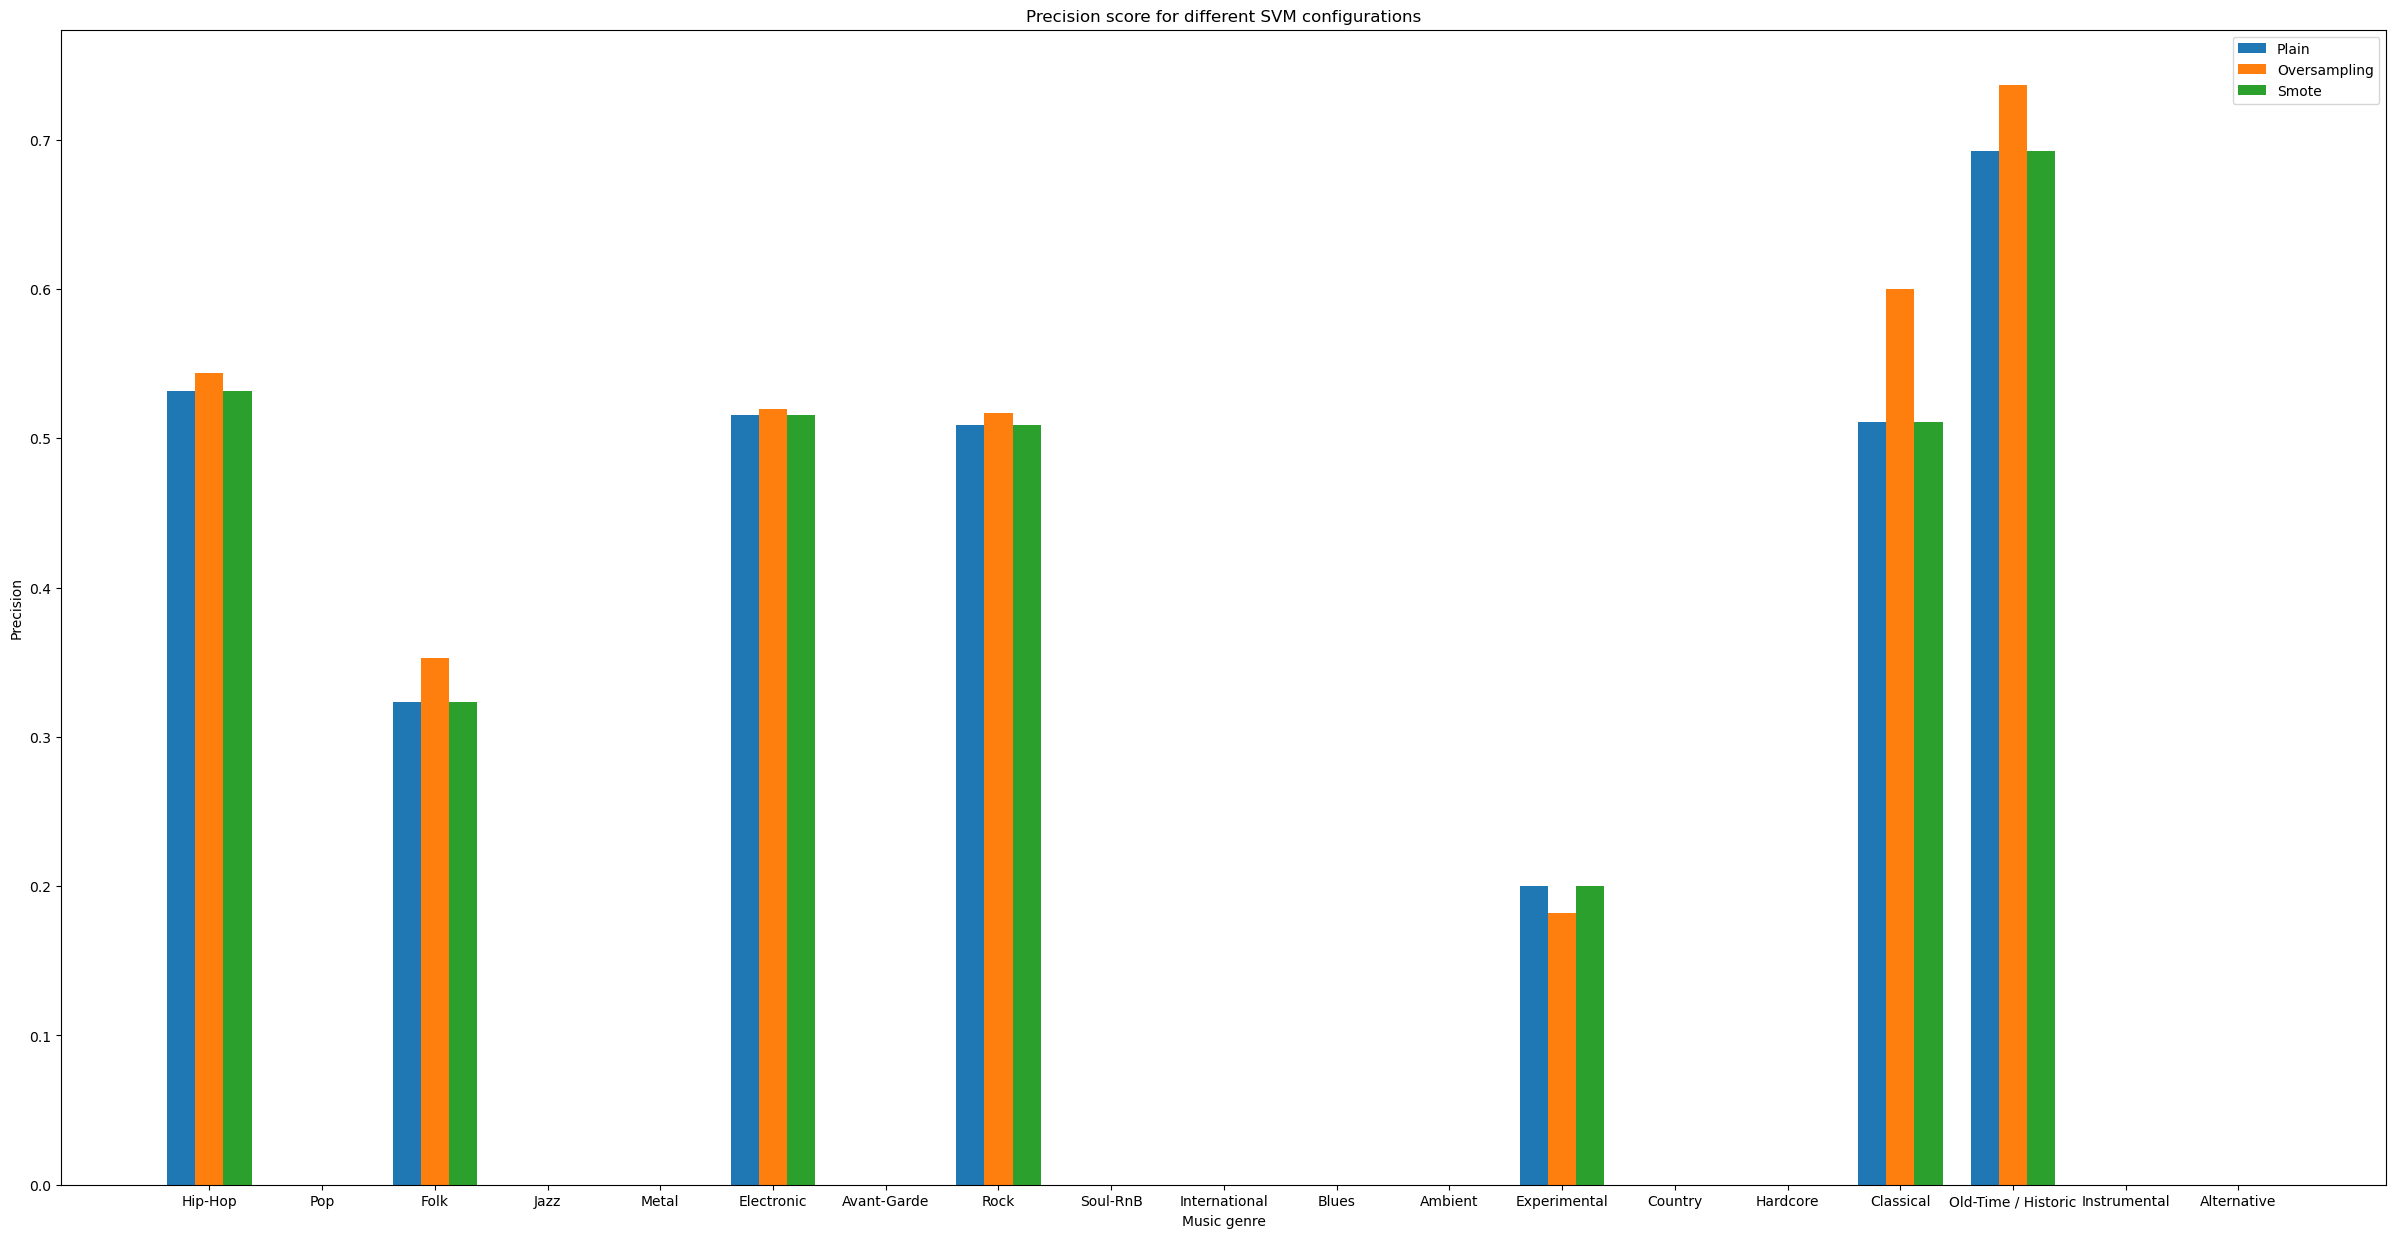

In [29]:
three_group_bar_plot(svm_precision, svm_precision_os, svm_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different SVM configurations", "Music genre", 
                    "Precision", legend_validation)

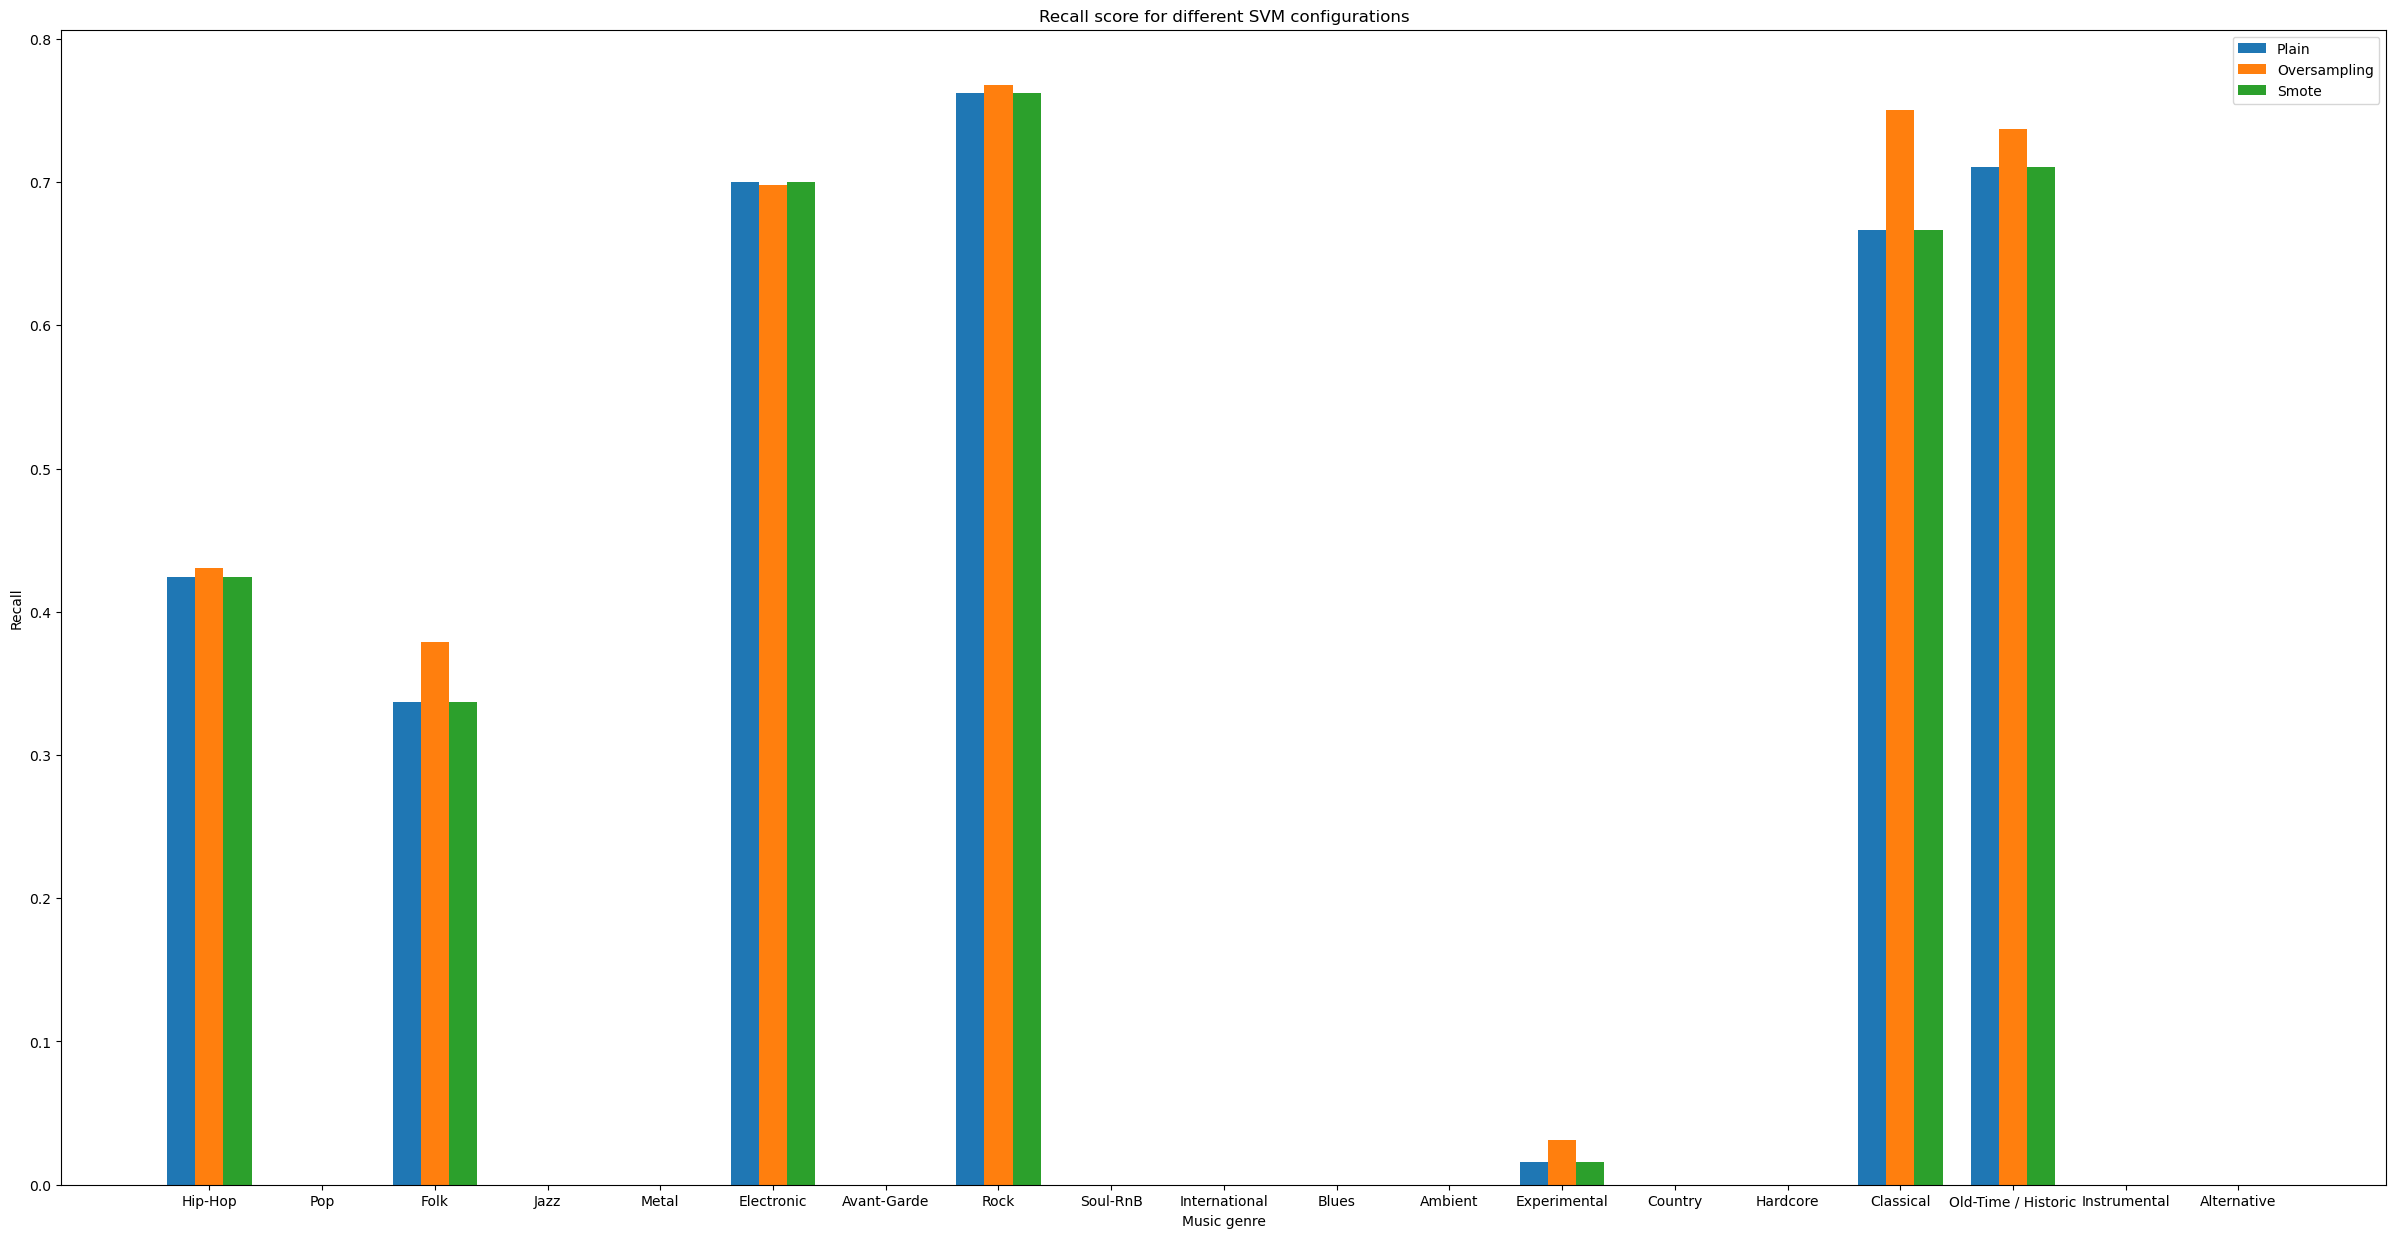

In [30]:
three_group_bar_plot(svm_recall, svm_recall_os, svm_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different SVM configurations", "Music genre", 
                    "Recall", legend_validation)

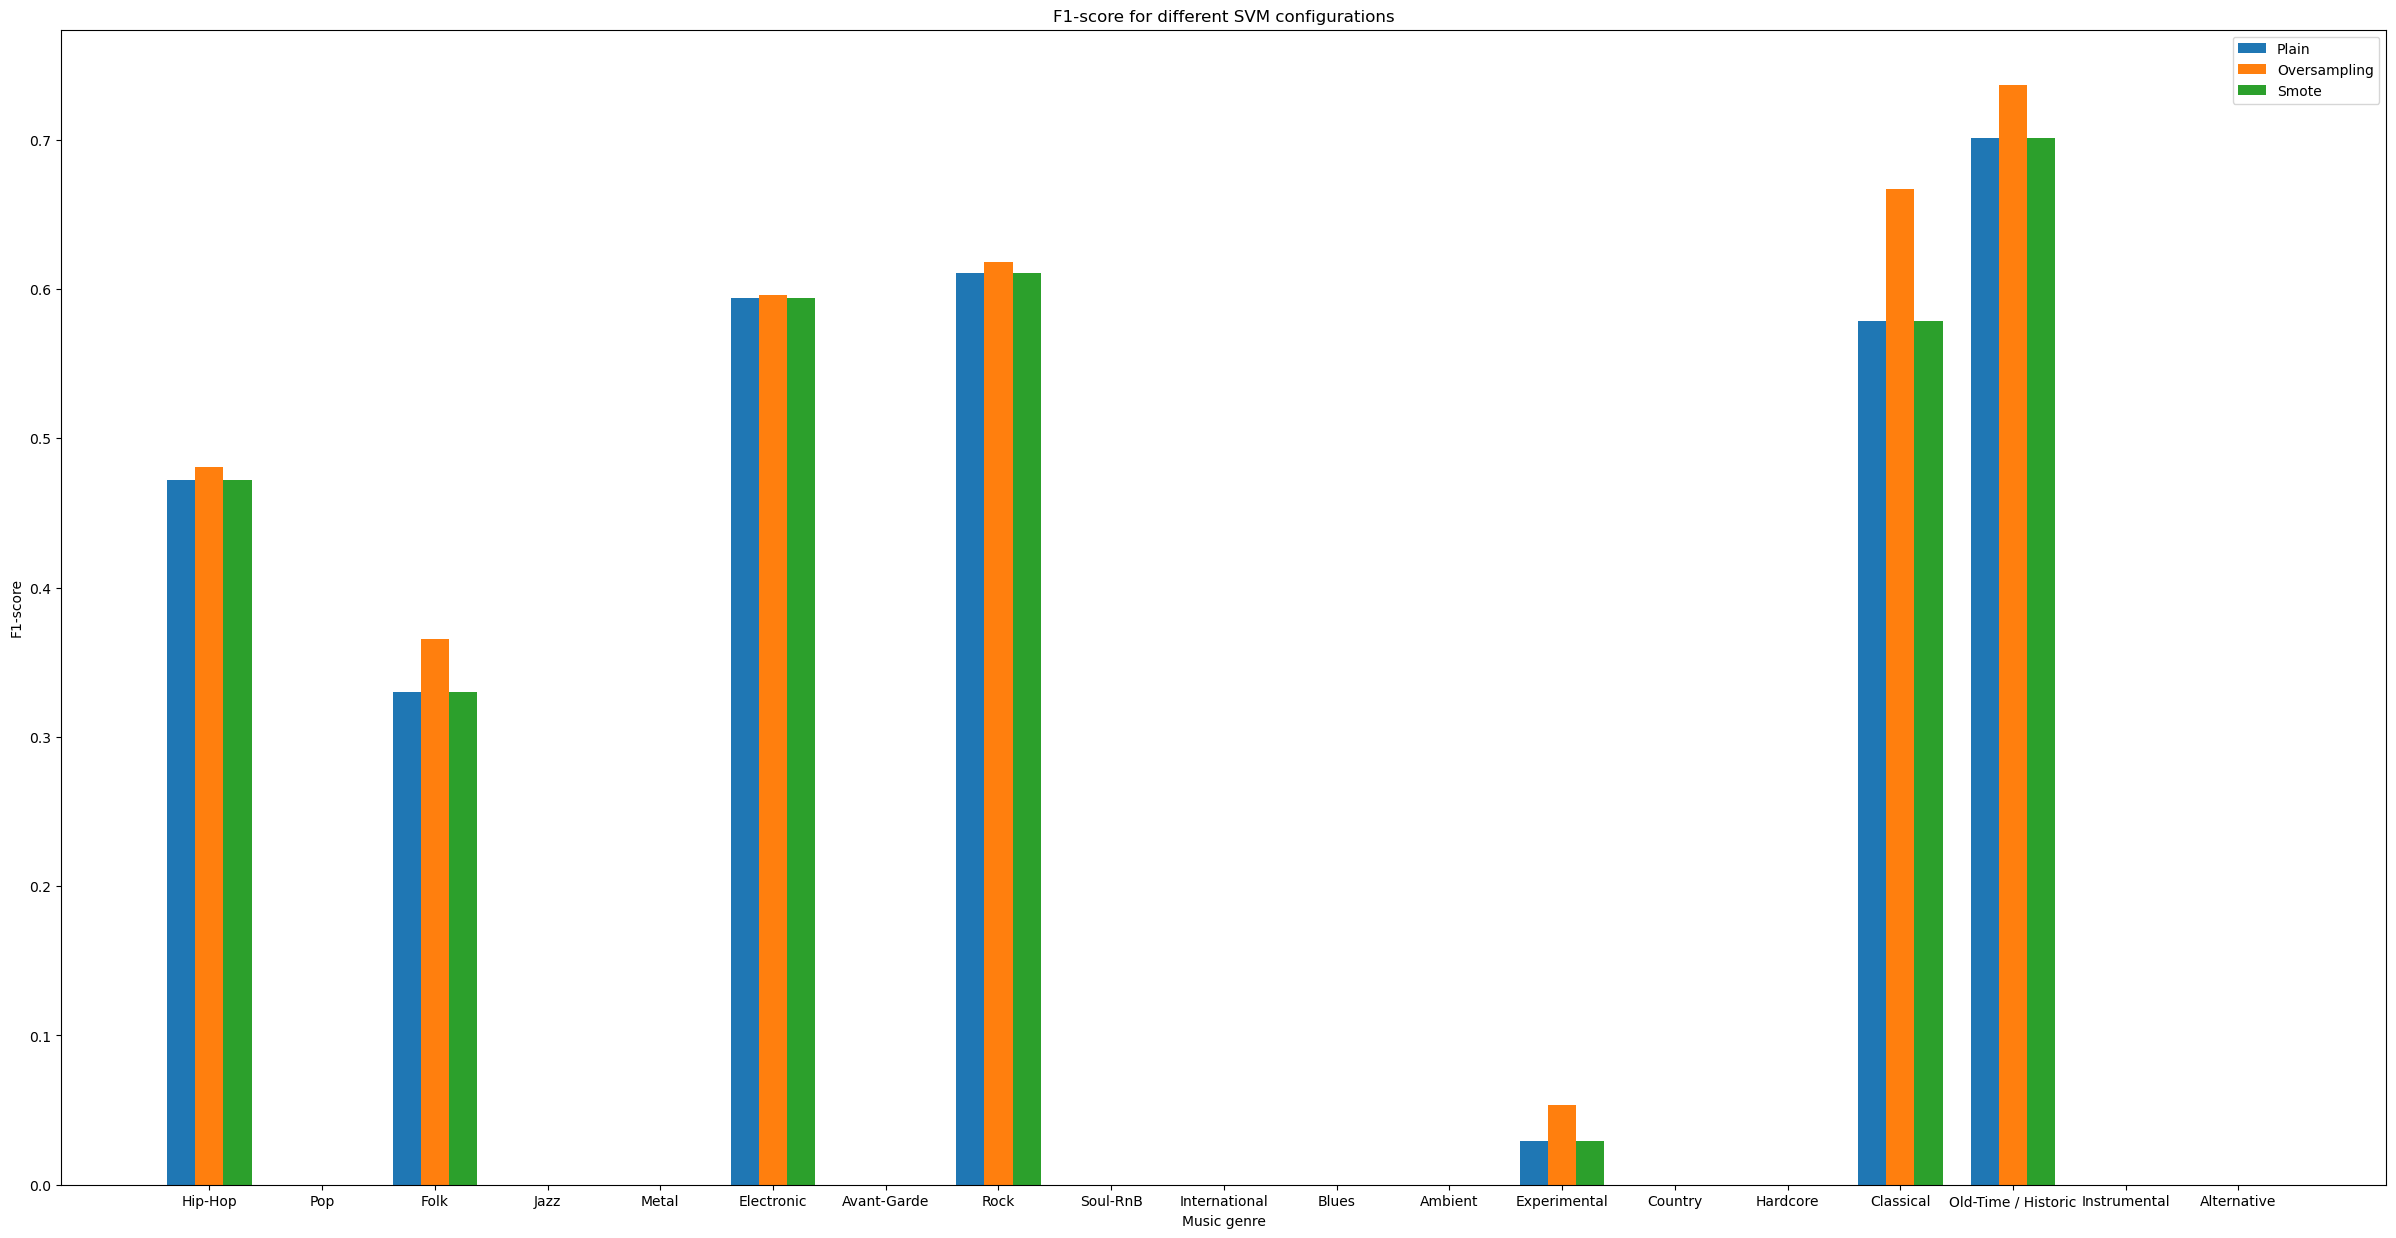

In [31]:
three_group_bar_plot(svm_f1, svm_f1_os, svm_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different SVM configurations", "Music genre", 
                    "F1-score", legend_validation)

### SVM on test set
Best case: OverSampling

In [15]:
orig_labels = le.inverse_transform(labels)
svm_clf = skl.svm.SVC(C=overs['SVM']['C_best'], kernel='rbf').fit(X_train_os, y_train_os)
svm_test_preds = svm_clf.predict(X_test)

svm_results_test = compute_class_metrics(
        predictions=le.inverse_transform(svm_test_preds), 
        y_set=le.inverse_transform(y_test), 
        labels= orig_labels
)
svm_report_test = svm_results_test[0]
svm_precision_test = svm_results_test[1]
svm_recall_test = svm_results_test[2]
svm_f1_test = svm_results_test[3]
svm_cm_test = confusion_matrix(y_test, svm_test_preds, labels=labels)

In [33]:
orig_labels = le.inverse_transform(labels)
pca = PCA(n_components=overs_pca['SVM']['n_components'])
X_train_pca = pca.fit_transform(X_train_os, y_train_os)
X_test_pca = pca.transform(X_test)

svm_clf = skl.svm.SVC(C=overs_pca['SVM']['C'], kernel='rbf').fit(X_train_pca, y_train_os)
svm_test_preds_pca = svm_clf.predict(X_test_pca)

svm_results_test_pca = compute_class_metrics(
        predictions=le.inverse_transform(svm_test_preds_pca), 
        y_set=le.inverse_transform(y_test), 
        labels= orig_labels
)

svm_report_test_pca = svm_results_test_pca[0]
svm_precision_test_pca = svm_results_test_pca[1]
svm_recall_test_pca = svm_results_test_pca[2]
svm_f1_test_pca = svm_results_test_pca[3]

In [35]:
svm_clf = skl.svm.SVC(C=overs['SVM']['C_best'], kernel='rbf').fit(X_train_os_fs, y_train_os_fs)
svm_test_preds_fs = svm_clf.predict(X_test_fs)

svm_results_test_fs = compute_class_metrics(
        predictions=le.inverse_transform(svm_test_preds_fs), 
        y_set=le.inverse_transform(y_test_fs), 
        labels= orig_labels
)

svm_report_test_fs = svm_results_test_fs[0]
svm_precision_test_fs = svm_results_test_fs[1]
svm_recall_test_fs = svm_results_test_fs[2]
svm_f1_test_fs = svm_results_test_fs[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

In [22]:
print_acc_table(svm_results_test[4])

Metric     Score
0  Accuracy  0.467308

In [37]:
print("------------------ SVM Metrics with oversampling on test set ------------------")
svm_report_test

------------------ SVM Metrics with oversampling on test set ------------------


precision    recall  f1-score  support
Hip-Hop               0.614943  0.625731  0.620290      171
Pop                   0.250000  0.015873  0.029851       63
Folk                  0.476190  0.431034  0.452489      116
Jazz                  0.230769  0.068182  0.105263       44
Metal                 0.161765  0.305556  0.211538       36
Electronic            0.612346  0.574074  0.592593      432
Avant-Garde           0.065217  0.125000  0.085714       24
Rock                  0.549419  0.532394  0.540773      355
Soul-RnB              0.052632  0.090909  0.066667       11
International         0.191176  0.419355  0.262626       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.096774  0.214286  0.133333       28
Experimental          0.142857  0.050847  0.075000       59
Country               0.103448  0.428571  0.166667        7
Hardcore              0.131579  0.312500  0.185185       16
Classical             0.666667  0.780488  0.719101       41
Old-Time / Historic   0.870370  0.886792  0.878505       53
Instrumental          0.266667  0.296296  0.280702       27
Alternative           0.166667  0.030303  0.051282       33
macro avg             0.297341  0.325694  0.287241     1560
weighted avg          0.487115  0.468590  0.467433     1560

In [38]:
print_acc_table(svm_results_test_pca[4])

Metric     Score
0  Accuracy  0.475641

In [39]:
print("------------------ SVM Metrics with oversampling (PCA) on test set ------------------")
svm_report_test_pca

------------------ SVM Metrics with oversampling (PCA) on test set ------------------


precision    recall  f1-score  support
Hip-Hop               0.625731  0.625731  0.625731      171
Pop                   0.105263  0.031746  0.048780       63
Folk                  0.519608  0.456897  0.486239      116
Jazz                  0.205882  0.159091  0.179487       44
Metal                 0.259259  0.388889  0.311111       36
Electronic            0.633663  0.592593  0.612440      432
Avant-Garde           0.000000  0.000000  0.000000       24
Rock                  0.568323  0.515493  0.540620      355
Soul-RnB              0.043478  0.090909  0.058824       11
International         0.244444  0.354839  0.289474       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.078431  0.142857  0.101266       28
Experimental          0.181818  0.135593  0.155340       59
Country               0.166667  0.571429  0.258065        7
Hardcore              0.093023  0.250000  0.135593       16
Classical             0.647059  0.804878  0.717391       41
Old-Time / Historic   0.905660  0.905660  0.905660       53
Instrumental          0.192308  0.185185  0.188679       27
Alternative           0.071429  0.060606  0.065574       33
macro avg             0.291687  0.330126  0.298962     1560
weighted avg          0.495839  0.475641  0.482267     1560

In [40]:
print_acc_table(svm_results_test_fs[4])

Metric     Score
0  Accuracy  0.480128

In [41]:
print("------------------ SVM Metrics with oversampling (fs) on test set ------------------")
svm_report_test_fs

------------------ SVM Metrics with oversampling (fs) on test set ------------------


precision    recall  f1-score  support
Hip-Hop               0.580110  0.614035  0.596591      171
Pop                   0.000000  0.000000  0.000000       63
Folk                  0.528846  0.474138  0.500000      116
Jazz                  0.142857  0.022727  0.039216       44
Metal                 0.116667  0.194444  0.145833       36
Electronic            0.582751  0.578704  0.580720      432
Avant-Garde           0.129032  0.166667  0.145455       24
Rock                  0.566038  0.591549  0.578512      355
Soul-RnB              0.083333  0.090909  0.086957       11
International         0.196429  0.354839  0.252874       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.114754  0.250000  0.157303       28
Experimental          0.100000  0.033898  0.050633       59
Country               0.071429  0.142857  0.095238        7
Hardcore              0.114286  0.250000  0.156863       16
Classical             0.555556  0.853659  0.673077       41
Old-Time / Historic   0.888889  0.905660  0.897196       53
Instrumental          0.177778  0.296296  0.222222       27
Alternative           0.000000  0.000000  0.000000       33
macro avg             0.260461  0.306336  0.272563     1560
weighted avg          0.461510  0.480128  0.466178     1560

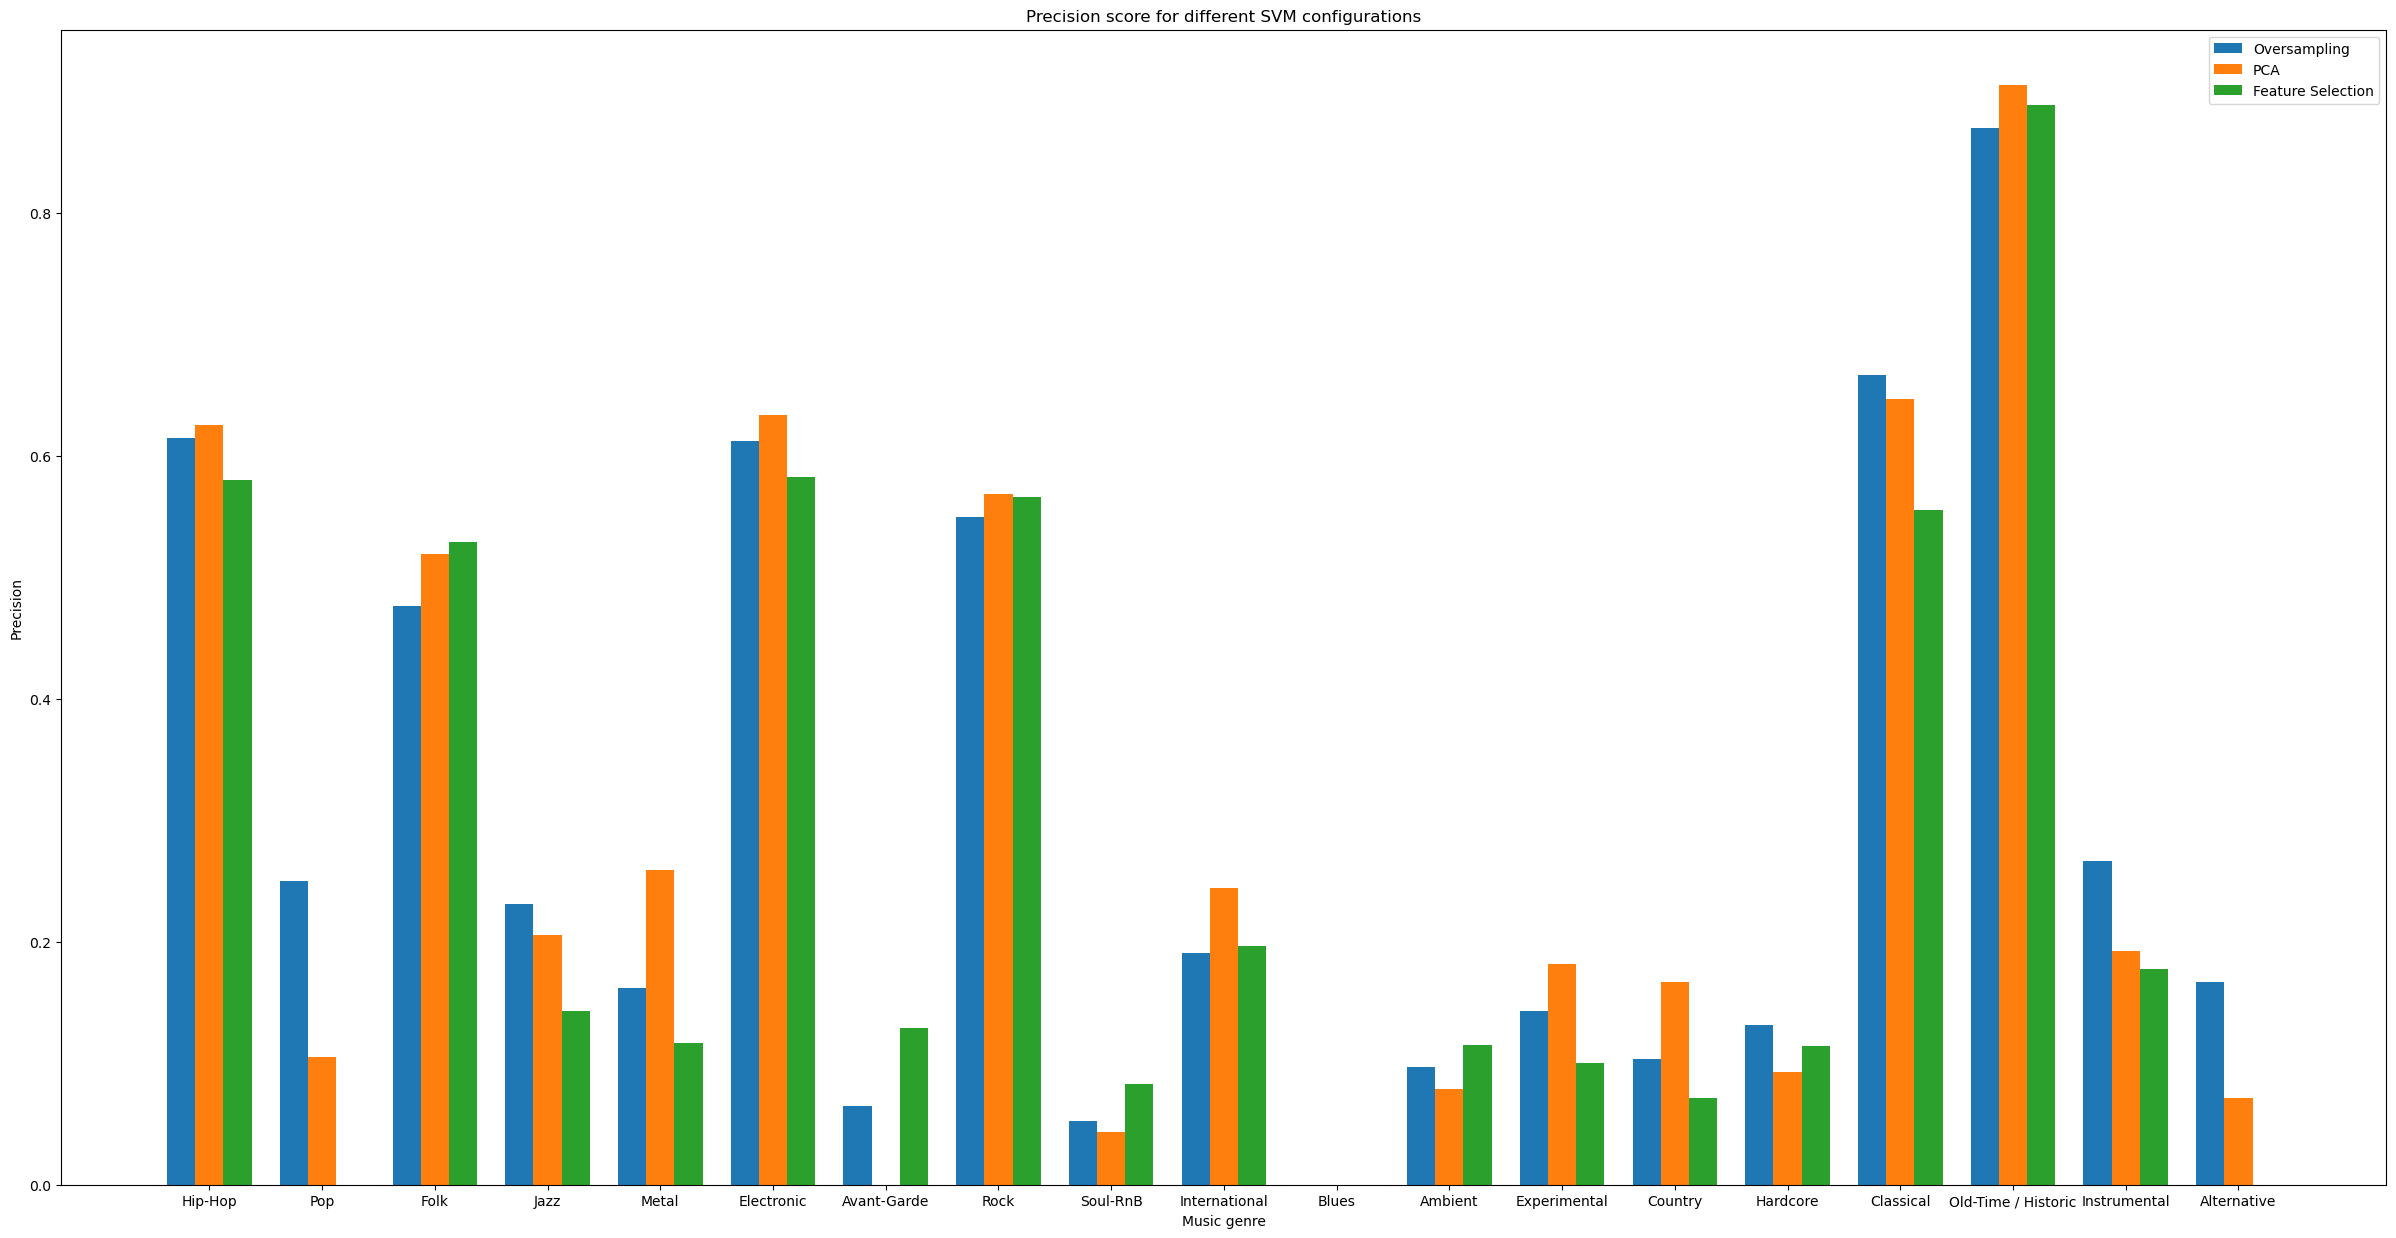

In [42]:
three_group_bar_plot(svm_precision_test, svm_precision_test_pca, svm_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different SVM configurations", "Music genre", 
                    "Precision", ["Oversampling"]+legend_test)

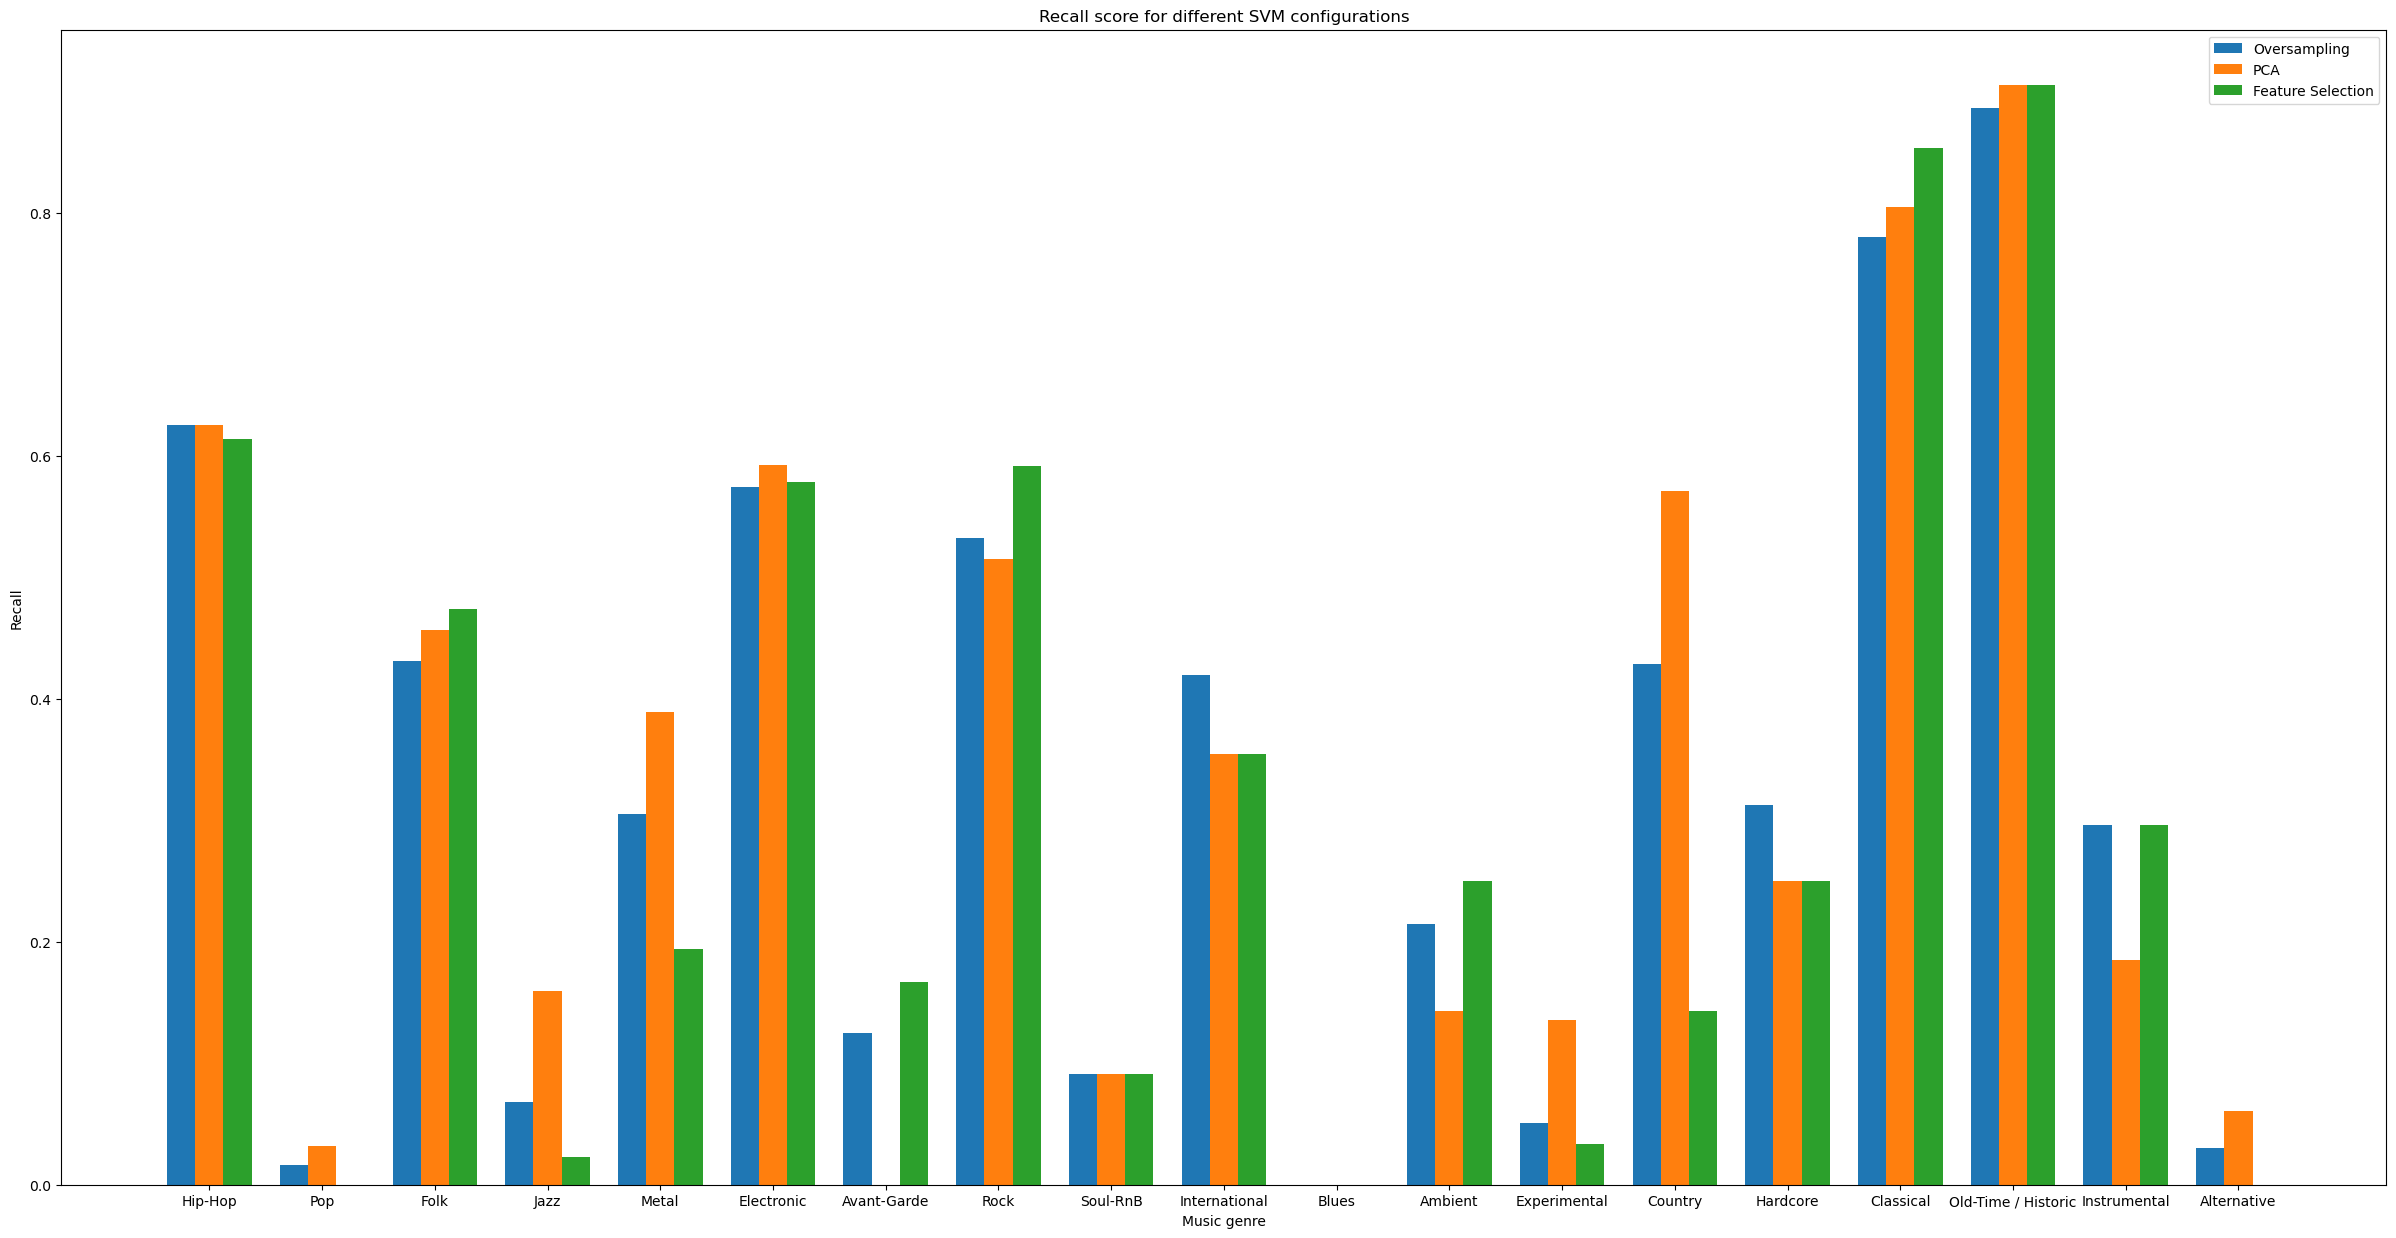

In [43]:
three_group_bar_plot(svm_recall_test, svm_recall_test_pca, svm_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different SVM configurations", "Music genre", 
                    "Recall", ["Oversampling"]+legend_test)

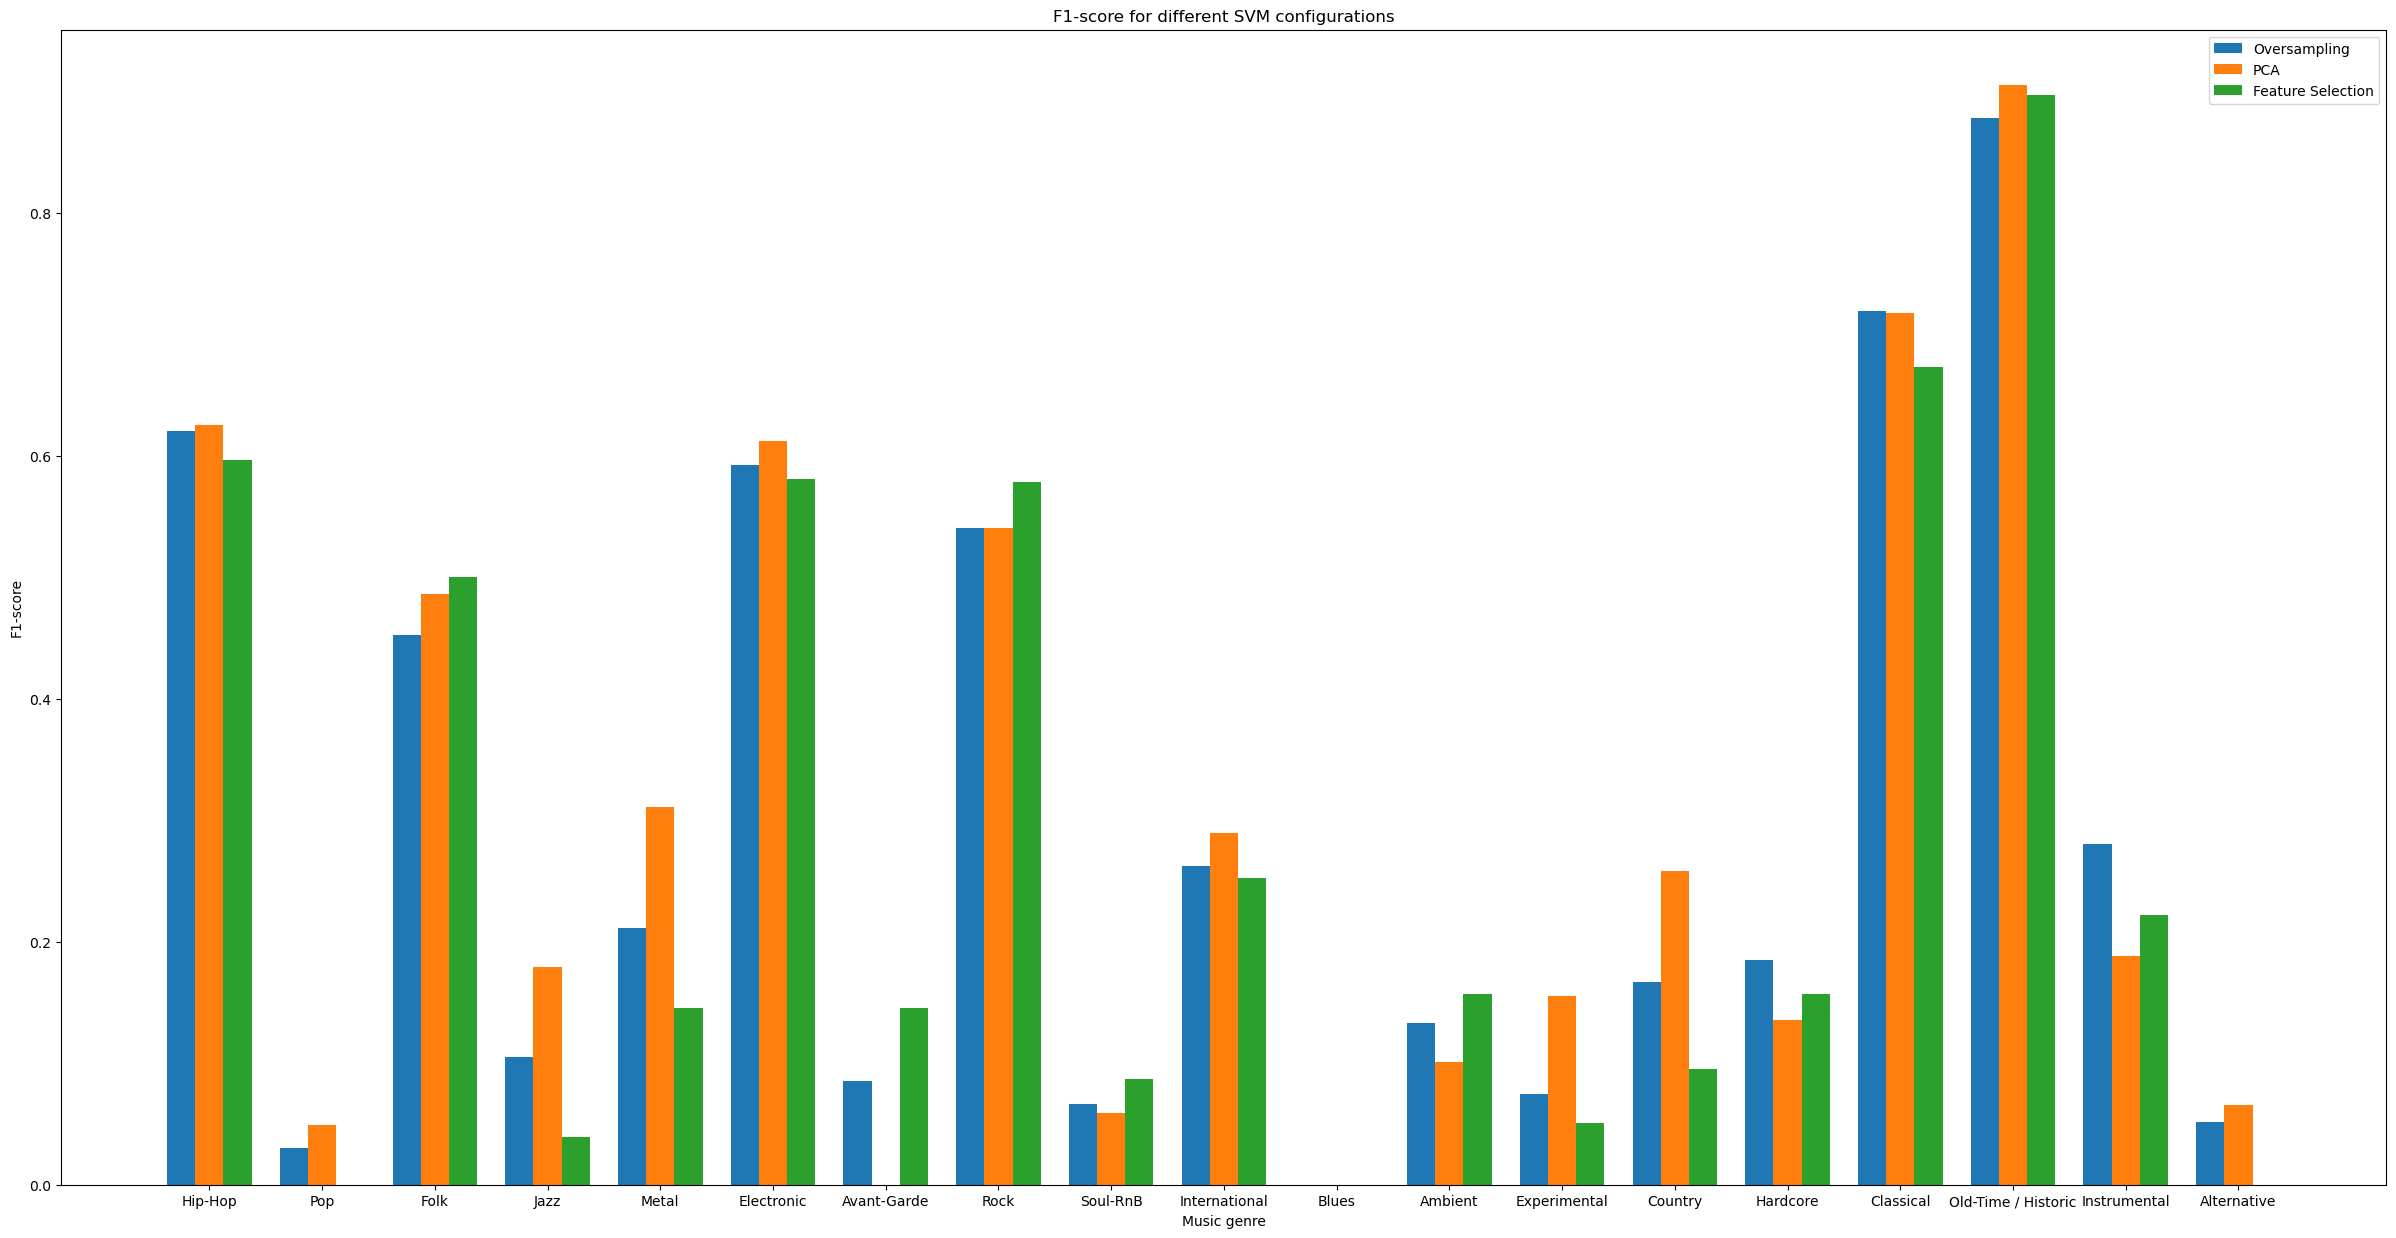

In [44]:
three_group_bar_plot(svm_f1_test, svm_f1_test_pca, svm_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different SVM configurations", "Music genre", 
                    "F1-score", ["Oversampling"]+legend_test)

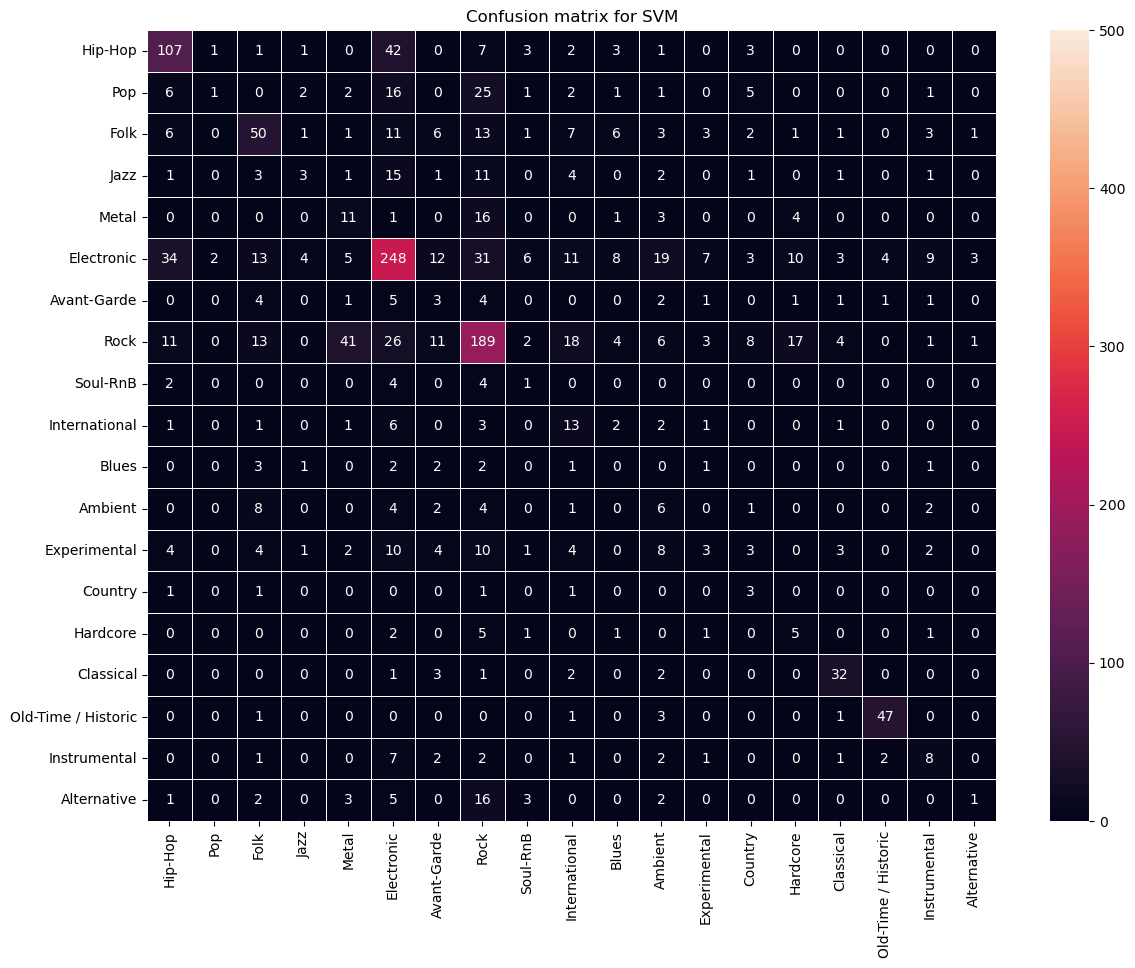

In [45]:
print_cm(svm_cm_test, orig_labels, "Confusion matrix for SVM")

## LR classification

### LR without tweaks

In [46]:
lr_clf = LogisticRegression(C=1, penalty=plain['LR']['penalty'], dual=False, 
                            solver=plain['LR']['solver']).fit(X_train, y_train)
lr_val_predict = cross_val_predict(lr_clf, X_validate, y_validate, cv=5)

lr_results = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report = lr_results[0]
lr_precision = lr_results[1]
lr_recall = lr_results[2]
lr_f1 = lr_results[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to conver

### LR with oversampling

In [47]:
lr_clf_os = LogisticRegression(C=1, penalty=overs['LR']['penalty'], dual=False, 
                               solver=overs['LR']['solver']).fit(X_train_os, y_train_os)
lr_val_predict_os = cross_val_predict(lr_clf_os, X_validate, y_validate, cv=5)

lr_results_os = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report_os = lr_results_os[0]
lr_precision_os = lr_results_os[1]
lr_recall_os = lr_results_os[2]
lr_f1_os = lr_results_os[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to conver

### LR with SMOTE

In [48]:
lr_clf_smote = LogisticRegression(C=1, penalty=smote['LR']['penalty'], dual=False, 
                                  solver=smote['LR']['solver']).fit(X_train_smote, y_train_smote)
lr_val_predict_smote = cross_val_predict(lr_clf_smote, X_validate, y_validate, cv=5)

lr_results_smote = compute_class_metrics(predictions=le.inverse_transform(lr_val_predict_smote), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
lr_report_smote = lr_results_smote[0]
lr_precision_smote = lr_results_smote[1]
lr_recall_smote = lr_results_smote[2]
lr_f1_smote = lr_results_smote[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to conver

### Metrics comparison for LR

In [49]:
print_acc_table(lr_results[4])

Metric     Score
0  Accuracy  0.524217

In [50]:
print("------------------------------ LR Metrics without tweaks ------------------------------")
lr_report

------------------------------ LR Metrics without tweaks ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.578947  0.487342  0.529210      158
Pop                   0.200000  0.019608  0.035714       51
Folk                  0.452830  0.505263  0.477612       95
Jazz                  0.100000  0.028571  0.044444       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.548729  0.652393  0.596087      397
Avant-Garde           0.100000  0.034483  0.051282       29
Rock                  0.556225  0.765193  0.644186      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.266667  0.125000  0.170213       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.674419  0.805556  0.734177       36
Old-Time / Historic   0.727273  0.842105  0.780488       38
Instrumental          0.214286  0.166667  0.187500       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.232599  0.233273  0.223732     1404
weighted avg          0.458070  0.524217  0.480094     1404

In [51]:
print_acc_table(lr_results_os[4])

Metric     Score
0  Accuracy  0.524217

In [52]:
print("---------------------------- LR Metrics with oversampling ----------------------------")
lr_report_os

---------------------------- LR Metrics with oversampling ----------------------------


precision    recall  f1-score  support
Hip-Hop               0.582090  0.493671  0.534247      158
Pop                   0.000000  0.000000  0.000000       51
Folk                  0.466019  0.505263  0.484848       95
Jazz                  0.090909  0.028571  0.043478       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.555556  0.654912  0.601156      397
Avant-Garde           0.090909  0.034483  0.050000       29
Rock                  0.557114  0.767956  0.645761      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.266667  0.125000  0.170213       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.636364  0.777778  0.700000       36
Old-Time / Historic   0.704545  0.815789  0.756098       38
Instrumental          0.214286  0.166667  0.187500       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.219182  0.230005  0.219647     1404
weighted avg          0.452206  0.524217  0.480105     1404

In [53]:
print_acc_table(lr_results_smote[4])

Metric     Score
0  Accuracy  0.524217

In [54]:
print("-------------------------------- LR Metrics with SMOTE --------------------------------")
lr_report_smote

-------------------------------- LR Metrics with SMOTE --------------------------------


precision    recall  f1-score  support
Hip-Hop               0.582090  0.493671  0.534247      158
Pop                   0.000000  0.000000  0.000000       51
Folk                  0.466019  0.505263  0.484848       95
Jazz                  0.090909  0.028571  0.043478       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.555556  0.654912  0.601156      397
Avant-Garde           0.090909  0.034483  0.050000       29
Rock                  0.557114  0.767956  0.645761      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.266667  0.125000  0.170213       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.636364  0.777778  0.700000       36
Old-Time / Historic   0.704545  0.815789  0.756098       38
Instrumental          0.214286  0.166667  0.187500       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.219182  0.230005  0.219647     1404
weighted avg          0.452206  0.524217  0.480105     1404

In [55]:
three_group_bar_plot(lr_precision, lr_precision_os, lr_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different LR configurations", "Music genre", 
                    "Precision", legend_validation)

In [56]:
three_group_bar_plot(lr_recall, lr_recall_os, lr_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different LR configurations", "Music genre", 
                    "Recall", legend_validation)

In [57]:
three_group_bar_plot(lr_f1, lr_f1_os, lr_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different LR configurations", "Music genre", 
                    "F1-score", legend_validation)

### LR on test set
Best case: plain

In [20]:
orig_labels = le.inverse_transform(labels)
lr_clf = LogisticRegression(C=1, penalty=plain['LR']['penalty'], dual=False, 
                             solver=plain['LR']['solver']).fit(X_train, y_train)

lr_test_preds = lr_clf.predict(X_test)
lr_results_test = compute_class_metrics(
    predictions = le.inverse_transform(lr_test_preds), 
    y_set= le.inverse_transform(y_test), 
    labels=orig_labels
)

lr_report_test = lr_results_test[0]
lr_precision_test = lr_results_test[1]
lr_recall_test = lr_results_test[2]
lr_f1_test = lr_results_test[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

In [59]:
pca = PCA(n_components=plain_pca['LR']['n_components'])
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)

lr_clf = LogisticRegression(C=1, penalty=plain_pca['LR']['penalty'], dual=False, 
                             solver=plain_pca['LR']['solver']).fit(X_train_pca, y_train)
lr_test_preds_pca = lr_clf.predict(X_test_pca)
lr_results_test_pca = compute_class_metrics(
    predictions = le.inverse_transform(lr_test_preds_pca), 
    y_set= le.inverse_transform(y_test), 
    labels=orig_labels
)

lr_report_test_pca = lr_results_test_pca[0]
lr_precision_test_pca = lr_results_test_pca[1]
lr_recall_test_pca = lr_results_test_pca[2]
lr_f1_test_pca = lr_results_test_pca[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

In [60]:
lr_clf = LogisticRegression(C=1, penalty=plain['LR']['penalty'], dual=False, 
                             solver=plain['LR']['solver']).fit(X_train_fs, y_train)
lr_test_preds_fs = lr_clf.predict(X_test_fs)
lr_results_test_fs = compute_class_metrics(
    predictions = le.inverse_transform(lr_test_preds_fs), 
    y_set= le.inverse_transform(y_test_fs), 
    labels=orig_labels
)

lr_report_test_fs = lr_results_test_fs[0]
lr_precision_test_fs = lr_results_test_fs[1]
lr_recall_test_fs = lr_results_test_fs[2]
lr_f1_test_fs = lr_results_test_fs[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted

In [61]:
print_acc_table(lr_results_test[4])

Metric     Score
0  Accuracy  0.576923

In [62]:
print("---------------------------- LR Metrics on test set ------------------------------")
lr_report_test

---------------------------- LR Metrics on test set ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.686667  0.602339  0.641745      171
Pop                   0.000000  0.000000  0.000000       63
Folk                  0.559322  0.568966  0.564103      116
Jazz                  0.000000  0.000000  0.000000       44
Metal                 0.000000  0.000000  0.000000       36
Electronic            0.587074  0.756944  0.661274      432
Avant-Garde           0.250000  0.041667  0.071429       24
Rock                  0.522920  0.867606  0.652542      355
Soul-RnB              0.000000  0.000000  0.000000       11
International         0.500000  0.096774  0.162162       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.200000  0.035714  0.060606       28
Experimental          0.428571  0.050847  0.090909       59
Country               0.000000  0.000000  0.000000        7
Hardcore              0.500000  0.062500  0.111111       16
Classical             0.625000  0.731707  0.674157       41
Old-Time / Historic   0.894737  0.962264  0.927273       53
Instrumental          0.375000  0.222222  0.279070       27
Alternative           0.000000  0.000000  0.000000       33
macro avg             0.322594  0.263134  0.257704     1560
weighted avg          0.490456  0.576923  0.507947     1560

In [63]:
print_acc_table(lr_results_test_pca[4])

Metric     Score
0  Accuracy  0.573718

In [64]:
print("---------------------------- LR Metrics on test set (PCA) ------------------------------")
lr_report_test_pca

---------------------------- LR Metrics on test set (PCA) ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.694268  0.637427  0.664634      171
Pop                   0.000000  0.000000  0.000000       63
Folk                  0.496454  0.603448  0.544747      116
Jazz                  0.000000  0.000000  0.000000       44
Metal                 0.000000  0.000000  0.000000       36
Electronic            0.595903  0.740741  0.660475      432
Avant-Garde           0.272727  0.125000  0.171429       24
Rock                  0.545956  0.836620  0.660734      355
Soul-RnB              0.000000  0.000000  0.000000       11
International         0.333333  0.096774  0.150000       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.000000  0.000000  0.000000       28
Experimental          0.166667  0.050847  0.077922       59
Country               0.000000  0.000000  0.000000        7
Hardcore              1.000000  0.062500  0.117647       16
Classical             0.632653  0.756098  0.688889       41
Old-Time / Historic   0.796875  0.962264  0.871795       53
Instrumental          0.411765  0.259259  0.318182       27
Alternative           0.000000  0.000000  0.000000       33
macro avg             0.312979  0.270051  0.259287     1560
weighted avg          0.480485  0.573718  0.509624     1560

In [65]:
print_acc_table(lr_results_test_fs[4])

Metric    Score
0  Accuracy  0.49359

In [66]:
print("---------------------------- LR Metrics on test set (fs) ------------------------------")
lr_report_test_fs

---------------------------- LR Metrics on test set (fs) ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.573529  0.456140  0.508143      171
Pop                   0.000000  0.000000  0.000000       63
Folk                  0.505747  0.379310  0.433498      116
Jazz                  0.000000  0.000000  0.000000       44
Metal                 0.000000  0.000000  0.000000       36
Electronic            0.489076  0.673611  0.566699      432
Avant-Garde           0.000000  0.000000  0.000000       24
Rock                  0.465154  0.808451  0.590535      355
Soul-RnB              0.000000  0.000000  0.000000       11
International         0.000000  0.000000  0.000000       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.000000  0.000000  0.000000       28
Experimental          0.000000  0.000000  0.000000       59
Country               0.000000  0.000000  0.000000        7
Hardcore              0.000000  0.000000  0.000000       16
Classical             0.528302  0.682927  0.595745       41
Old-Time / Historic   0.735849  0.735849  0.735849       53
Instrumental          0.375000  0.111111  0.171429       27
Alternative           0.000000  0.000000  0.000000       33
macro avg             0.193298  0.202495  0.189574     1560
weighted avg          0.387138  0.493590  0.422876     1560

In [67]:
three_group_bar_plot(lr_precision_test, lr_precision_test_pca, lr_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different LR configurations", "Music genre", 
                    "Precision", ["Plain"]+legend_test)

In [68]:
three_group_bar_plot(lr_recall_test, lr_recall_test_pca, lr_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different LR configurations", "Music genre", 
                    "Recall", ["Plain"]+legend_test)

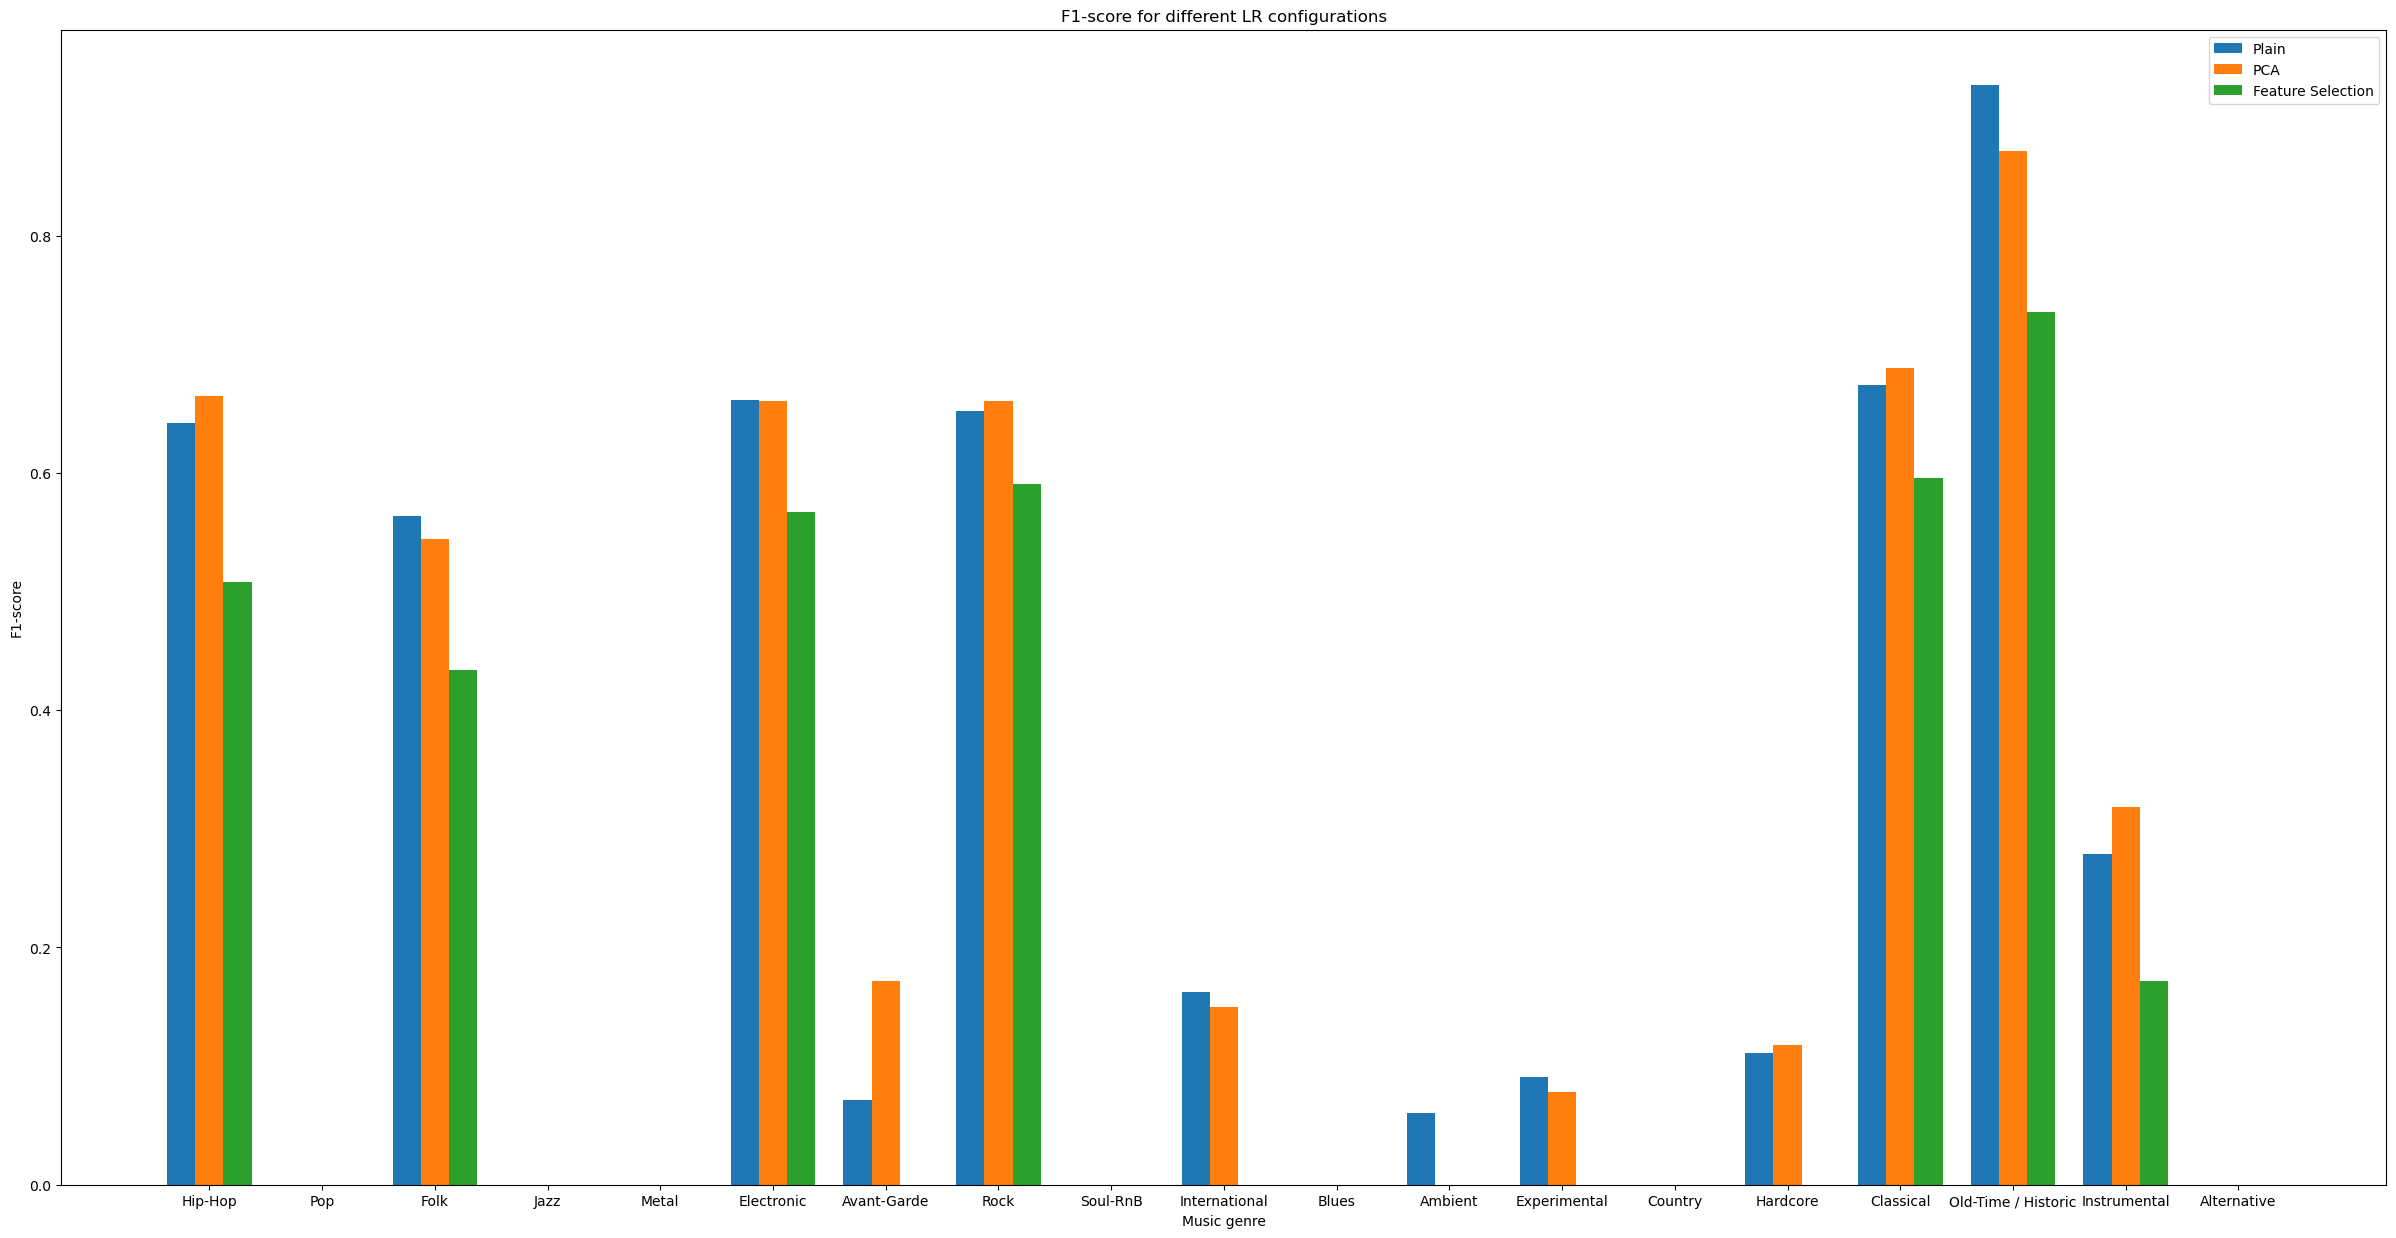

In [69]:
three_group_bar_plot(lr_f1_test, lr_f1_test_pca, lr_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different LR configurations", "Music genre", 
                    "F1-score", ["Plain"]+legend_test)

In [70]:
# Confusion matrix
lr_cm_test = confusion_matrix(y_test, lr_test_preds, labels=labels)
print_cm(lr_cm_test, orig_labels, "Confusion matrix for LR")

## kNN classification

### kNN without tweaks

In [71]:
knn_clf = KNeighborsClassifier(n_neighbors=plain['kNN']['n_neighbours']).fit(X_train, y_train)
knn_val_predict = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results = compute_class_metrics(predictions=le.inverse_transform(knn_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
knn_report = knn_results[0]
knn_precision = knn_results[1]
knn_recall = knn_results[2]
knn_f1 = knn_results[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### kNN with oversampling

In [72]:
knn_clf = KNeighborsClassifier(n_neighbors=overs['kNN']['n_neighbours']).fit(X_train_os, 
                                                                             y_train_os)
knn_val_predict_os = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results_os = compute_class_metrics(predictions=le.inverse_transform(knn_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
knn_report_os = knn_results_os[0]
knn_precision_os = knn_results_os[1]
knn_recall_os = knn_results_os[2]
knn_f1_os = knn_results_os[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### kNN with SMOTE

In [73]:
knn_clf = KNeighborsClassifier(n_neighbors=smote['kNN']['n_neighbours']).fit(X_train_smote, 
                                                                             y_train_smote)
knn_val_predict_smote = cross_val_predict(knn_clf, X_validate, y_validate, cv=5)

knn_results_smote = compute_class_metrics(
    predictions=le.inverse_transform(knn_val_predict_smote), 
    y_set=le.inverse_transform(y_validate), 
    labels=le.inverse_transform(labels))

knn_report_smote = knn_results_smote[0]
knn_precision_smote = knn_results_smote[1]
knn_recall_smote = knn_results_smote[2]
knn_f1_smote = knn_results_smote[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### Metrics comparison for kNN

In [74]:
print_acc_table(knn_results[4])

Metric     Score
0  Accuracy  0.472222

In [75]:
# Print the summary tables
print("----------------------------- kNN Metrics without tweaks -----------------------------")
knn_report

----------------------------- kNN Metrics without tweaks -----------------------------


precision    recall  f1-score  support
Hip-Hop               0.550000  0.417722  0.474820      158
Pop                   0.000000  0.000000  0.000000       51
Folk                  0.293478  0.284211  0.288770       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.474545  0.657431  0.551214      397
Avant-Garde           0.000000  0.000000  0.000000       29
Rock                  0.480000  0.729282  0.578947      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.125000  0.015625  0.027778       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.431818  0.527778  0.475000       36
Old-Time / Historic   0.625000  0.657895  0.641026       38
Instrumental          0.000000  0.000000  0.000000       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.156834  0.173155  0.159871     1404
weighted avg          0.373384  0.472222  0.408905     1404

In [76]:
print_acc_table(knn_results_os[4])

Metric     Score
0  Accuracy  0.311966

In [77]:
print("--------------------------- kNN Metrics with oversampling ----------------------------")
knn_report_os

--------------------------- kNN Metrics with oversampling ----------------------------


precision    recall  f1-score  support
Hip-Hop               0.390977  0.329114  0.357388      158
Pop                   0.029412  0.019608  0.023529       51
Folk                  0.148148  0.168421  0.157635       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.083333  0.095238  0.088889       21
Electronic            0.405745  0.569270  0.473795      397
Avant-Garde           0.046512  0.068966  0.055556       29
Rock                  0.559524  0.259669  0.354717      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.120000  0.142857  0.130435       21
Blues                 0.045455  0.111111  0.064516        9
Ambient               0.038462  0.076923  0.051282       13
Experimental          0.014925  0.015625  0.015267       64
Country               0.090909  0.200000  0.125000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.358491  0.527778  0.426966       36
Old-Time / Historic   0.818182  0.473684  0.600000       38
Instrumental          0.090909  0.055556  0.068966       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.170578  0.163885  0.157576     1404
weighted avg          0.352242  0.311966  0.311699     1404

In [78]:
print_acc_table(knn_results_smote[4])

Metric     Score
0  Accuracy  0.311966

In [79]:
print("-------------------------------- kNN Metrics with SMOTE --------------------------------")
knn_report_smote

-------------------------------- kNN Metrics with SMOTE --------------------------------


precision    recall  f1-score  support
Hip-Hop               0.390977  0.329114  0.357388      158
Pop                   0.029412  0.019608  0.023529       51
Folk                  0.148148  0.168421  0.157635       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.083333  0.095238  0.088889       21
Electronic            0.405745  0.569270  0.473795      397
Avant-Garde           0.046512  0.068966  0.055556       29
Rock                  0.559524  0.259669  0.354717      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.120000  0.142857  0.130435       21
Blues                 0.045455  0.111111  0.064516        9
Ambient               0.038462  0.076923  0.051282       13
Experimental          0.014925  0.015625  0.015267       64
Country               0.090909  0.200000  0.125000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.358491  0.527778  0.426966       36
Old-Time / Historic   0.818182  0.473684  0.600000       38
Instrumental          0.090909  0.055556  0.068966       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.170578  0.163885  0.157576     1404
weighted avg          0.352242  0.311966  0.311699     1404

In [80]:
three_group_bar_plot(knn_precision, knn_precision_os, knn_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different kNN configurations", "Music genre", 
                    "Precision", legend_validation)

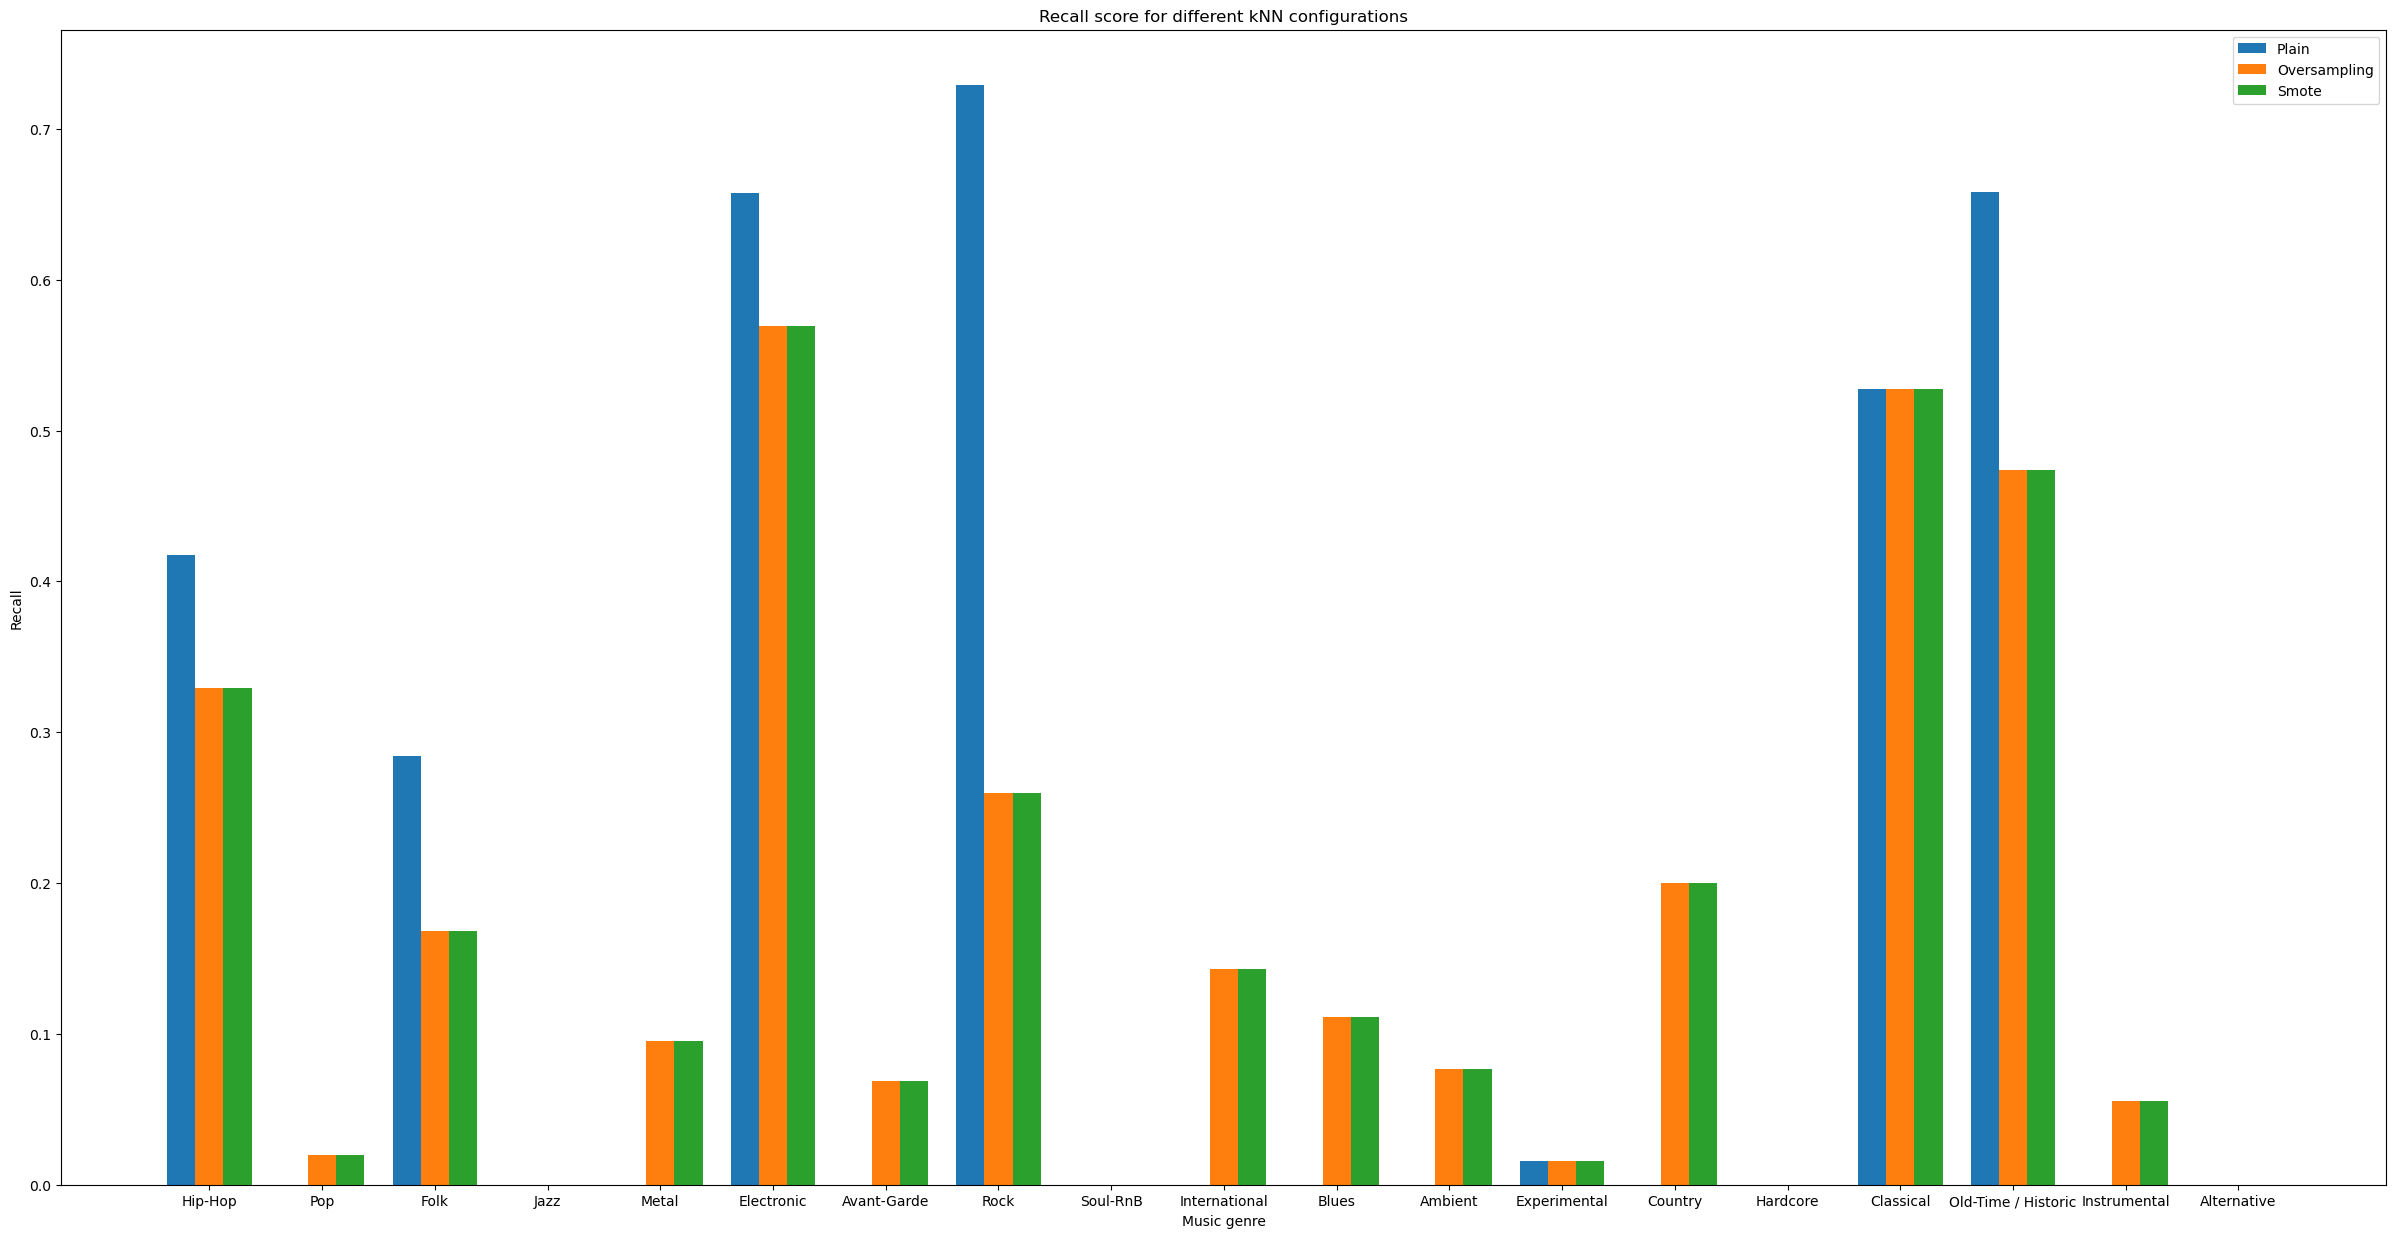

In [81]:
three_group_bar_plot(knn_recall, knn_recall_os, knn_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different kNN configurations", "Music genre", 
                    "Recall", legend_validation)

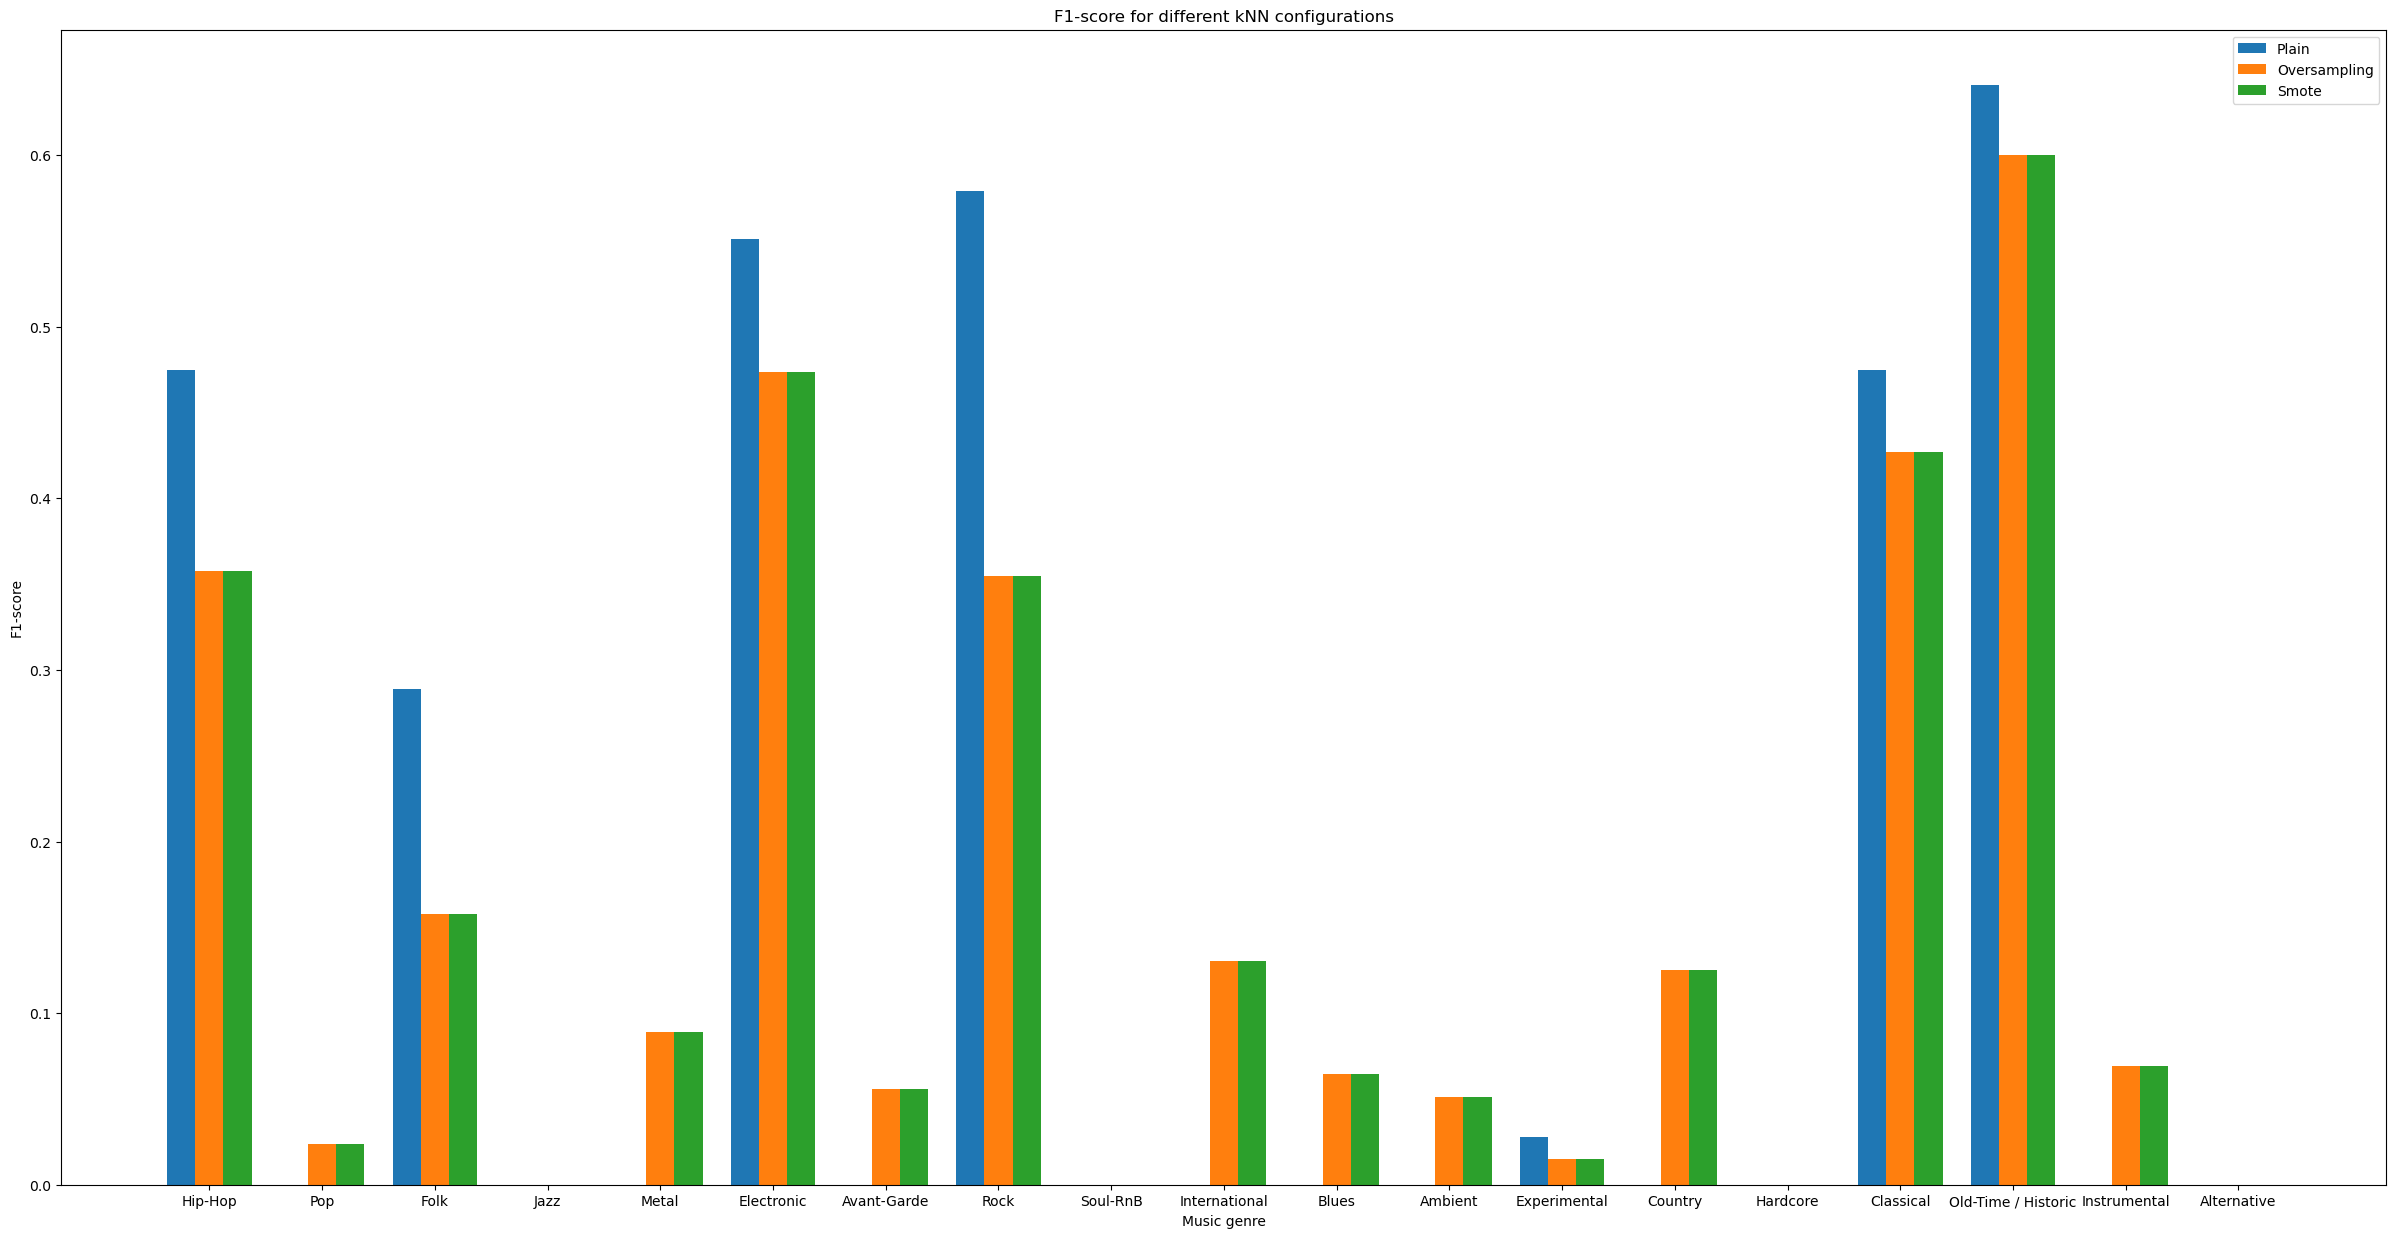

In [82]:
three_group_bar_plot(knn_f1, knn_f1_os, knn_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different kNN configurations", "Music genre", 
                    "F1-score", legend_validation)

### kNN on test set
Best case: plain

In [16]:
orig_labels = le.inverse_transform(labels)
knn_clf = KNeighborsClassifier(n_neighbors=plain['kNN']['n_neighbours']).fit(X_train, 
                                                                      y_train)
knn_test_preds = knn_clf.predict(X_test)
knn_results_test = compute_class_metrics(
    predictions=le.inverse_transform(knn_test_preds), 
    y_set=le.inverse_transform(y_test), 
    labels=orig_labels
)

knn_report_test = knn_results_test[0]
knn_precision_test = knn_results_test[1]
knn_recall_test = knn_results_test[2]
knn_f1_test = knn_results_test[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

In [18]:
pca = PCA(n_components=plain_pca['kNN']['n_components'])
X_train_pca = pca.fit_transform(X_train, y_train)
X_test_pca = pca.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=plain_pca['kNN']['n_neighbours']).fit(X_train_pca, 
                                                                      y_train)
knn_test_preds_pca = knn_clf.predict(X_test_pca)
knn_results_test_pca = compute_class_metrics(
    predictions=le.inverse_transform(knn_test_preds_pca), 
    y_set=le.inverse_transform(y_test), 
    labels=orig_labels
)

knn_report_test_pca = knn_results_test_pca[0]
knn_precision_test_pca = knn_results_test_pca[1]
knn_recall_test_pca = knn_results_test_pca[2]
knn_f1_test_pca = knn_results_test_pca[3]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

In [85]:
knn_clf = KNeighborsClassifier(n_neighbors=plain['kNN']['n_neighbours']).fit(X_train_fs, 
                                                                      y_train_fs)
knn_test_preds_fs = knn_clf.predict(X_test_fs)
knn_results_test_fs = compute_class_metrics(
    predictions=le.inverse_transform(knn_test_preds_fs), 
    y_set=le.inverse_transform(y_test_fs), 
    labels=orig_labels
)

knn_report_test_fs = knn_results_test_fs[0]
knn_precision_test_fs = knn_results_test_fs[1]
knn_recall_test_fs = knn_results_test_fs[2]
knn_f1_test_fs = knn_results_test_fs[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

In [86]:
print_acc_table(knn_results_test[4])

Metric     Score
0  Accuracy  0.487179

In [87]:
print("---------------------------- kNN Metrics on test set ------------------------------")
knn_report_test

---------------------------- kNN Metrics on test set ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.508108  0.549708  0.528090      171
Pop                   0.000000  0.000000  0.000000       63
Folk                  0.393939  0.336207  0.362791      116
Jazz                  0.000000  0.000000  0.000000       44
Metal                 0.000000  0.000000  0.000000       36
Electronic            0.508897  0.662037  0.575453      432
Avant-Garde           0.142857  0.041667  0.064516       24
Rock                  0.483813  0.757746  0.590560      355
Soul-RnB              0.000000  0.000000  0.000000       11
International         0.000000  0.000000  0.000000       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.000000  0.000000  0.000000       28
Experimental          0.076923  0.016949  0.027778       59
Country               0.000000  0.000000  0.000000        7
Hardcore              0.000000  0.000000  0.000000       16
Classical             0.417910  0.682927  0.518519       41
Old-Time / Historic   0.727273  0.754717  0.740741       53
Instrumental          0.285714  0.074074  0.117647       27
Alternative           0.000000  0.000000  0.000000       33
macro avg             0.186602  0.204002  0.185584     1560
weighted avg          0.381757  0.487179  0.421483     1560

In [88]:
print_acc_table(knn_results_test_pca[4])

Metric     Score
0  Accuracy  0.477564

In [89]:
print("---------------------------- kNN Metrics on test (PCA) ------------------------------")
knn_report_test_pca

---------------------------- kNN Metrics on test (PCA) ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.514451  0.520468  0.517442      171
Pop                   0.222222  0.031746  0.055556       63
Folk                  0.360825  0.301724  0.328638      116
Jazz                  0.500000  0.090909  0.153846       44
Metal                 0.000000  0.000000  0.000000       36
Electronic            0.489362  0.638889  0.554217      432
Avant-Garde           0.000000  0.000000  0.000000       24
Rock                  0.491461  0.729577  0.587302      355
Soul-RnB              0.000000  0.000000  0.000000       11
International         0.250000  0.064516  0.102564       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.071429  0.035714  0.047619       28
Experimental          0.000000  0.000000  0.000000       59
Country               0.000000  0.000000  0.000000        7
Hardcore              0.000000  0.000000  0.000000       16
Classical             0.436620  0.756098  0.553571       41
Old-Time / Historic   0.843137  0.811321  0.826923       53
Instrumental          0.333333  0.111111  0.166667       27
Alternative           0.000000  0.000000  0.000000       33
macro avg             0.237518  0.215372  0.204966     1560
weighted avg          0.405793  0.477564  0.423284     1560

In [90]:
print_acc_table(knn_results_test_fs[4])

Metric     Score
0  Accuracy  0.479487

In [91]:
print("---------------------------- kNN Metrics on test (fs) ------------------------------")
knn_report_test_fs

---------------------------- kNN Metrics on test (fs) ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.502703  0.543860  0.522472      171
Pop                   0.000000  0.000000  0.000000       63
Folk                  0.382979  0.310345  0.342857      116
Jazz                  0.000000  0.000000  0.000000       44
Metal                 0.000000  0.000000  0.000000       36
Electronic            0.504621  0.631944  0.561151      432
Avant-Garde           0.000000  0.000000  0.000000       24
Rock                  0.458054  0.769014  0.574132      355
Soul-RnB              0.000000  0.000000  0.000000       11
International         0.500000  0.064516  0.114286       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.000000  0.000000  0.000000       28
Experimental          0.000000  0.000000  0.000000       59
Country               0.000000  0.000000  0.000000        7
Hardcore              0.000000  0.000000  0.000000       16
Classical             0.430769  0.682927  0.528302       41
Old-Time / Historic   0.803922  0.773585  0.788462       53
Instrumental          0.166667  0.074074  0.102564       27
Alternative           0.000000  0.000000  0.000000       33
macro avg             0.197353  0.202646  0.186012     1560
weighted avg          0.379014  0.479487  0.413532     1560

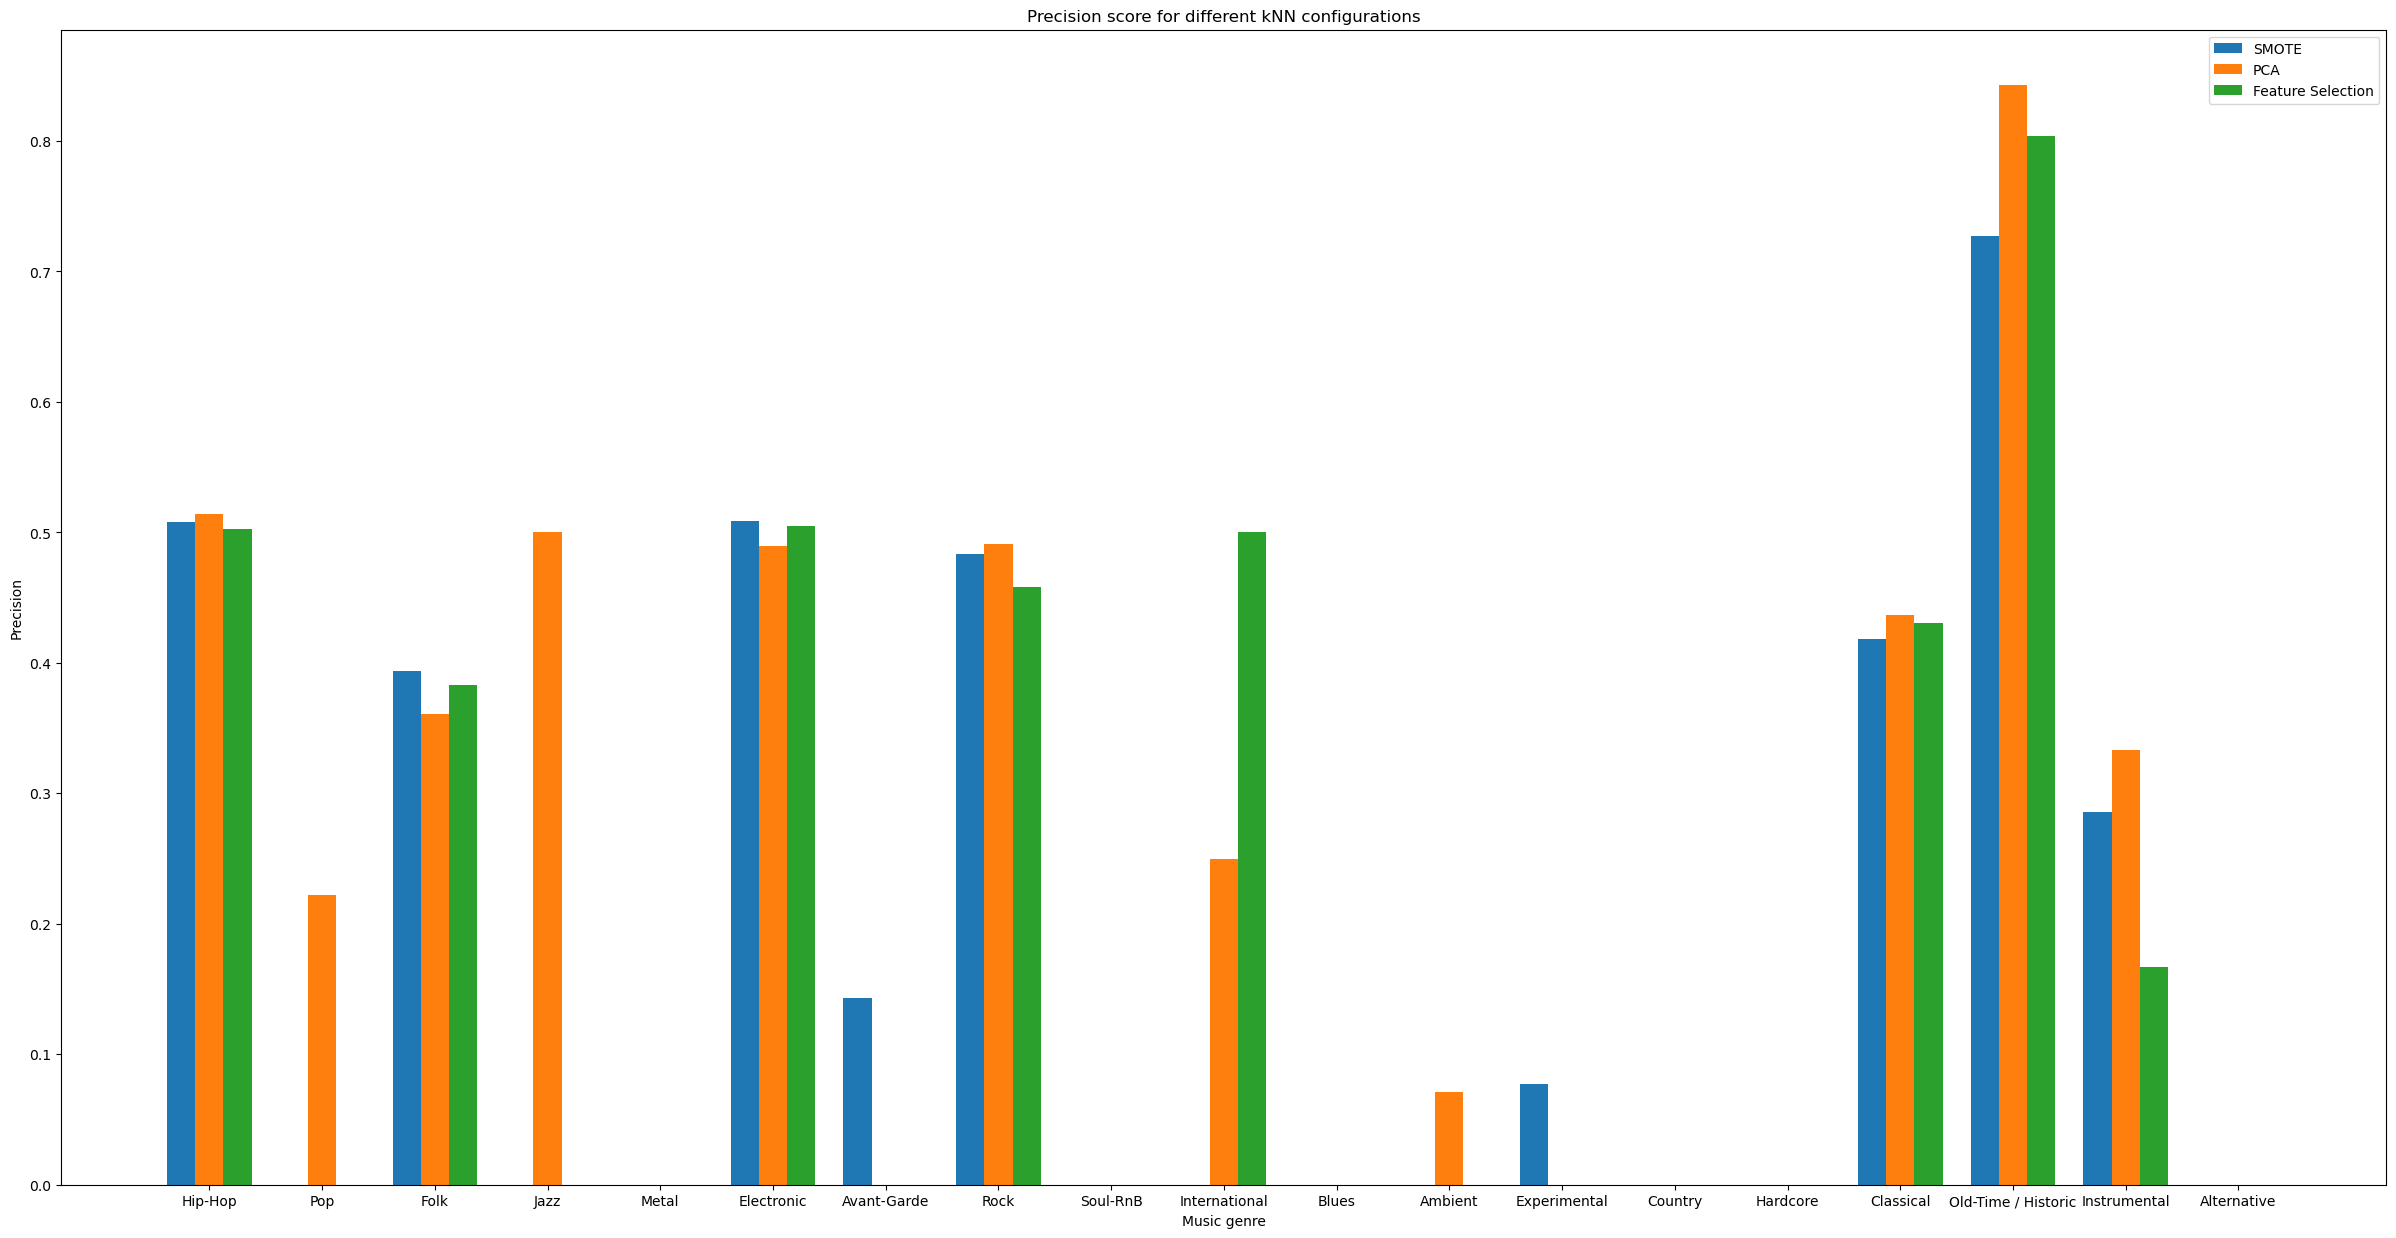

In [92]:
three_group_bar_plot(knn_precision_test, knn_precision_test_pca, knn_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different kNN configurations", "Music genre", 
                    "Precision", ["SMOTE"]+legend_test)

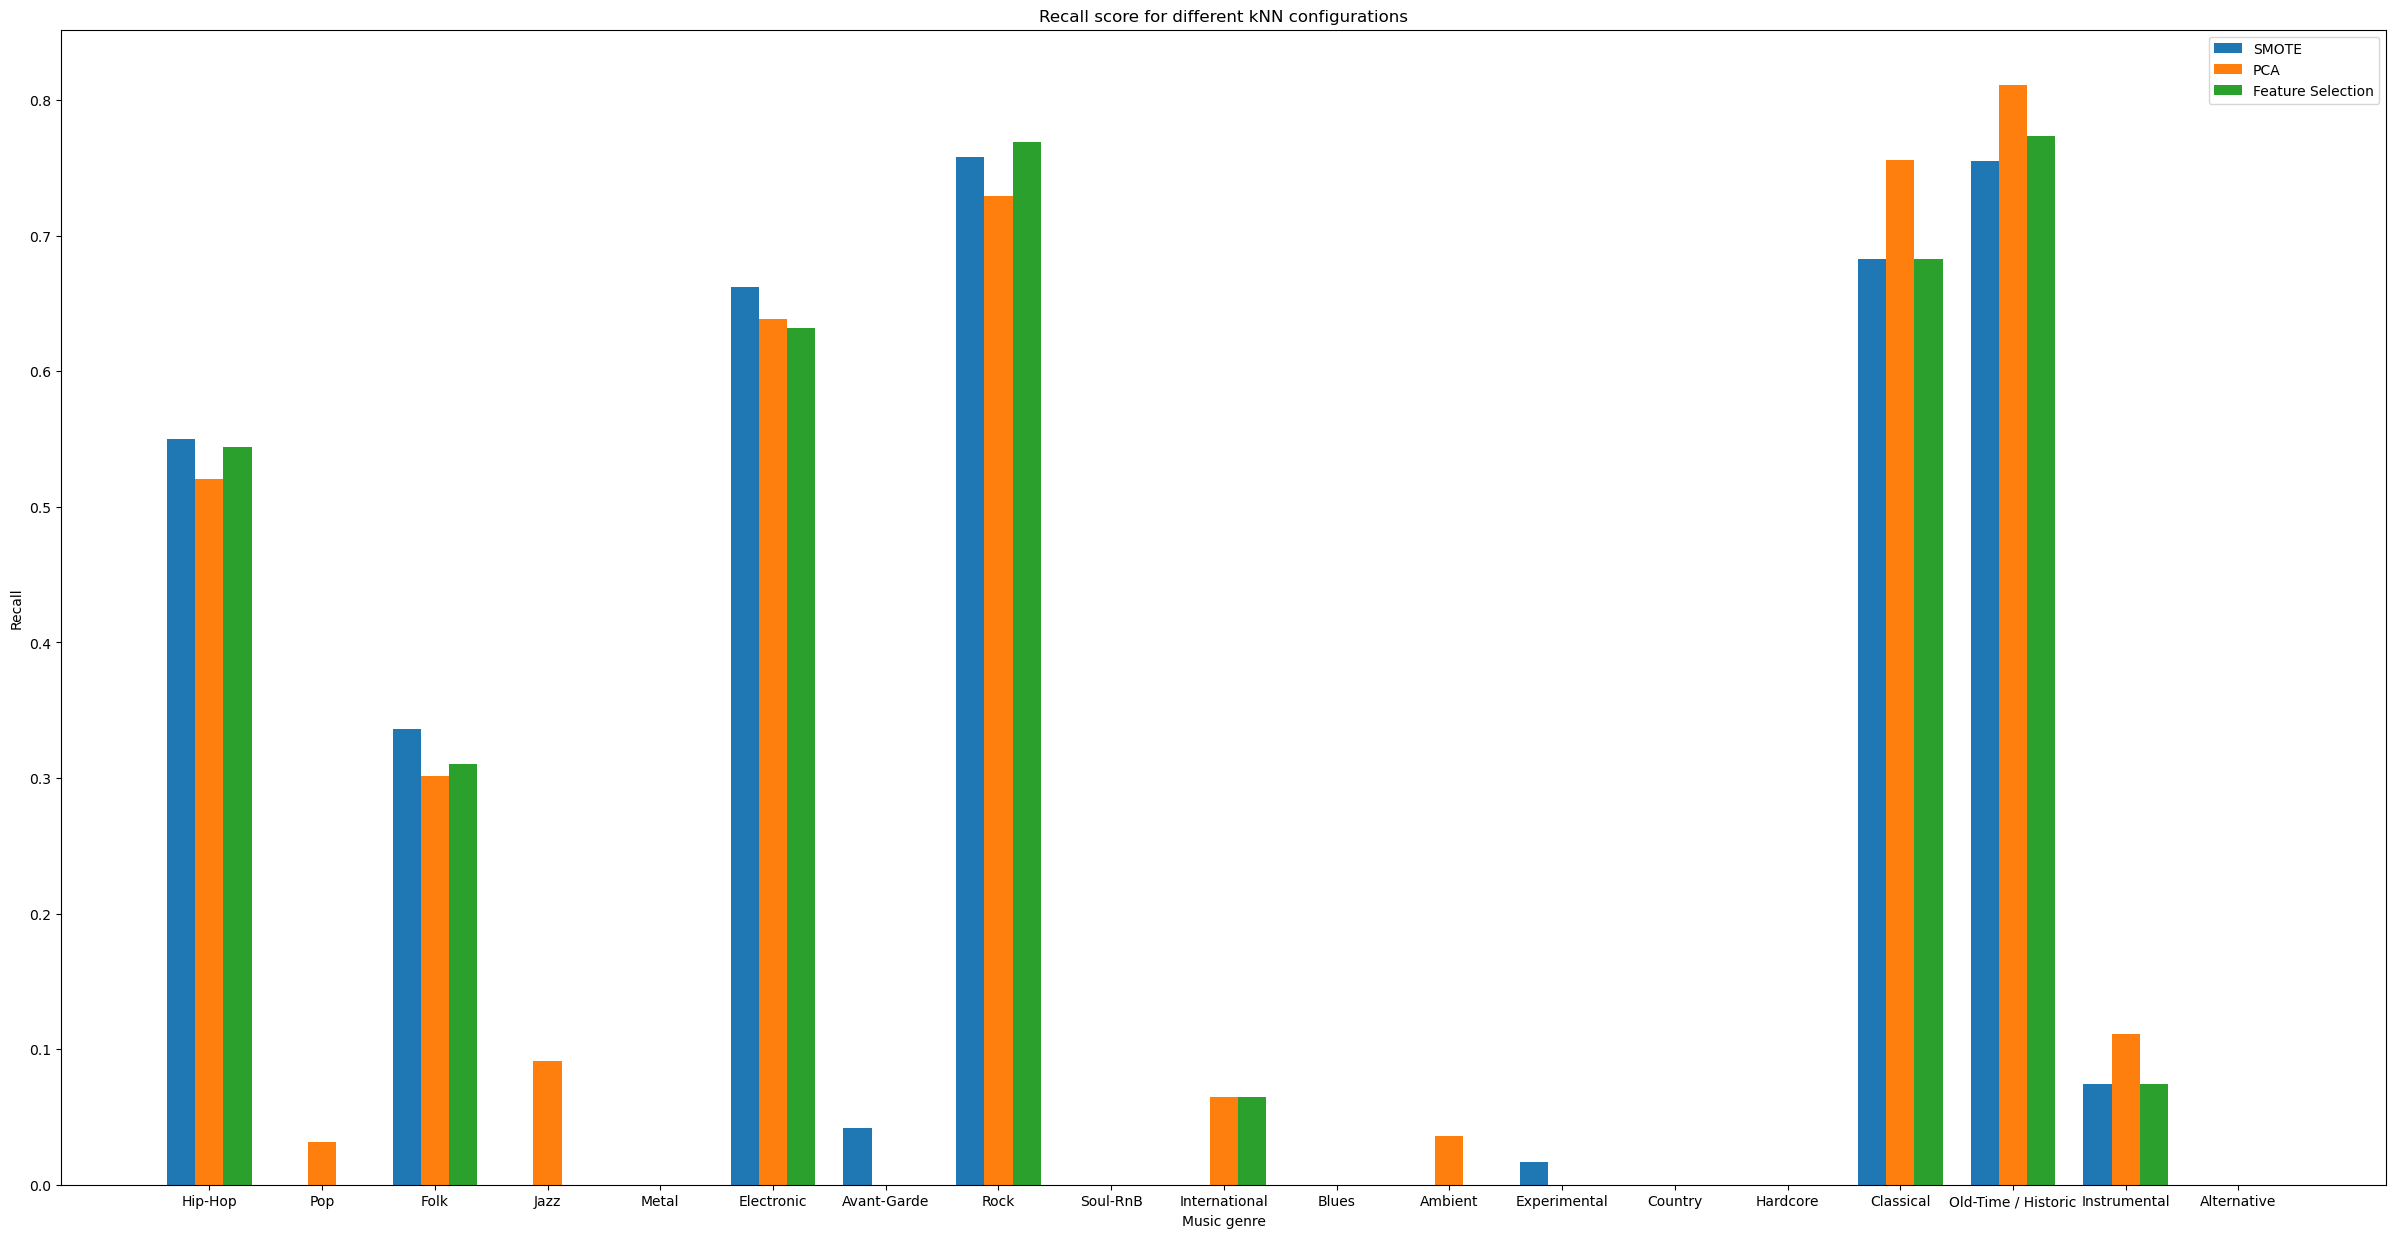

In [93]:
three_group_bar_plot(knn_recall_test, knn_recall_test_pca, knn_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different kNN configurations", "Music genre", 
                    "Recall", ["SMOTE"]+legend_test)

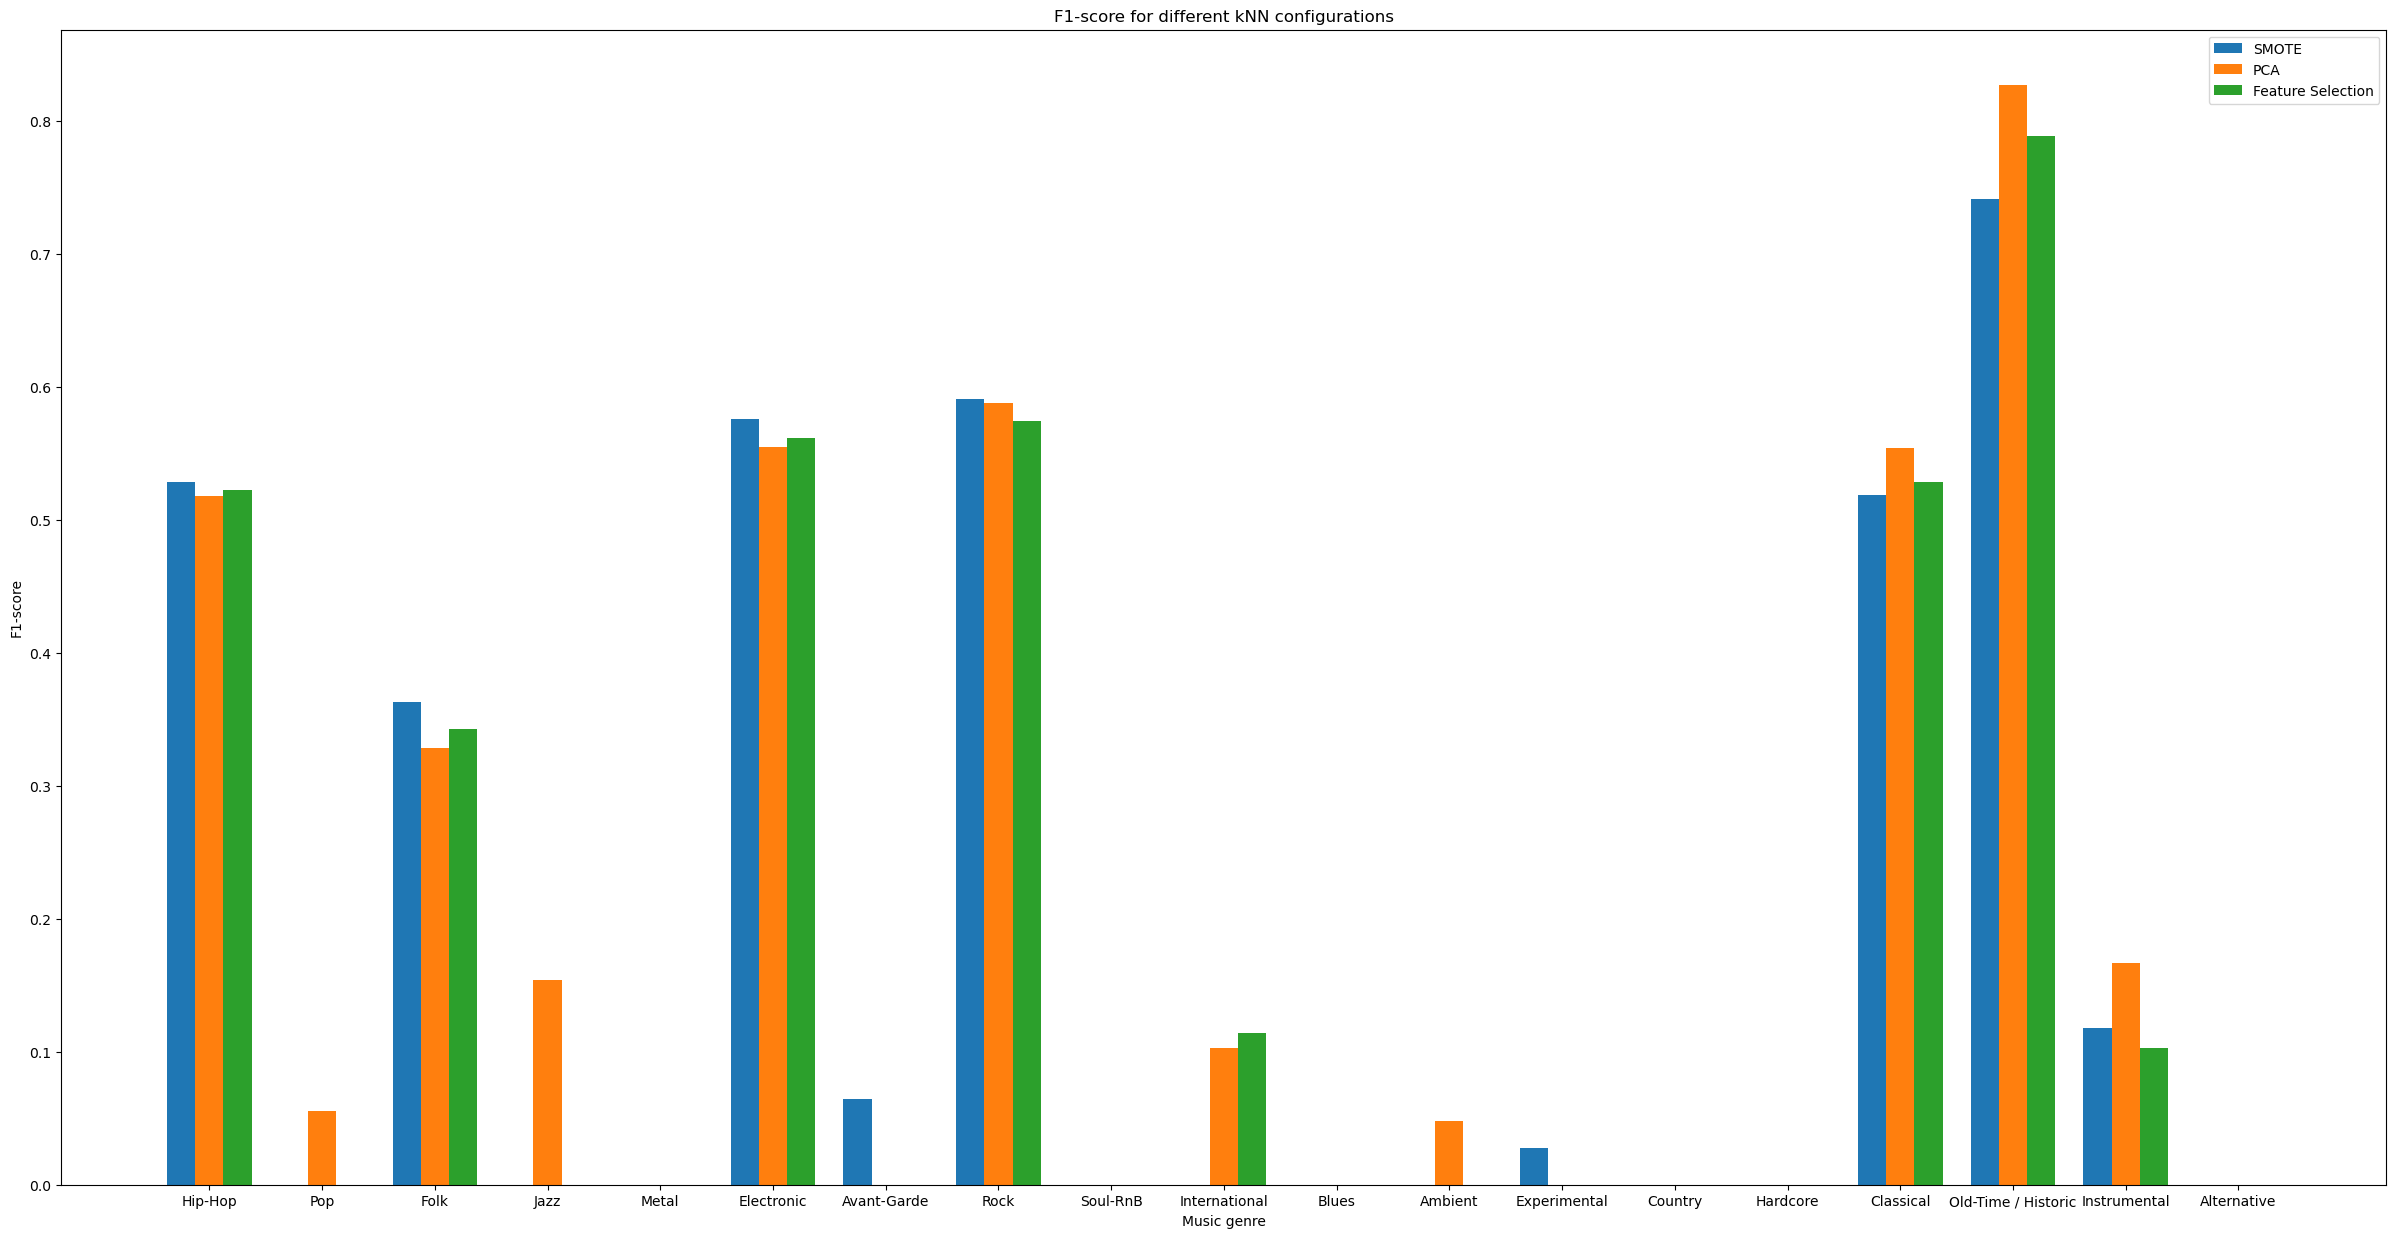

In [94]:
three_group_bar_plot(knn_f1_test, knn_f1_test_pca, knn_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different kNN configurations", "Music genre", 
                    "F1-score", ["SMOTE"]+legend_test)

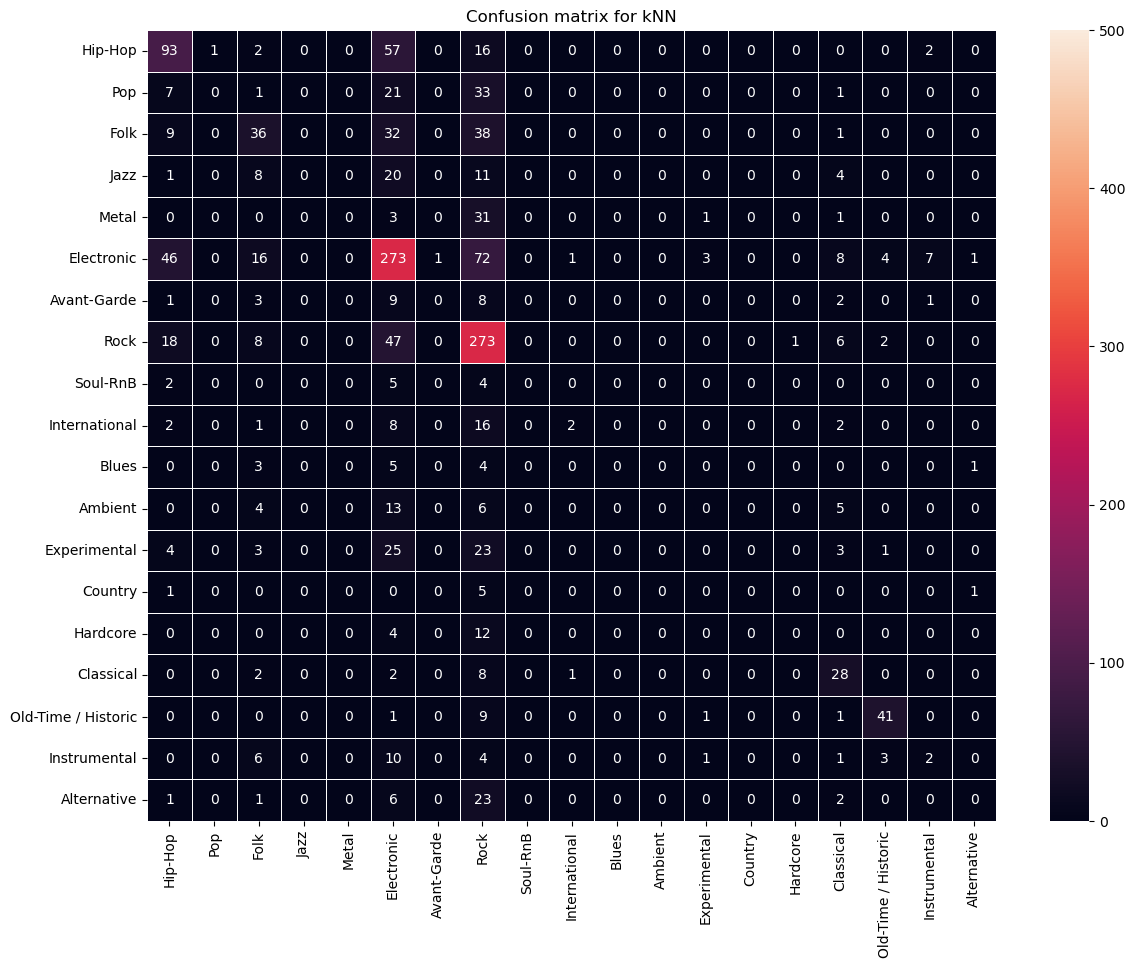

In [95]:
# Confusion matrix
knn_cm_test = confusion_matrix(y_test_fs, knn_test_preds_fs, labels=labels)
print_cm(knn_cm_test, orig_labels, "Confusion matrix for kNN")

## MLP classification

### MLP without tweaks

In [96]:
mlp_clf = MLPClassifier(solver='adam', alpha=plain['MLP']['alpha'], 
                        hidden_layer_sizes=(plain['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train, y_train)
mlp_val_predict = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results = compute_class_metrics(predictions=le.inverse_transform(mlp_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
mlp_report = mlp_results[0]
mlp_precision = mlp_results[1]
mlp_recall = mlp_results[2]
mlp_f1 = mlp_results[3]

### MLP with oversampling

In [97]:
mlp_clf = MLPClassifier(solver='adam', alpha=overs['MLP']['alpha'], 
                        hidden_layer_sizes=(overs['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_os, y_train_os)

mlp_val_predict_os = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results_os = compute_class_metrics(predictions=le.inverse_transform(mlp_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))
mlp_report_os = mlp_results_os[0]
mlp_precision_os = mlp_results_os[1]
mlp_recall_os = mlp_results_os[2]
mlp_f1_os = mlp_results_os[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### MLP with SMOTE

In [98]:
mlp_clf = MLPClassifier(solver='adam', alpha=smote['MLP']['alpha'], 
                        hidden_layer_sizes=(smote['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_smote, y_train_smote)

mlp_val_predict_smote = cross_val_predict(mlp_clf, X_validate, y_validate, cv=5)

mlp_results_smote = compute_class_metrics(
    predictions=le.inverse_transform(mlp_val_predict_smote), 
    y_set=le.inverse_transform(y_validate), 
    labels=le.inverse_transform(labels))

mlp_report_smote = mlp_results_smote[0]
mlp_precision_smote = mlp_results_smote[1]
mlp_recall_smote = mlp_results_smote[2]
mlp_f1_smote = mlp_results_smote[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Metrics comparison for MLP

In [99]:
print_acc_table(mlp_results[4])

Metric     Score
0  Accuracy  0.346866

In [100]:
print("----------------------------- MLP Metrics without tweaks -----------------------------")
mlp_report

----------------------------- MLP Metrics without tweaks -----------------------------


precision    recall  f1-score  support
Hip-Hop               0.421488  0.322785  0.365591      158
Pop                   0.081633  0.078431  0.080000       51
Folk                  0.186916  0.210526  0.198020       95
Jazz                  0.083333  0.057143  0.067797       35
Metal                 0.065217  0.142857  0.089552       21
Electronic            0.483146  0.433249  0.456839      397
Avant-Garde           0.083333  0.103448  0.092308       29
Rock                  0.449878  0.508287  0.477302      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.222222  0.153846  0.181818       13
Experimental          0.080000  0.062500  0.070175       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.468085  0.611111  0.530120       36
Old-Time / Historic   0.486486  0.473684  0.480000       38
Instrumental          0.054054  0.111111  0.072727       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.166621  0.172052  0.166434     1404
weighted avg          0.351996  0.346866  0.347025     1404

In [101]:
print_acc_table(mlp_results_os[4])

Metric     Score
0  Accuracy  0.312678

In [102]:
print("--------------------------- MLP Metrics with oversampling ---------------------------")
mlp_report_os

--------------------------- MLP Metrics with oversampling ---------------------------


precision    recall  f1-score  support
Hip-Hop               0.375000  0.360759  0.367742      158
Pop                   0.036765  0.098039  0.053476       51
Folk                  0.232323  0.242105  0.237113       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.475694  0.345088  0.400000      397
Avant-Garde           0.000000  0.000000  0.000000       29
Rock                  0.455331  0.436464  0.445698      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.100000  0.076923  0.086957       13
Experimental          0.153846  0.125000  0.137931       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.105263  0.166667  0.129032       12
Classical             0.583333  0.583333  0.583333       36
Old-Time / Historic   0.615385  0.631579  0.623377       38
Instrumental          0.037037  0.111111  0.055556       18
Alternative           0.021739  0.037037  0.027397       27
macro avg             0.167985  0.169163  0.165664     1404
weighted avg          0.352510  0.312678  0.328656     1404

In [104]:
print_acc_table(mlp_results_smote[4])

Metric     Score
0  Accuracy  0.355413

In [105]:
print("------------------------------ MLP Metrics with SMOTE ------------------------------")
mlp_report_smote

------------------------------ MLP Metrics with SMOTE ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.347594  0.411392  0.376812      158
Pop                   0.072727  0.078431  0.075472       51
Folk                  0.264368  0.242105  0.252747       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.501873  0.337531  0.403614      397
Avant-Garde           0.000000  0.000000  0.000000       29
Rock                  0.453061  0.613260  0.521127      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.118421  0.140625  0.128571       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.071429  0.083333  0.076923       12
Classical             0.517241  0.416667  0.461538       36
Old-Time / Historic   0.600000  0.631579  0.615385       38
Instrumental          0.105263  0.111111  0.108108       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.160630  0.161370  0.158963     1404
weighted avg          0.355233  0.355413  0.347134     1404

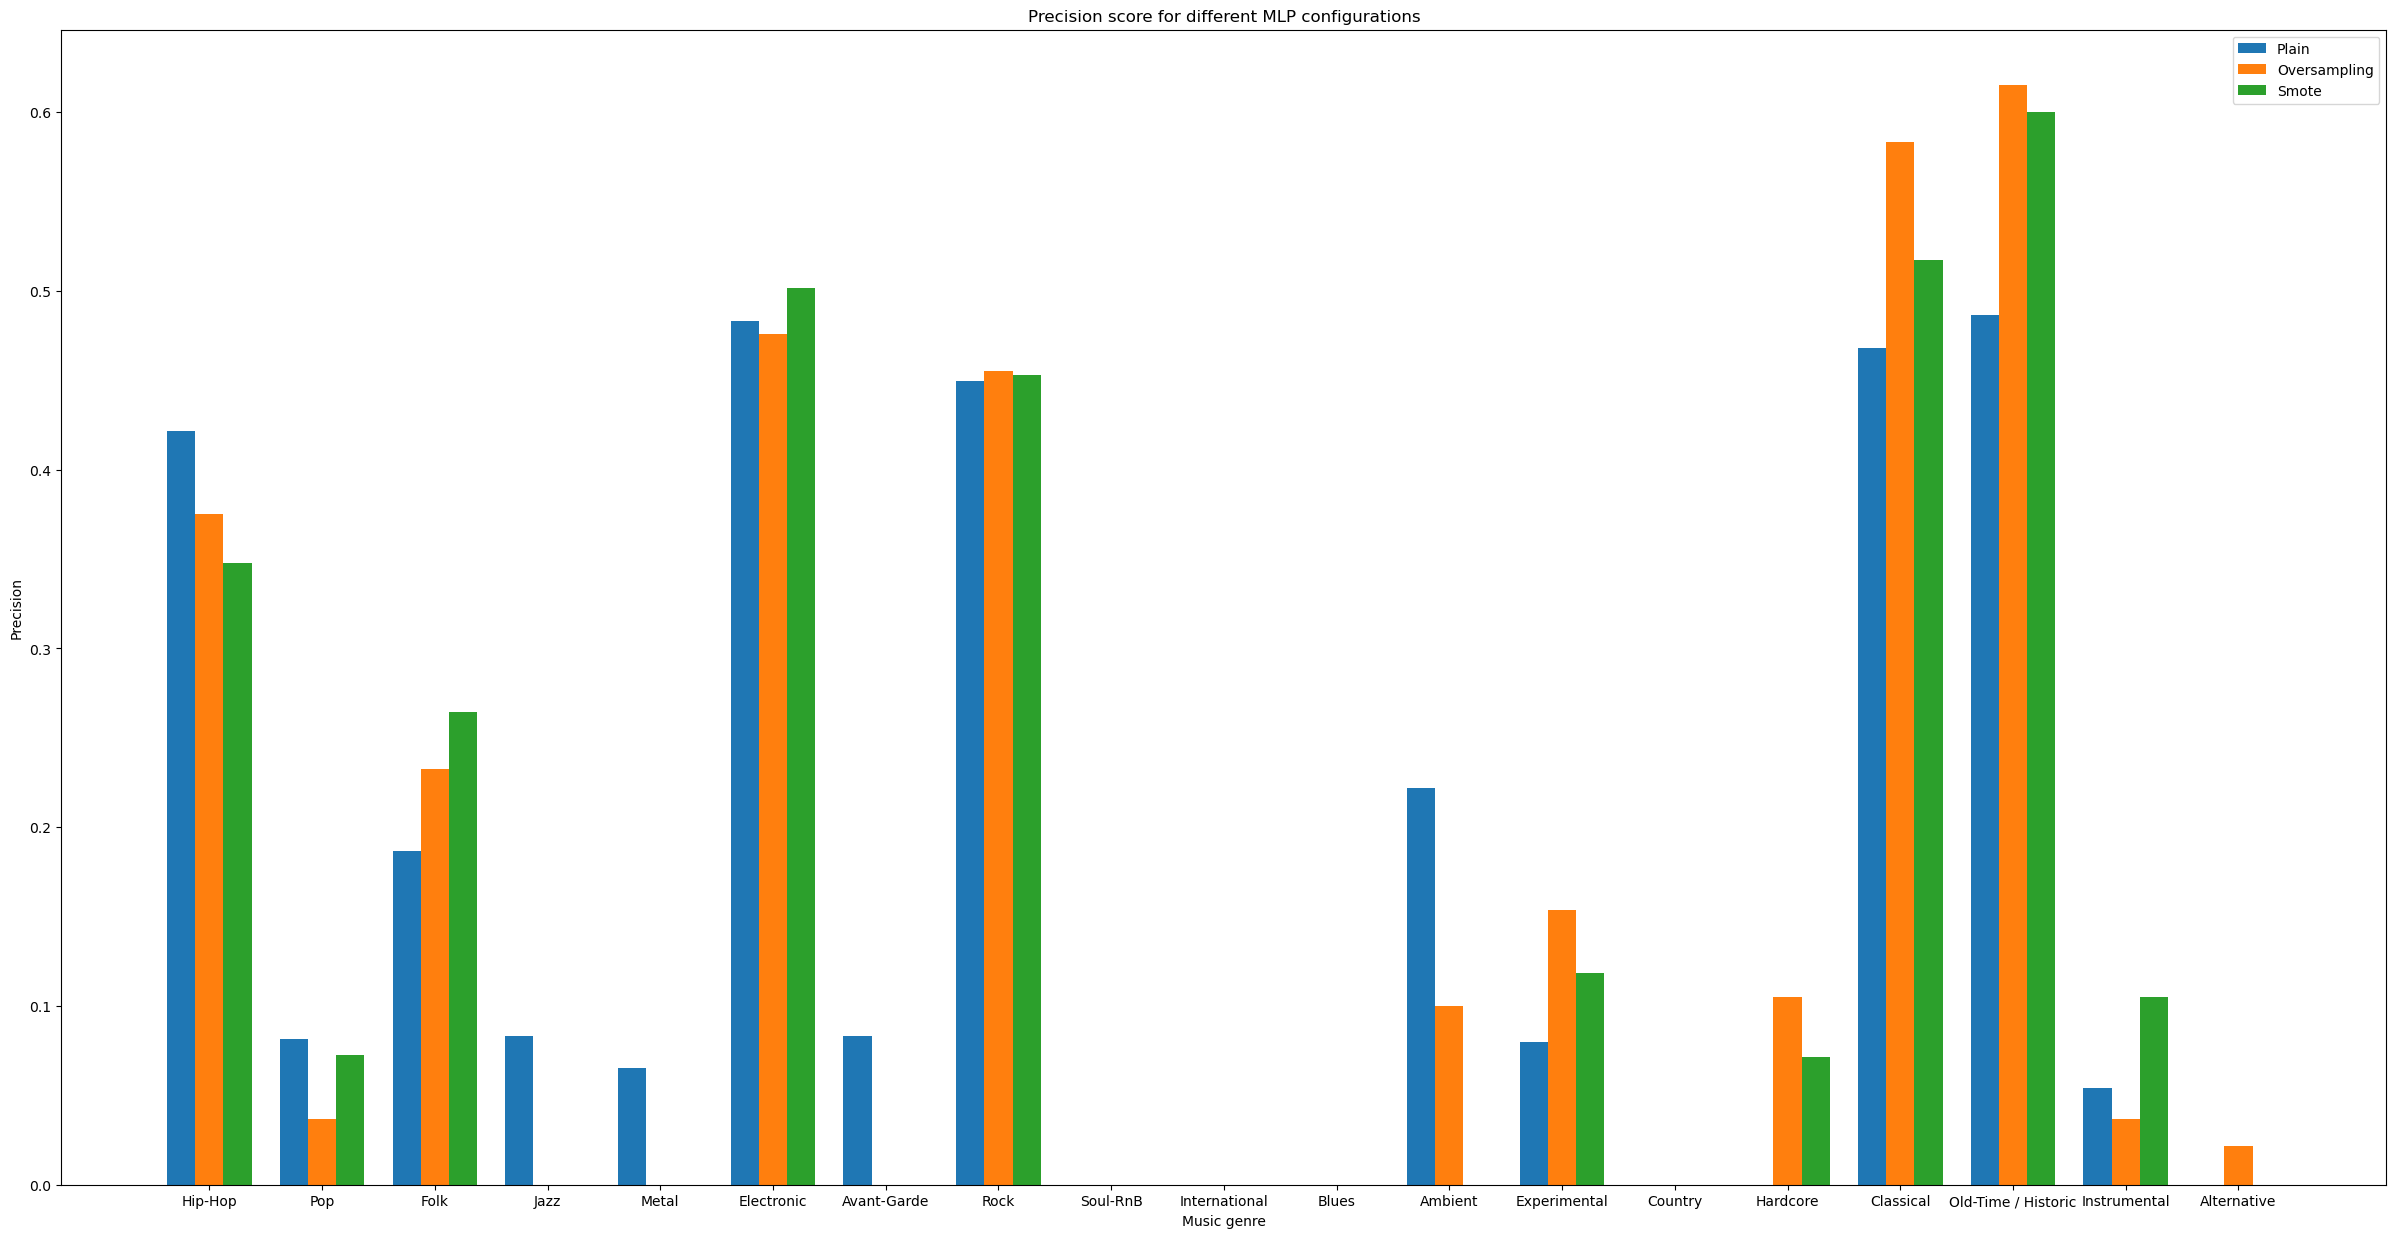

In [106]:
three_group_bar_plot(mlp_precision, mlp_precision_os, mlp_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different MLP configurations", "Music genre", 
                    "Precision", legend_validation)

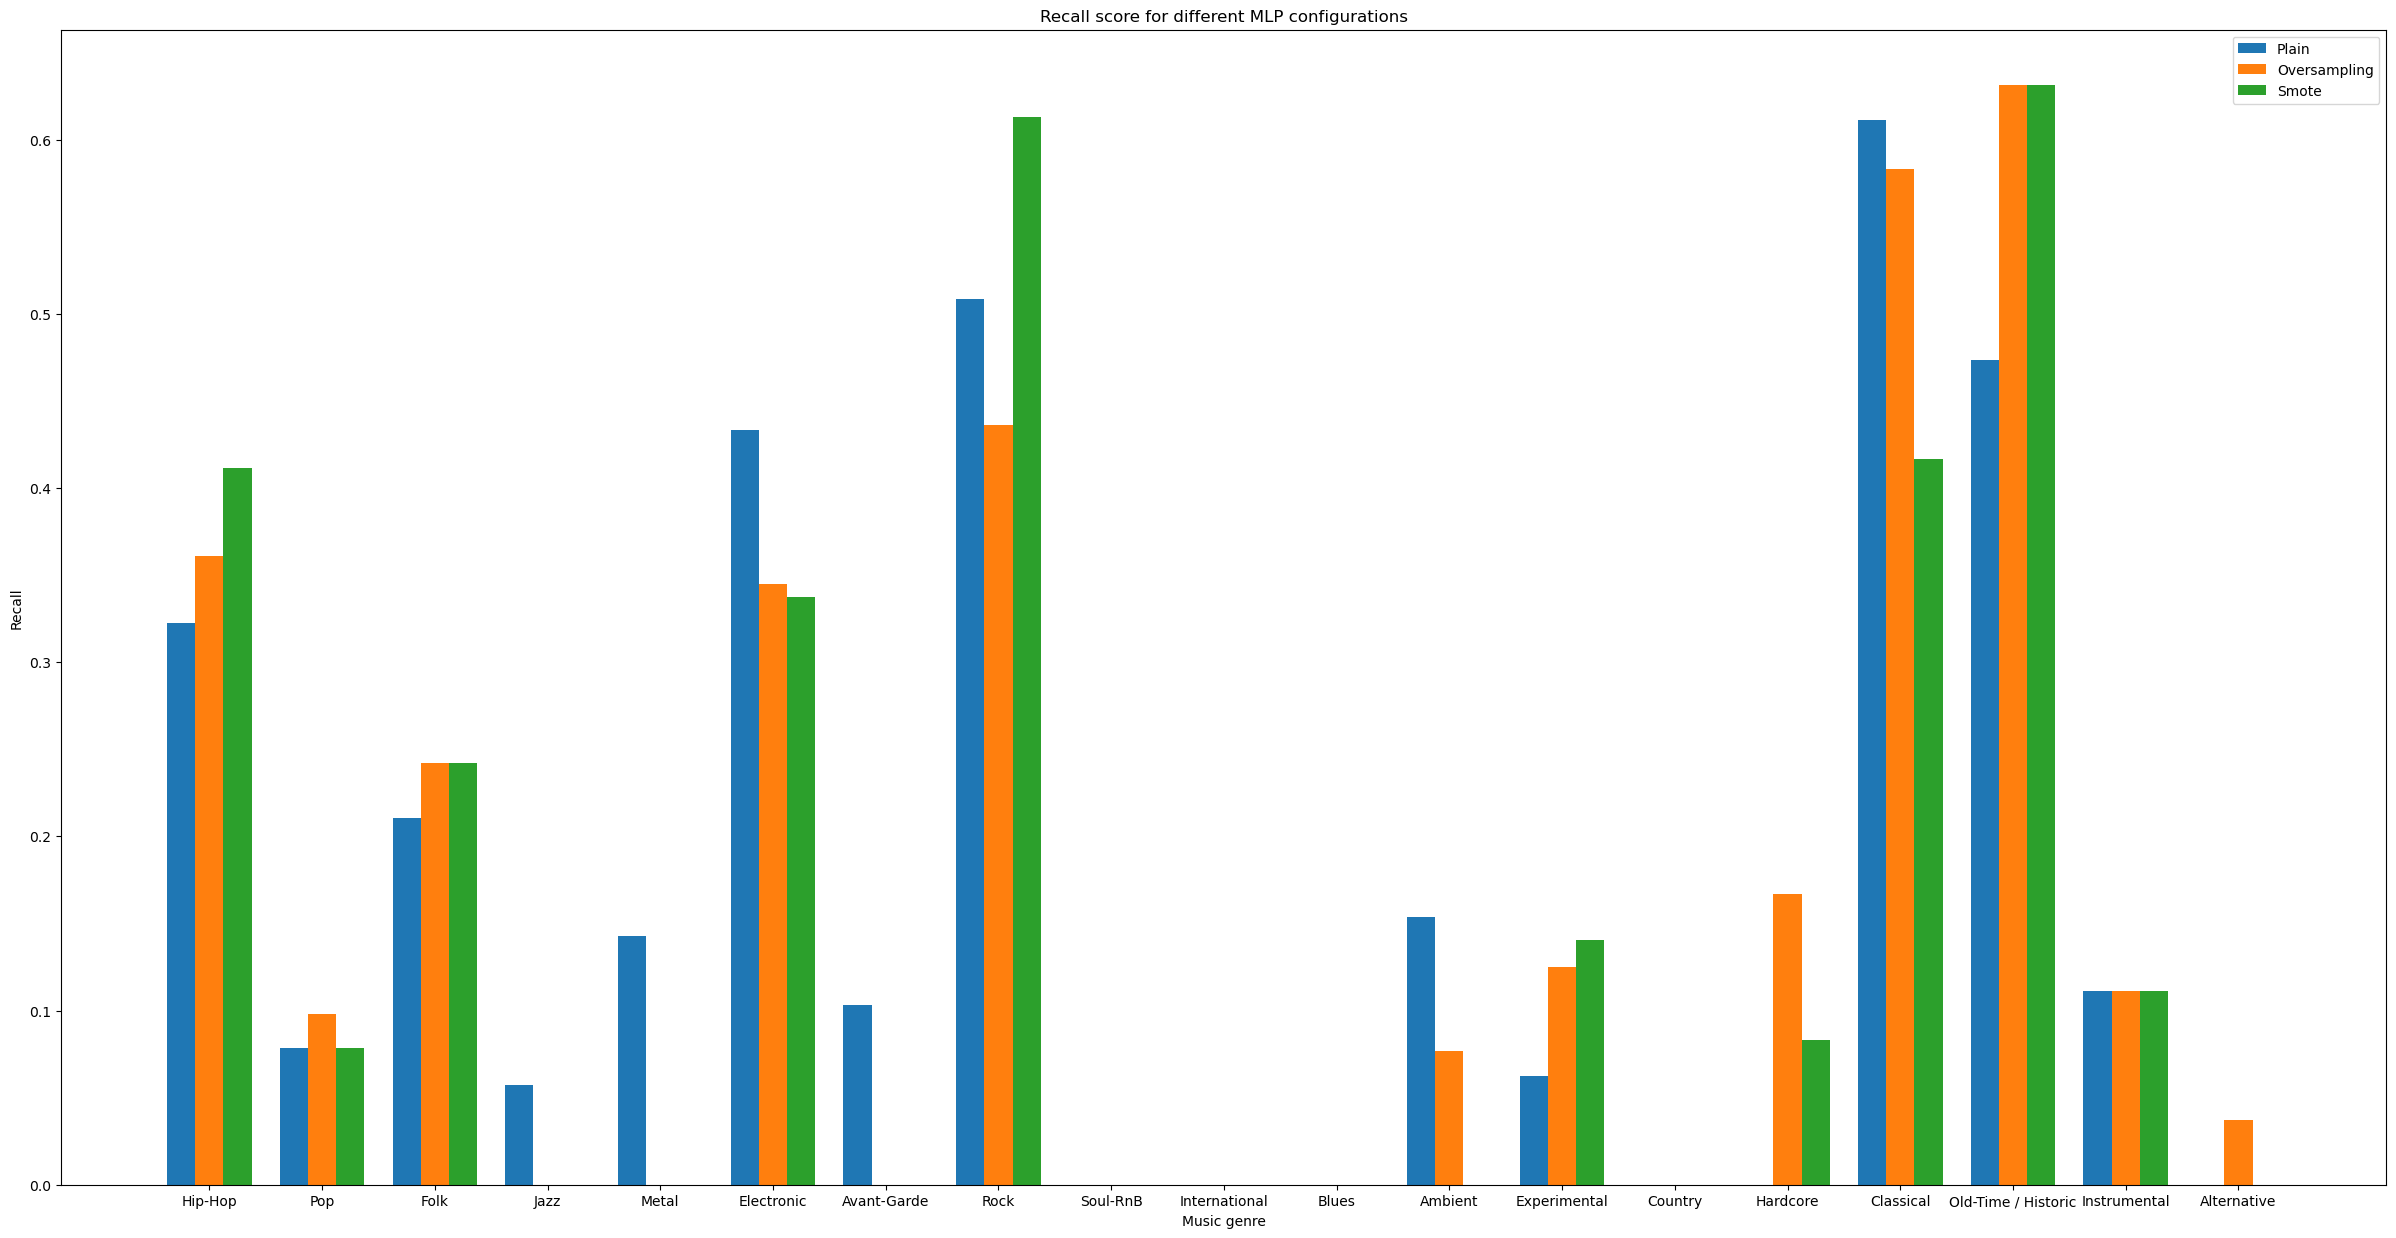

In [107]:
three_group_bar_plot(mlp_recall, mlp_recall_os, mlp_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different MLP configurations", "Music genre", 
                    "Recall", legend_validation)

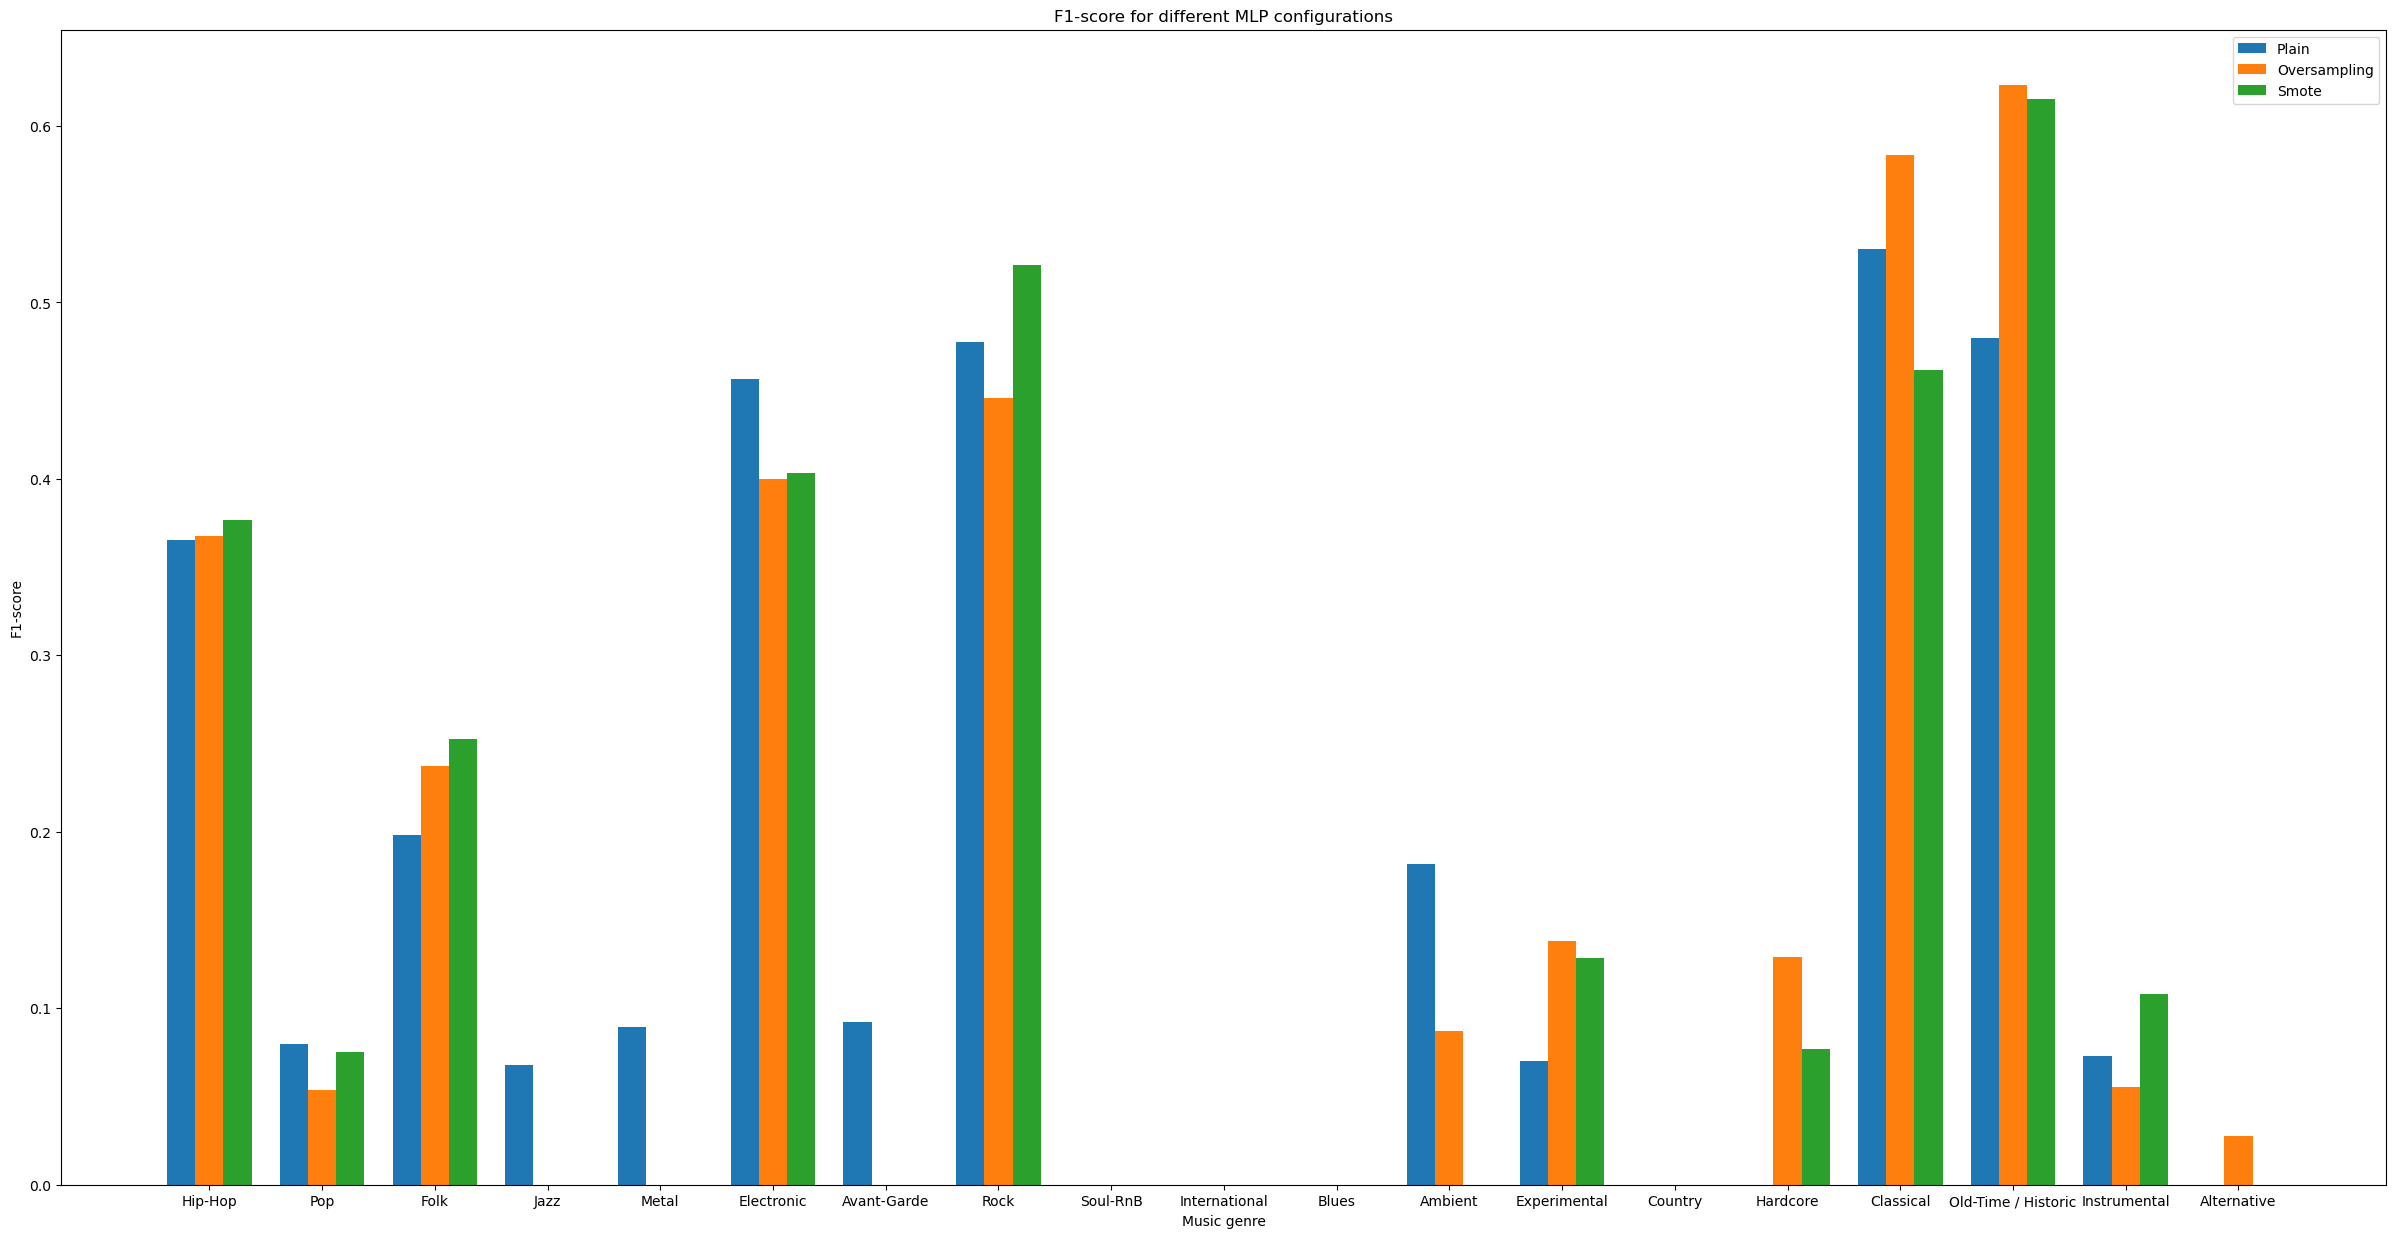

In [108]:
three_group_bar_plot(mlp_f1, mlp_f1_os, mlp_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different MLP configurations", "Music genre", 
                    "F1-score", legend_validation)

### MLP on test set
Best case: SMOTE

In [17]:
orig_labels = le.inverse_transform(labels)
    
mlp_clf = MLPClassifier(solver='adam', alpha=smote['MLP']['alpha'], 
                        hidden_layer_sizes=(smote['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_smote, y_train_smote)

mlp_test_preds = mlp_clf.predict(X_test)
mlp_results_test = compute_class_metrics(
    predictions=le.inverse_transform(mlp_test_preds), 
    y_set=le.inverse_transform(y_test), 
    labels=orig_labels
)

mlp_report_test = mlp_results_test[0]
mlp_precision_test = mlp_results_test[1]
mlp_recall_test = mlp_results_test[2]
mlp_f1_test = mlp_results_test[3]

In [19]:
pca = PCA(n_components=smote_pca['MLP']['n_components'])
X_train_pca = pca.fit_transform(X_train_smote, y_train_smote)
X_test_pca = pca.transform(X_test)

mlp_clf = MLPClassifier(solver='adam', alpha=smote_pca['MLP']['alpha'], 
                        hidden_layer_sizes=(smote_pca['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_pca, y_train_smote)

mlp_test_preds_pca = mlp_clf.predict(X_test_pca)
mlp_results_test_pca = compute_class_metrics(
    predictions=le.inverse_transform(mlp_test_preds_pca), 
    y_set=le.inverse_transform(y_test), 
    labels=orig_labels
)

mlp_report_test_pca = mlp_results_test_pca[0]
mlp_precision_test_pca = mlp_results_test_pca[1]
mlp_recall_test_pca = mlp_results_test_pca[2]
mlp_f1_test_pca = mlp_results_test_pca[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [111]:
mlp_clf = MLPClassifier(solver='adam', alpha=smote['MLP']['alpha'], 
                        hidden_layer_sizes=(smote['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_smote_fs, y_train_smote_fs)

mlp_test_preds_fs = mlp_clf.predict(X_test_fs)
mlp_results_test_fs = compute_class_metrics(
    predictions=le.inverse_transform(mlp_test_preds_fs), 
    y_set=le.inverse_transform(y_test_fs), 
    labels=orig_labels
)

mlp_report_test_fs = mlp_results_test_fs[0]
mlp_precision_test_fs = mlp_results_test_fs[1]
mlp_recall_test_fs = mlp_results_test_fs[2]
mlp_f1_test_fs = mlp_results_test_fs[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [112]:
print_acc_table(mlp_results_test[4])

Metric     Score
0  Accuracy  0.365385

In [113]:
print("-------------------------- MLP Metrics on test set (SMOTE) ----------------------------")
mlp_report_test

-------------------------- MLP Metrics on test set (SMOTE) ----------------------------


precision    recall  f1-score  support
Hip-Hop               0.464151  0.719298  0.564220      171
Pop                   0.037037  0.031746  0.034188       63
Folk                  0.595745  0.482759  0.533333      116
Jazz                  0.125000  0.136364  0.130435       44
Metal                 0.197802  0.500000  0.283465       36
Electronic            0.611111  0.356481  0.450292      432
Avant-Garde           0.073171  0.125000  0.092308       24
Rock                  0.609756  0.211268  0.313808      355
Soul-RnB              0.049020  0.454545  0.088496       11
International         0.215686  0.354839  0.268293       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.159091  0.250000  0.194444       28
Experimental          0.125000  0.067797  0.087912       59
Country               0.072464  0.714286  0.131579        7
Hardcore              0.200000  0.250000  0.222222       16
Classical             0.548387  0.829268  0.660194       41
Old-Time / Historic   0.940000  0.886792  0.912621       53
Instrumental          0.205128  0.296296  0.242424       27
Alternative           0.123077  0.242424  0.163265       33
macro avg             0.281665  0.363640  0.282816     1560
weighted avg          0.480972  0.365385  0.382281     1560

In [114]:
print_acc_table(mlp_results_test_pca[4])

Metric     Score
0  Accuracy  0.425641

In [115]:
print("---------------------- MLP Metrics on test set with SMOTE (PCA) ------------------------")
mlp_report_test_pca

---------------------- MLP Metrics on test set with SMOTE (PCA) ------------------------


precision    recall  f1-score  support
Hip-Hop               0.534694  0.766082  0.629808      171
Pop                   0.120000  0.047619  0.068182       63
Folk                  0.558824  0.491379  0.522936      116
Jazz                  0.155556  0.159091  0.157303       44
Metal                 0.133333  0.222222  0.166667       36
Electronic            0.688372  0.342593  0.457496      432
Avant-Garde           0.033898  0.083333  0.048193       24
Rock                  0.646154  0.473239  0.546341      355
Soul-RnB              0.104167  0.454545  0.169492       11
International         0.209677  0.419355  0.279570       31
Blues                 0.035714  0.076923  0.048780       13
Ambient               0.174603  0.392857  0.241758       28
Experimental          0.138889  0.084746  0.105263       59
Country               0.061224  0.428571  0.107143        7
Hardcore              0.097561  0.250000  0.140351       16
Classical             0.546875  0.853659  0.666667       41
Old-Time / Historic   0.901961  0.867925  0.884615       53
Instrumental          0.245283  0.481481  0.325000       27
Alternative           0.074074  0.121212  0.091954       33
macro avg             0.287414  0.369307  0.297764     1560
weighted avg          0.516353  0.425641  0.443262     1560

In [116]:
print_acc_table(mlp_results_test_fs[4])

Metric     Score
0  Accuracy  0.307692

In [117]:
print("-------------------- MLP Metrics on test set with SMOTE (fs) ----------------------")
mlp_report_test_fs

-------------------- MLP Metrics on test set with SMOTE (fs) ----------------------


precision    recall  f1-score  support
Hip-Hop               0.640351  0.426901  0.512281      171
Pop                   0.000000  0.000000  0.000000       63
Folk                  0.562500  0.387931  0.459184      116
Jazz                  0.089655  0.295455  0.137566       44
Metal                 0.132911  0.583333  0.216495       36
Electronic            0.828283  0.189815  0.308851      432
Avant-Garde           0.111111  0.041667  0.060606       24
Rock                  0.453287  0.369014  0.406832      355
Soul-RnB              0.033058  0.363636  0.060606       11
International         0.163934  0.322581  0.217391       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.090909  0.250000  0.133333       28
Experimental          0.071429  0.067797  0.069565       59
Country               0.032258  0.428571  0.060000        7
Hardcore              0.066667  0.062500  0.064516       16
Classical             0.535714  0.731707  0.618557       41
Old-Time / Historic   0.641026  0.943396  0.763359       53
Instrumental          0.137931  0.148148  0.142857       27
Alternative           0.040000  0.030303  0.034483       33
macro avg             0.243738  0.296987  0.224552     1560
weighted avg          0.499591  0.307692  0.334311     1560

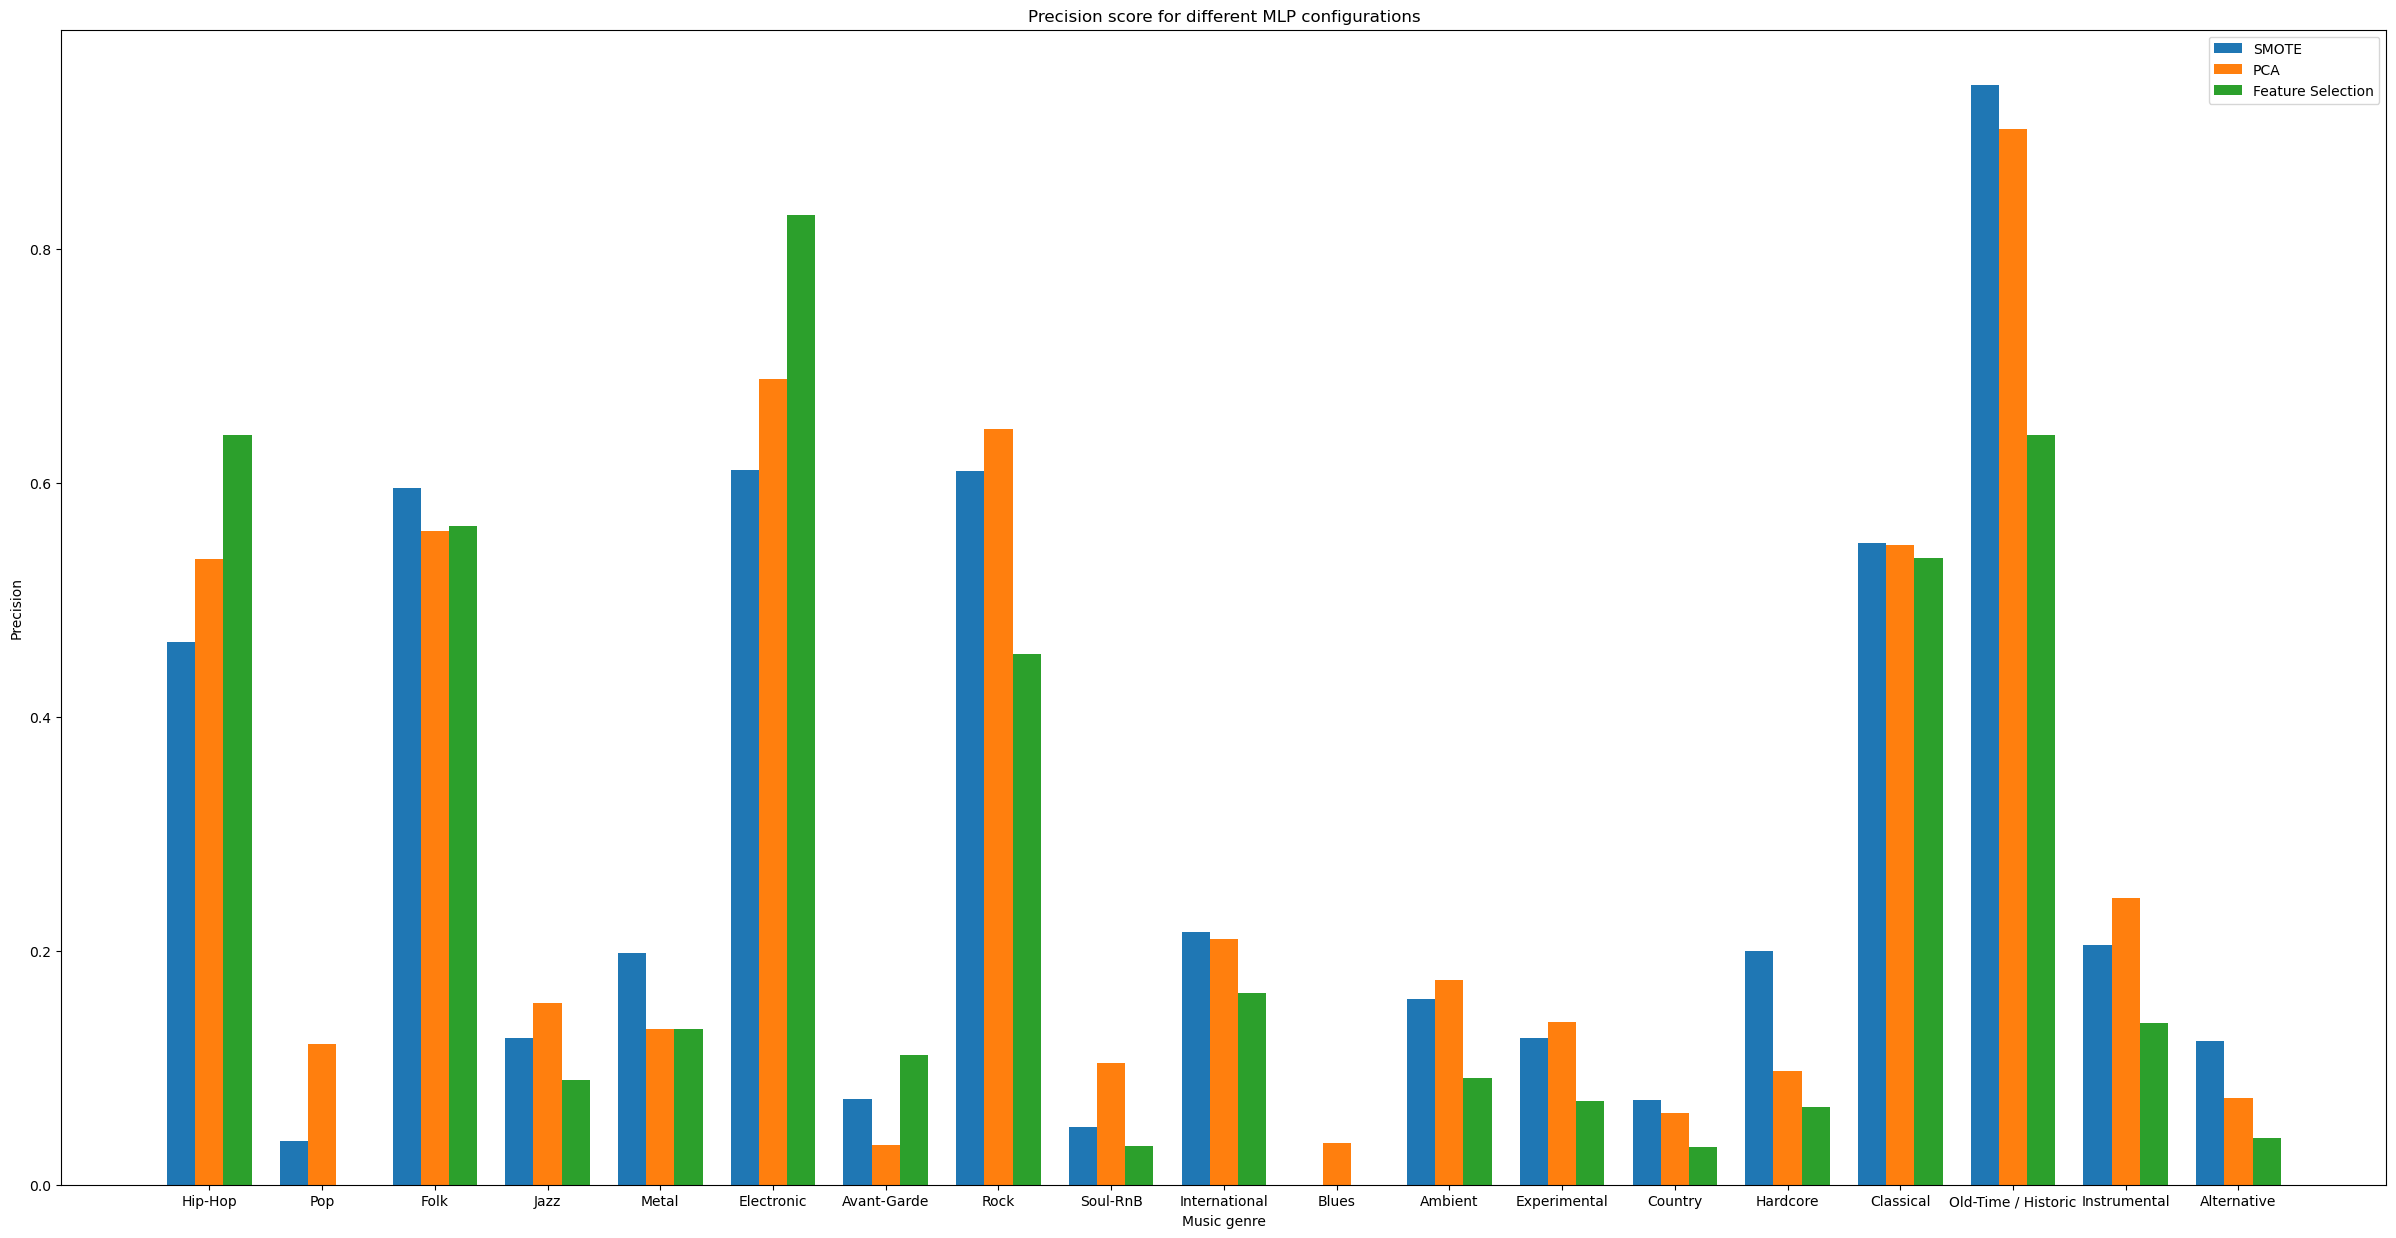

In [118]:
three_group_bar_plot(mlp_precision_test, mlp_precision_test_pca, mlp_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different MLP configurations", "Music genre", 
                    "Precision", ["SMOTE"]+legend_test)

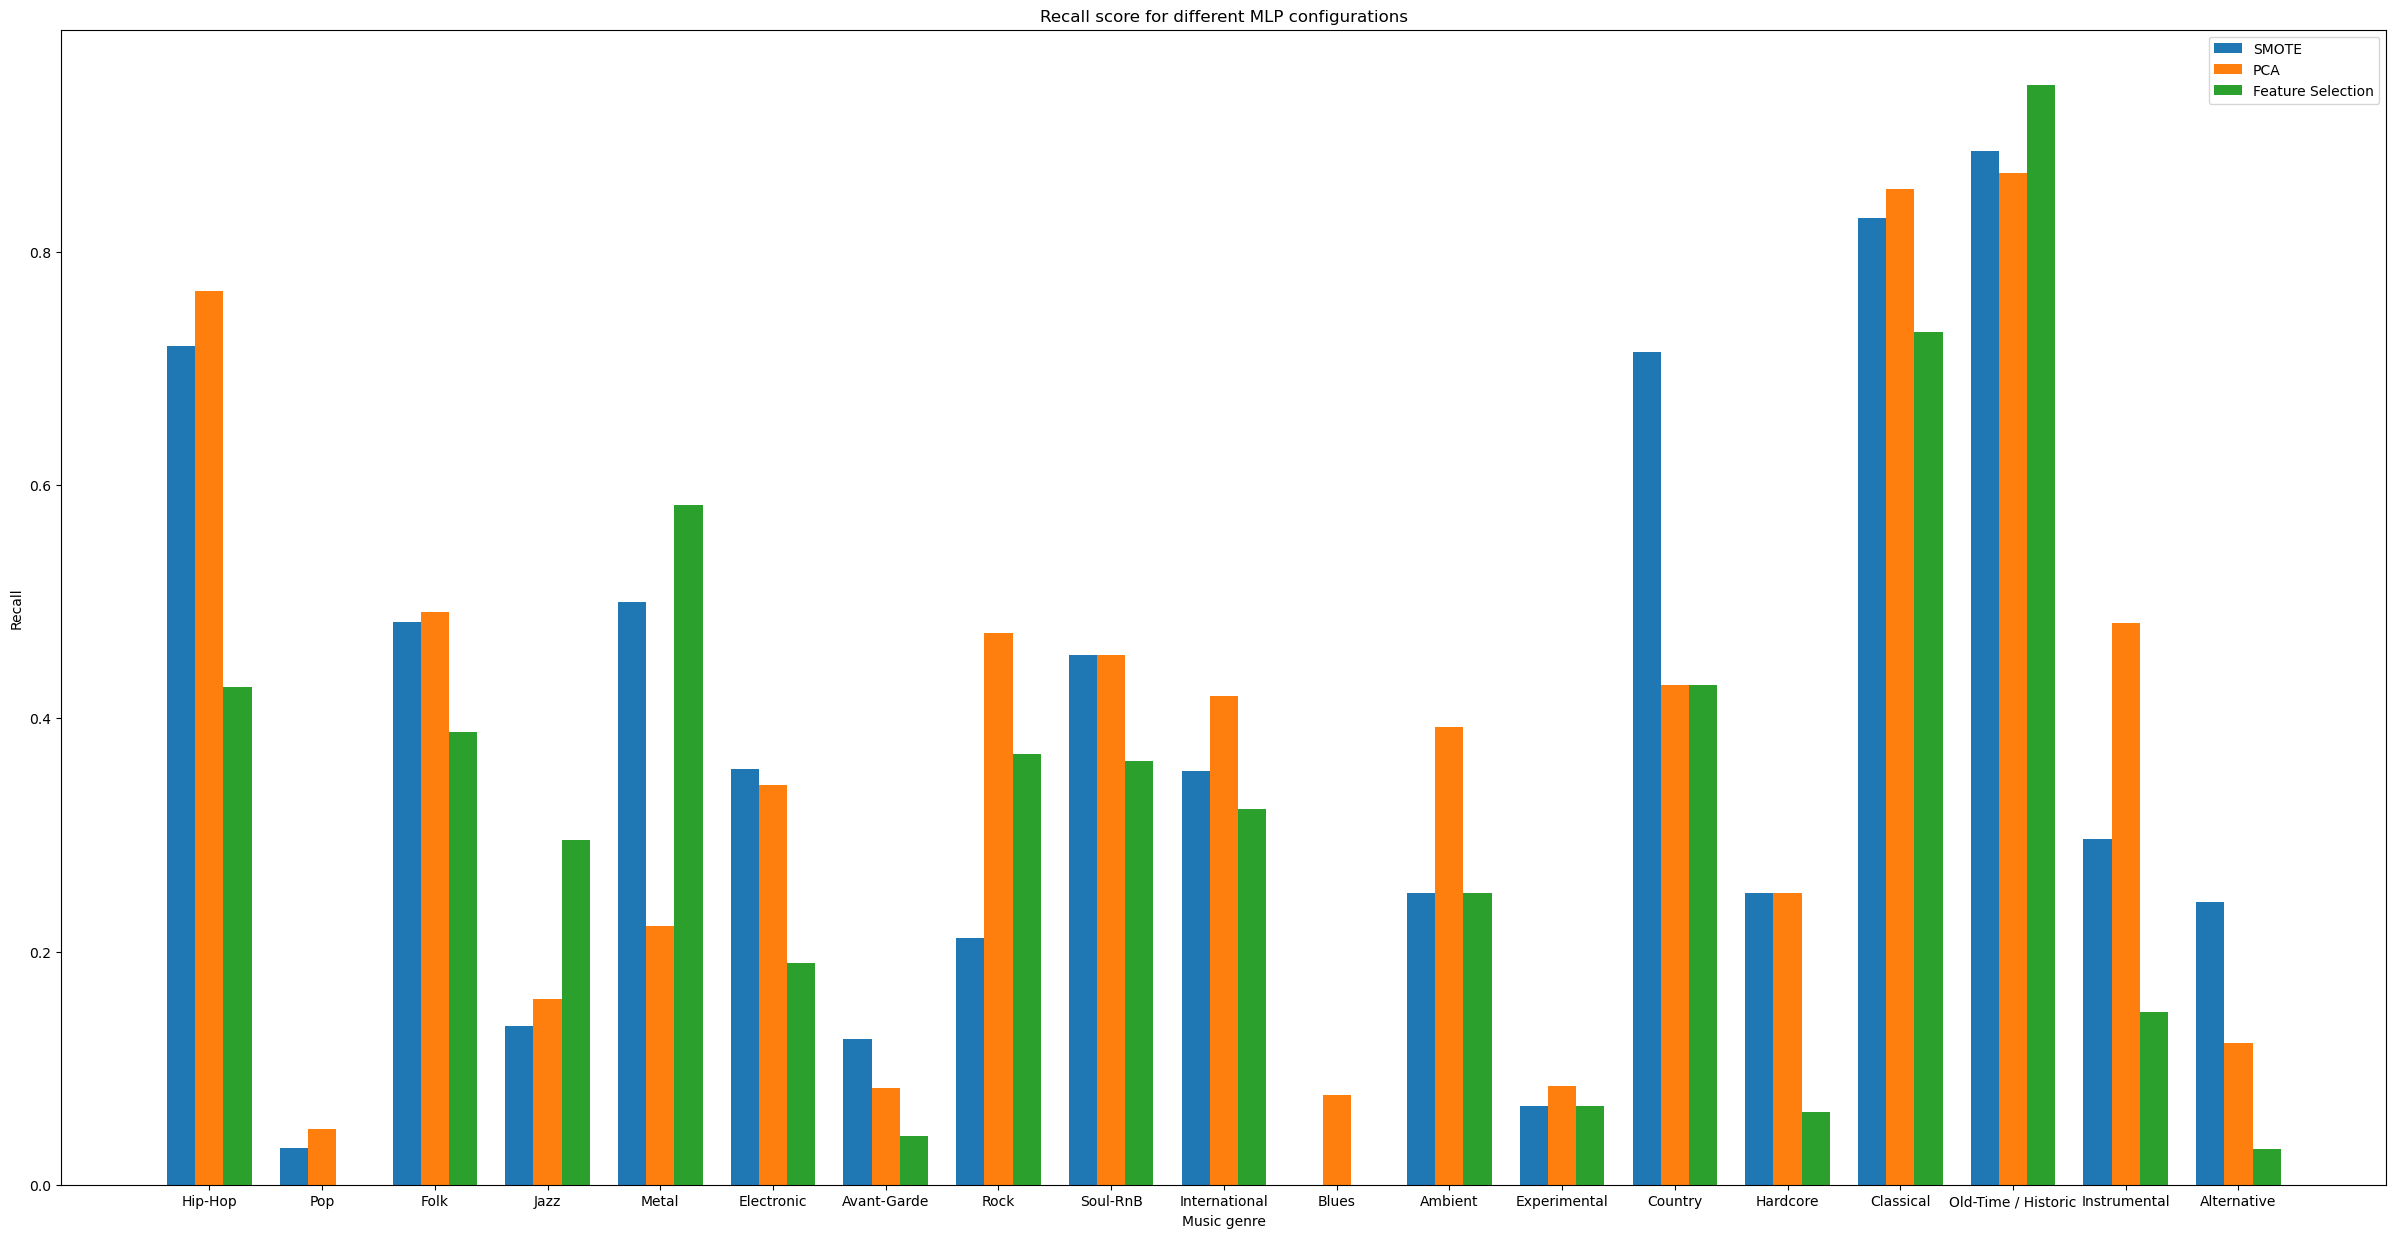

In [119]:
three_group_bar_plot(mlp_recall_test, mlp_recall_test_pca, mlp_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different MLP configurations", "Music genre", 
                    "Recall", ["SMOTE"]+legend_test)

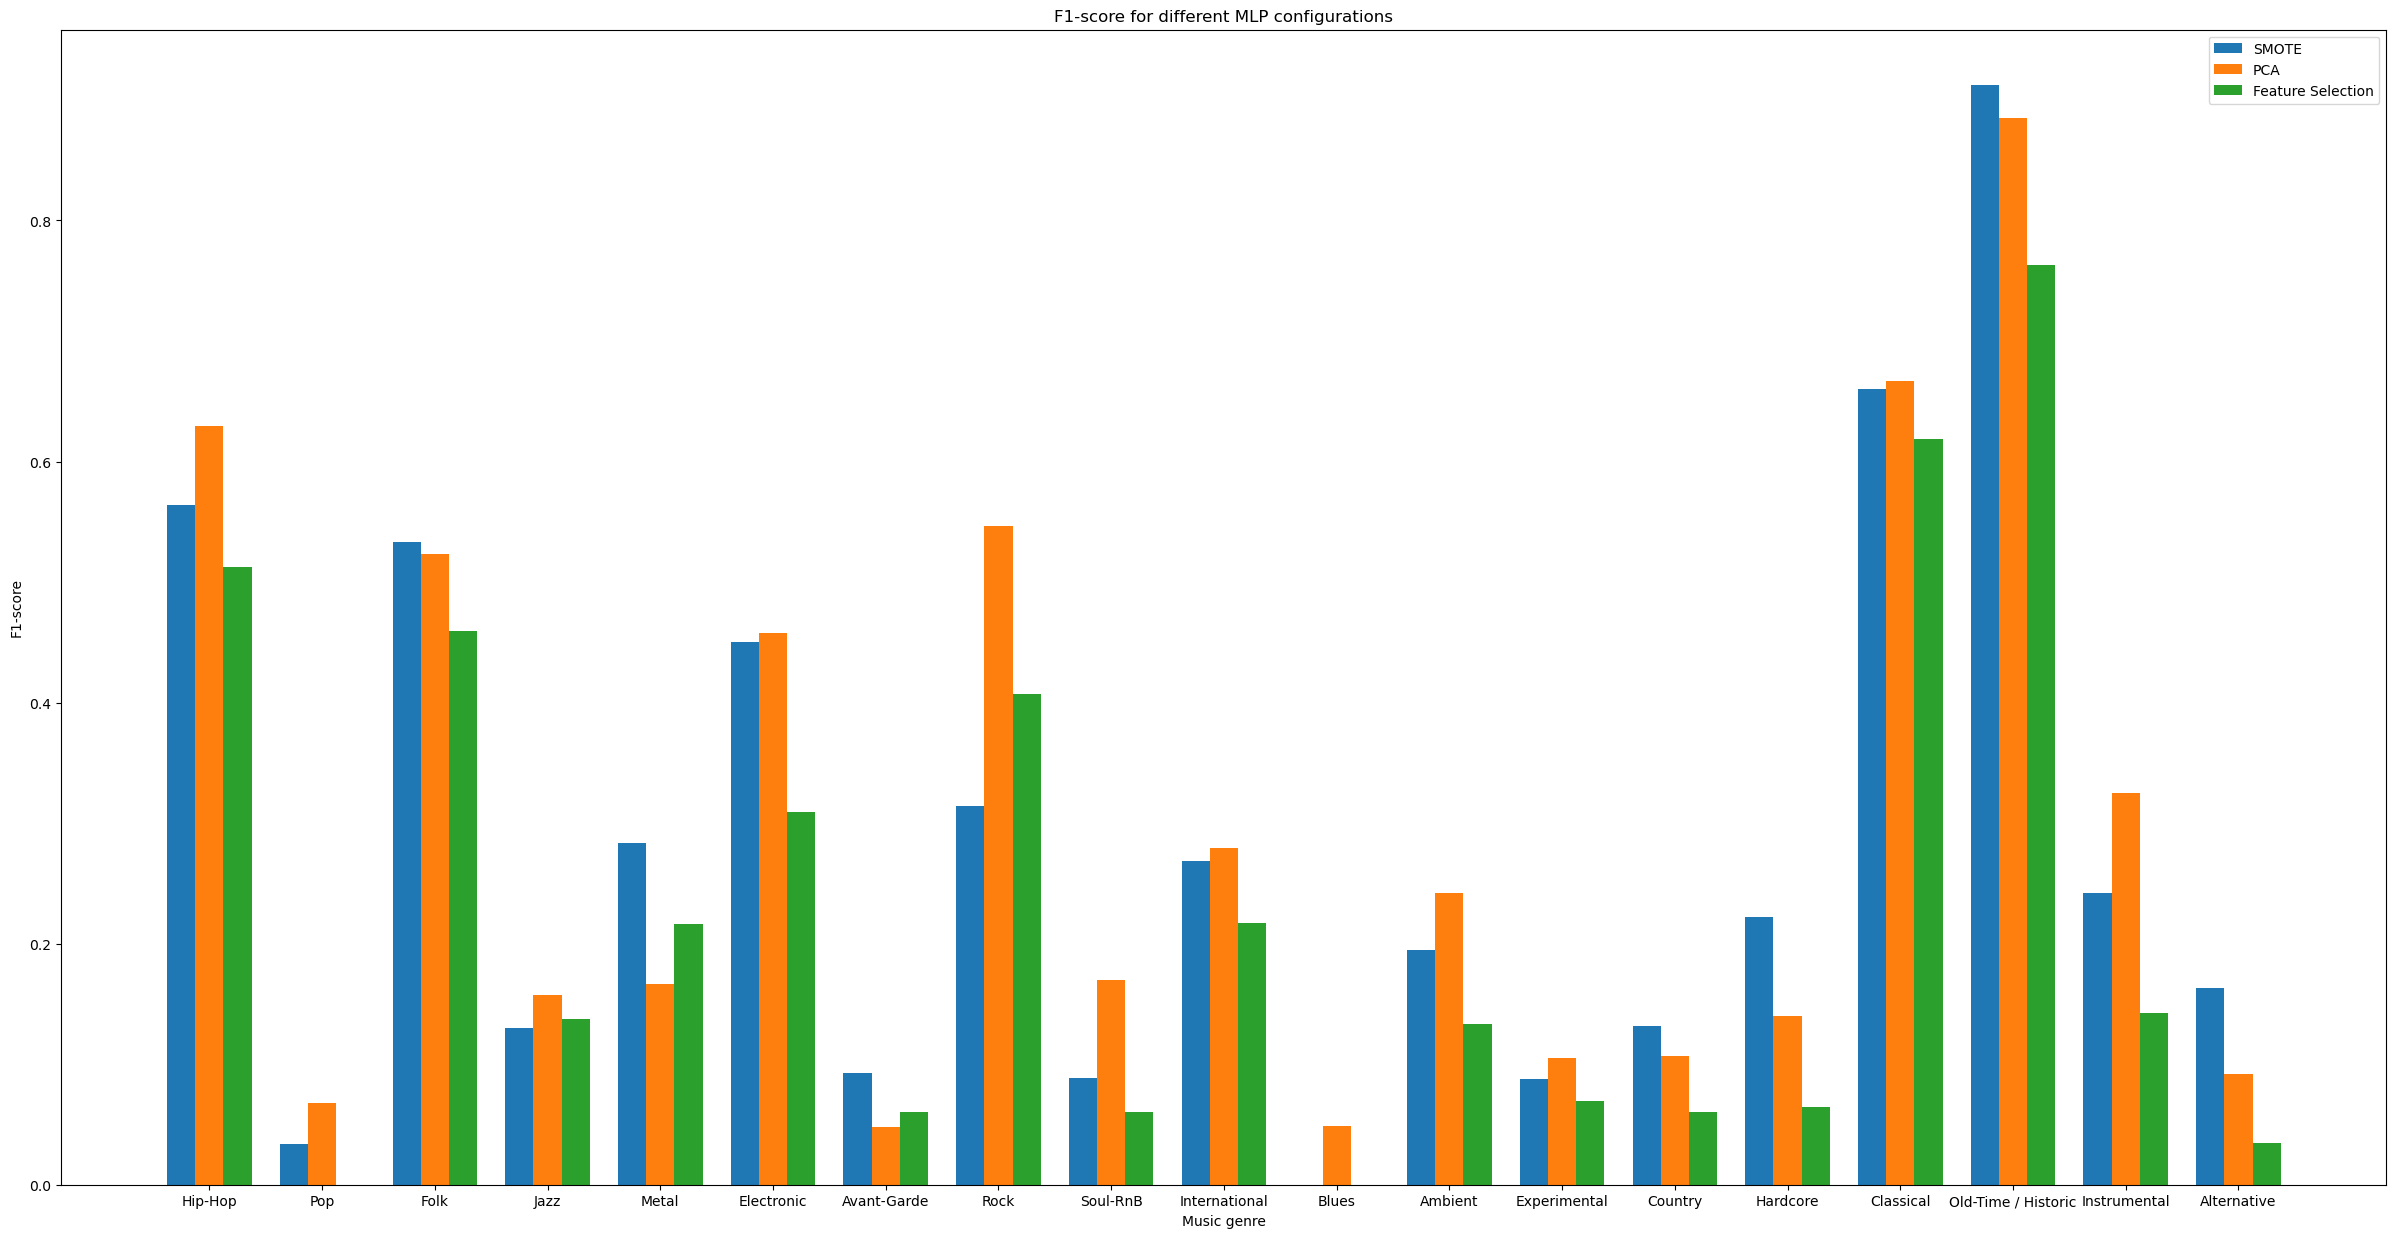

In [120]:
three_group_bar_plot(mlp_f1_test, mlp_f1_test_pca, mlp_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different MLP configurations", "Music genre", 
                    "F1-score", ["SMOTE"]+legend_test)

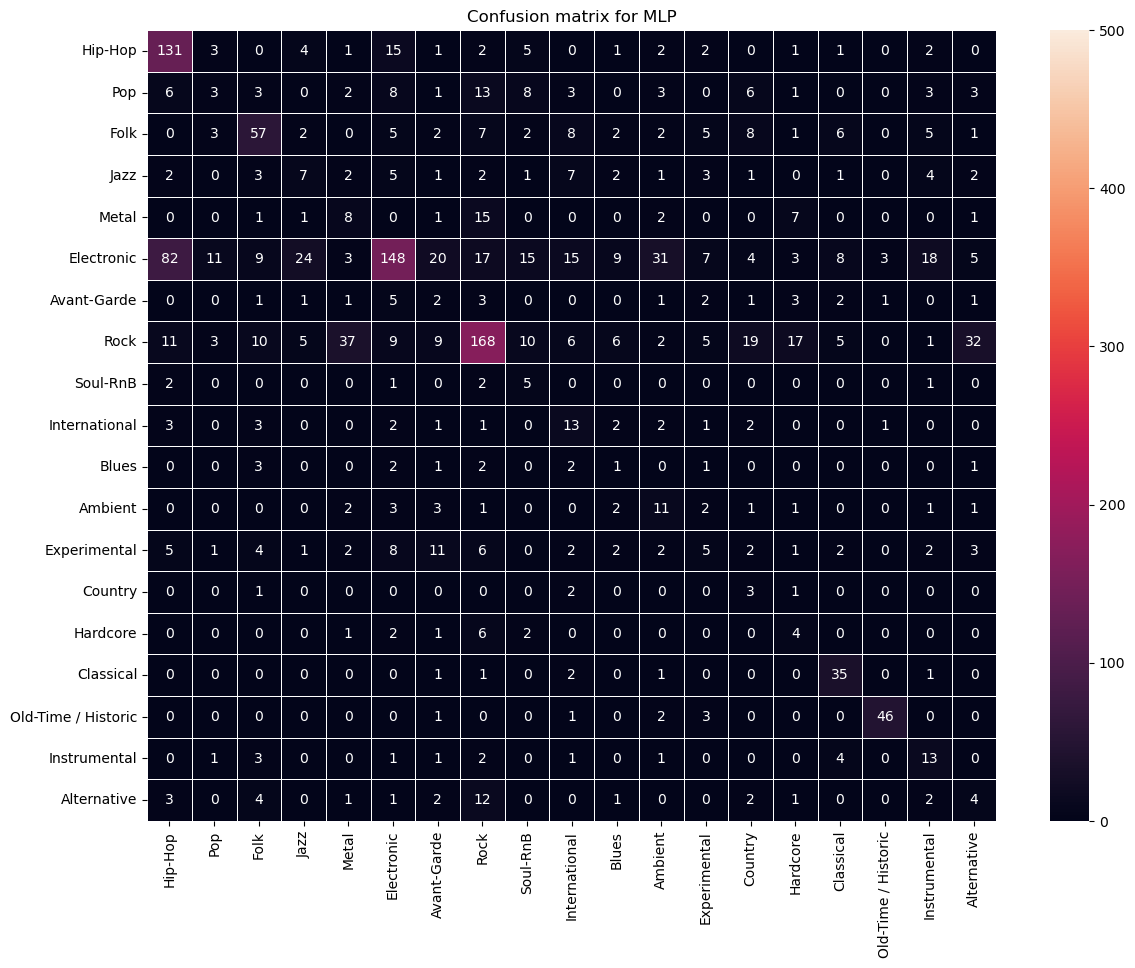

In [122]:
# Confusion matrix
mlp_cm_test_pca = confusion_matrix(y_test, mlp_test_preds_pca, labels=labels)
print_cm(mlp_cm_test_pca, orig_labels, "Confusion matrix for MLP")

## Decision Three classification

### DT without tweaks

In [123]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=plain['DT']['min_samples_leaf'], 
                               min_samples_split=plain['DT']['min_samples_split']).fit(X_train, 
                                                                                      y_train)
dt_val_predict = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report = dt_results[0]
dt_precision = dt_results[1]
dt_recall = dt_results[2]
dt_f1 = dt_results[3]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

### DT with oversampling

In [124]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=overs['DT']['min_samples_leaf'], 
                               min_samples_split=overs['DT']['min_samples_split']).fit(X_train_os, 
                                                                                       y_train_os)
dt_val_predict_os = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results_os = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict_os), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report_os = dt_results_os[0]
dt_precision_os = dt_results_os[1]
dt_recall_os = dt_results_os[2]
dt_f1_os = dt_results_os[3]

### DT with SMOTE

In [125]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=smote['DT']['min_samples_leaf'], 
                               min_samples_split=smote['DT']['min_samples_split']).fit(
    X_train_smote, y_train_smote)

dt_val_predict_smote = cross_val_predict(dt_clf, X_validate, y_validate, cv=5)

dt_results_smote = compute_class_metrics(predictions=le.inverse_transform(dt_val_predict_smote), 
                                y_set=le.inverse_transform(y_validate), 
                                labels=le.inverse_transform(labels))

dt_report_smote = dt_results_smote[0]
dt_precision_smote = dt_results_smote[1]
dt_recall_smote = dt_results_smote[2]
dt_f1_smote = dt_results_smote[3]

### Metrics comparison for DT

In [126]:
print_acc_table(dt_results[4])

Metric     Score
0  Accuracy  0.422365

In [127]:
print("------------------------------ DT Metrics without tweaks ------------------------------")
dt_report

------------------------------ DT Metrics without tweaks ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.429752  0.329114  0.372760      158
Pop                   0.000000  0.000000  0.000000       51
Folk                  0.211679  0.305263  0.250000       95
Jazz                  0.000000  0.000000  0.000000       35
Metal                 0.000000  0.000000  0.000000       21
Electronic            0.451613  0.599496  0.515152      397
Avant-Garde           0.000000  0.000000  0.000000       29
Rock                  0.492000  0.679558  0.570766      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.000000  0.000000  0.000000       13
Experimental          0.000000  0.000000  0.000000       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.222222  0.111111  0.148148       36
Old-Time / Historic   0.237624  0.631579  0.345324       38
Instrumental          0.000000  0.000000  0.000000       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.107626  0.139796  0.115903     1404
weighted avg          0.329369  0.422365  0.364839     1404

In [128]:
print_acc_table(dt_results_os[4])

Metric     Score
0  Accuracy  0.378917

In [129]:
print("---------------------------- DT Metrics with oversampling ----------------------------")
dt_report_os

---------------------------- DT Metrics with oversampling ----------------------------


precision    recall  f1-score  support
Hip-Hop               0.445205  0.411392  0.427632      158
Pop                   0.093023  0.078431  0.085106       51
Folk                  0.340426  0.336842  0.338624       95
Jazz                  0.086957  0.057143  0.068966       35
Metal                 0.066667  0.047619  0.055556       21
Electronic            0.503797  0.501259  0.502525      397
Avant-Garde           0.083333  0.103448  0.092308       29
Rock                  0.521212  0.475138  0.497110      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.052632  0.047619  0.050000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.086957  0.153846  0.111111       13
Experimental          0.088889  0.125000  0.103896       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.066667  0.083333  0.074074       12
Classical             0.428571  0.500000  0.461538       36
Old-Time / Historic   0.793103  0.605263  0.686567       38
Instrumental          0.000000  0.000000  0.000000       18
Alternative           0.014493  0.037037  0.020833       27
macro avg             0.193260  0.187546  0.188202     1404
weighted avg          0.397191  0.378917  0.386816     1404

In [130]:
print_acc_table(dt_results_smote[4])

Metric     Score
0  Accuracy  0.371083

In [131]:
print("------------------------------ DT Metrics with SMOTE ------------------------------")
dt_report_smote

------------------------------ DT Metrics with SMOTE ------------------------------


precision    recall  f1-score  support
Hip-Hop               0.444444  0.405063  0.423841      158
Pop                   0.119048  0.098039  0.107527       51
Folk                  0.333333  0.315789  0.324324       95
Jazz                  0.027027  0.028571  0.027778       35
Metal                 0.111111  0.047619  0.066667       21
Electronic            0.492500  0.496222  0.494354      397
Avant-Garde           0.085714  0.103448  0.093750       29
Rock                  0.514377  0.444751  0.477037      362
Soul-RnB              0.000000  0.000000  0.000000       13
International         0.000000  0.000000  0.000000       21
Blues                 0.000000  0.000000  0.000000        9
Ambient               0.125000  0.230769  0.162162       13
Experimental          0.112360  0.156250  0.130719       64
Country               0.000000  0.000000  0.000000        5
Hardcore              0.000000  0.000000  0.000000       12
Classical             0.463415  0.527778  0.493506       36
Old-Time / Historic   0.833333  0.657895  0.735294       38
Instrumental          0.125000  0.111111  0.117647       18
Alternative           0.000000  0.000000  0.000000       27
macro avg             0.199298  0.190700  0.192348     1404
weighted avg          0.395205  0.371083  0.381480     1404

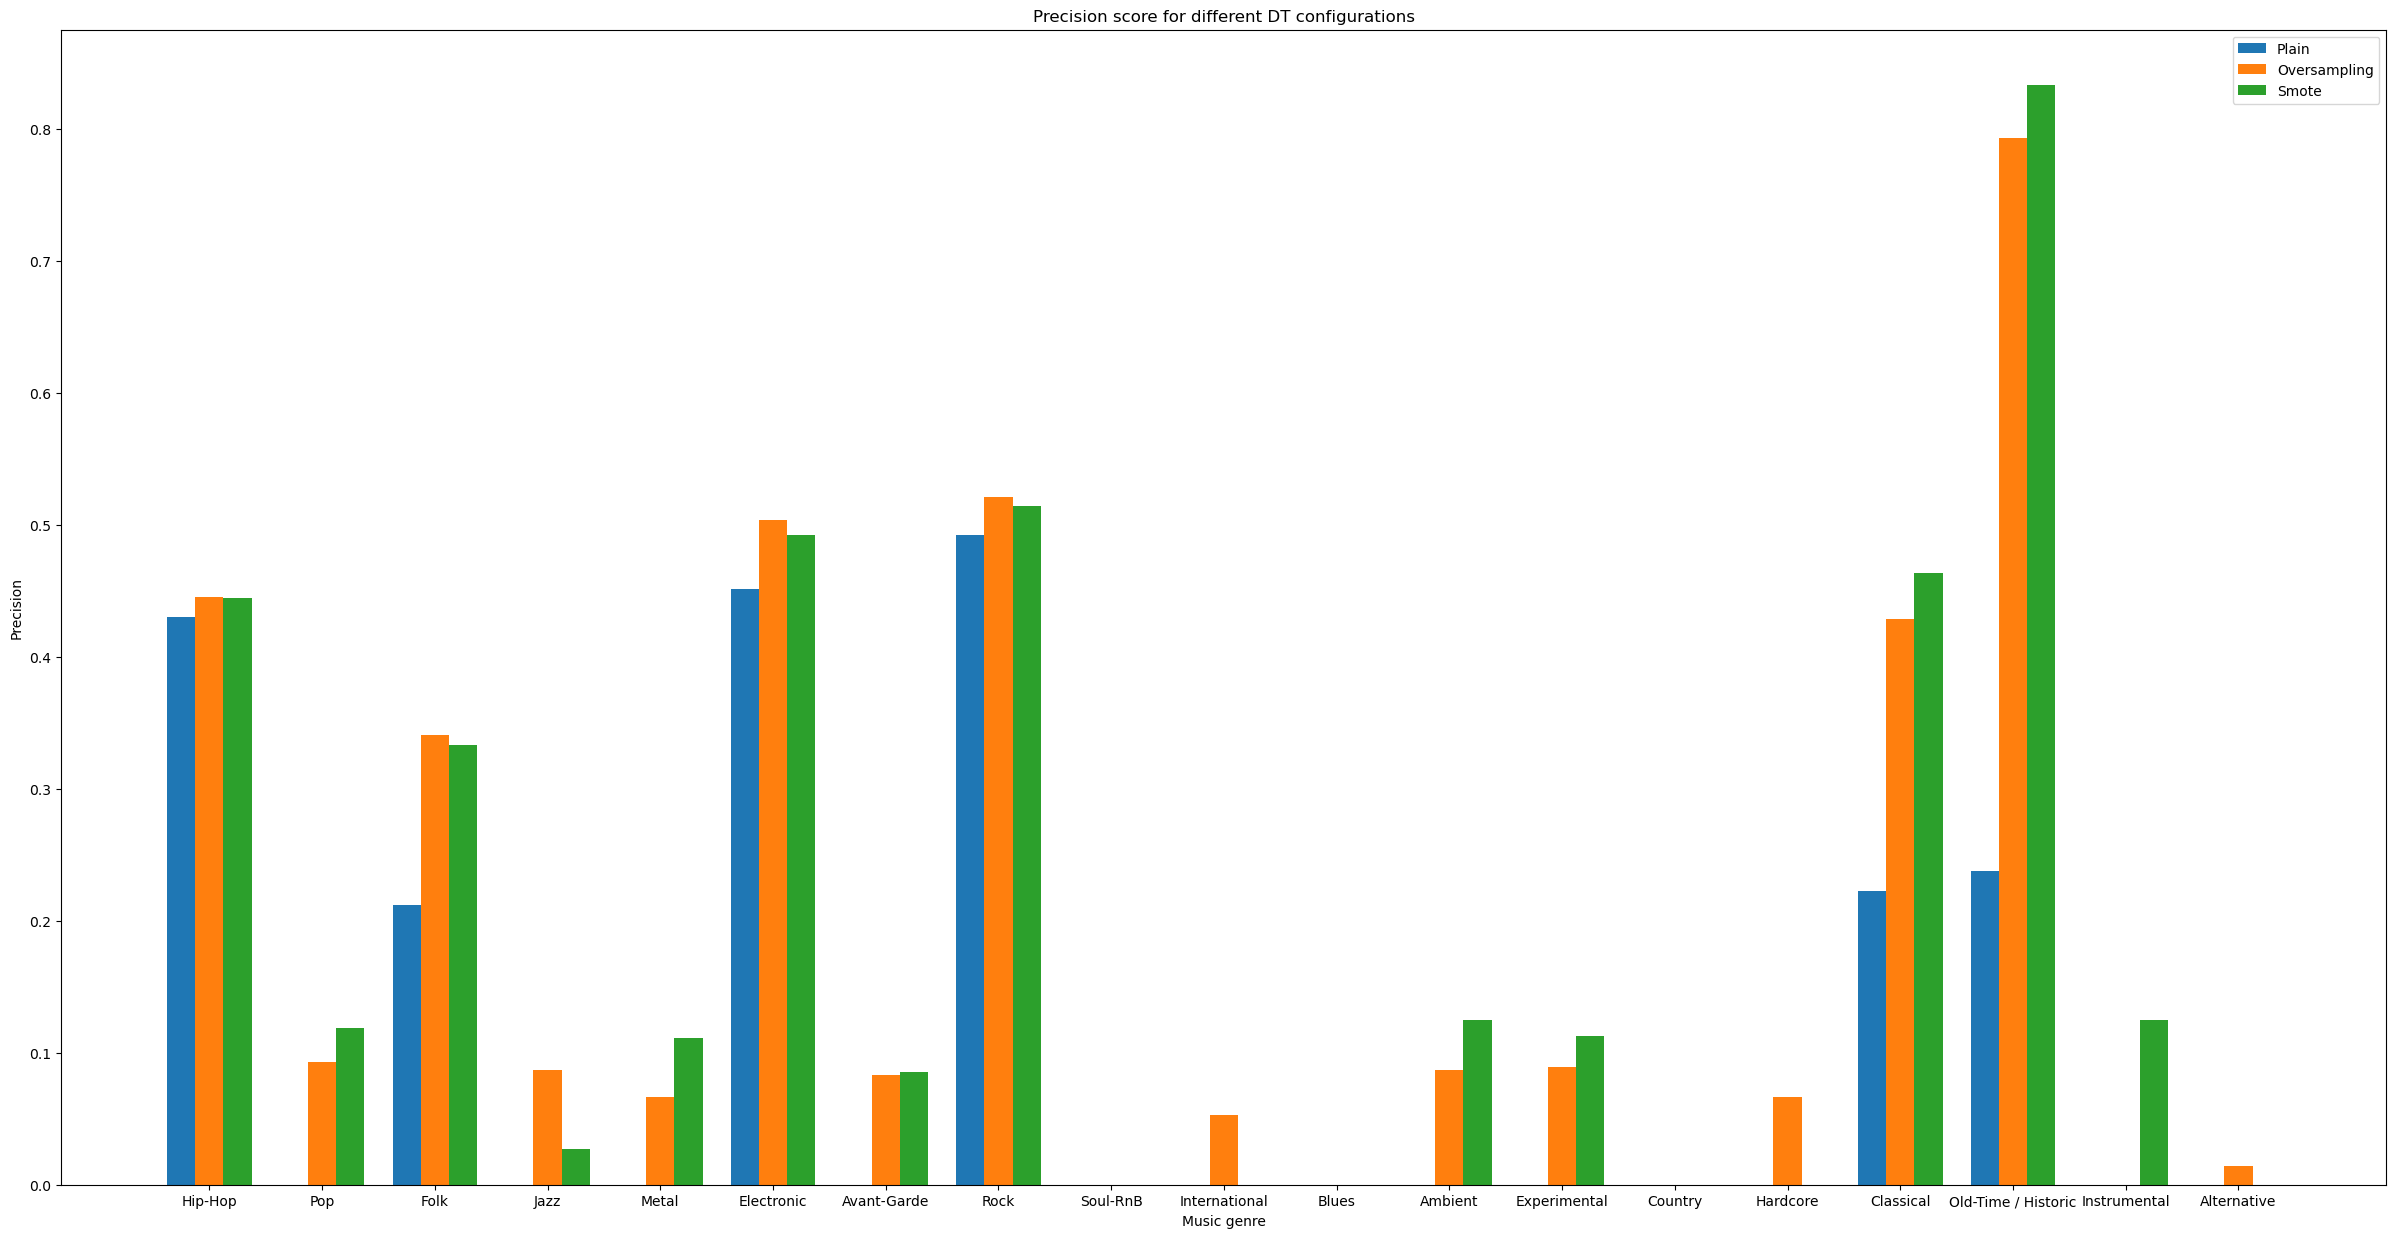

In [132]:
three_group_bar_plot(dt_precision, dt_precision_os, dt_precision_smote, 
                     le.inverse_transform(labels), 
                     "Precision score for different DT configurations", "Music genre", 
                    "Precision", legend_validation)

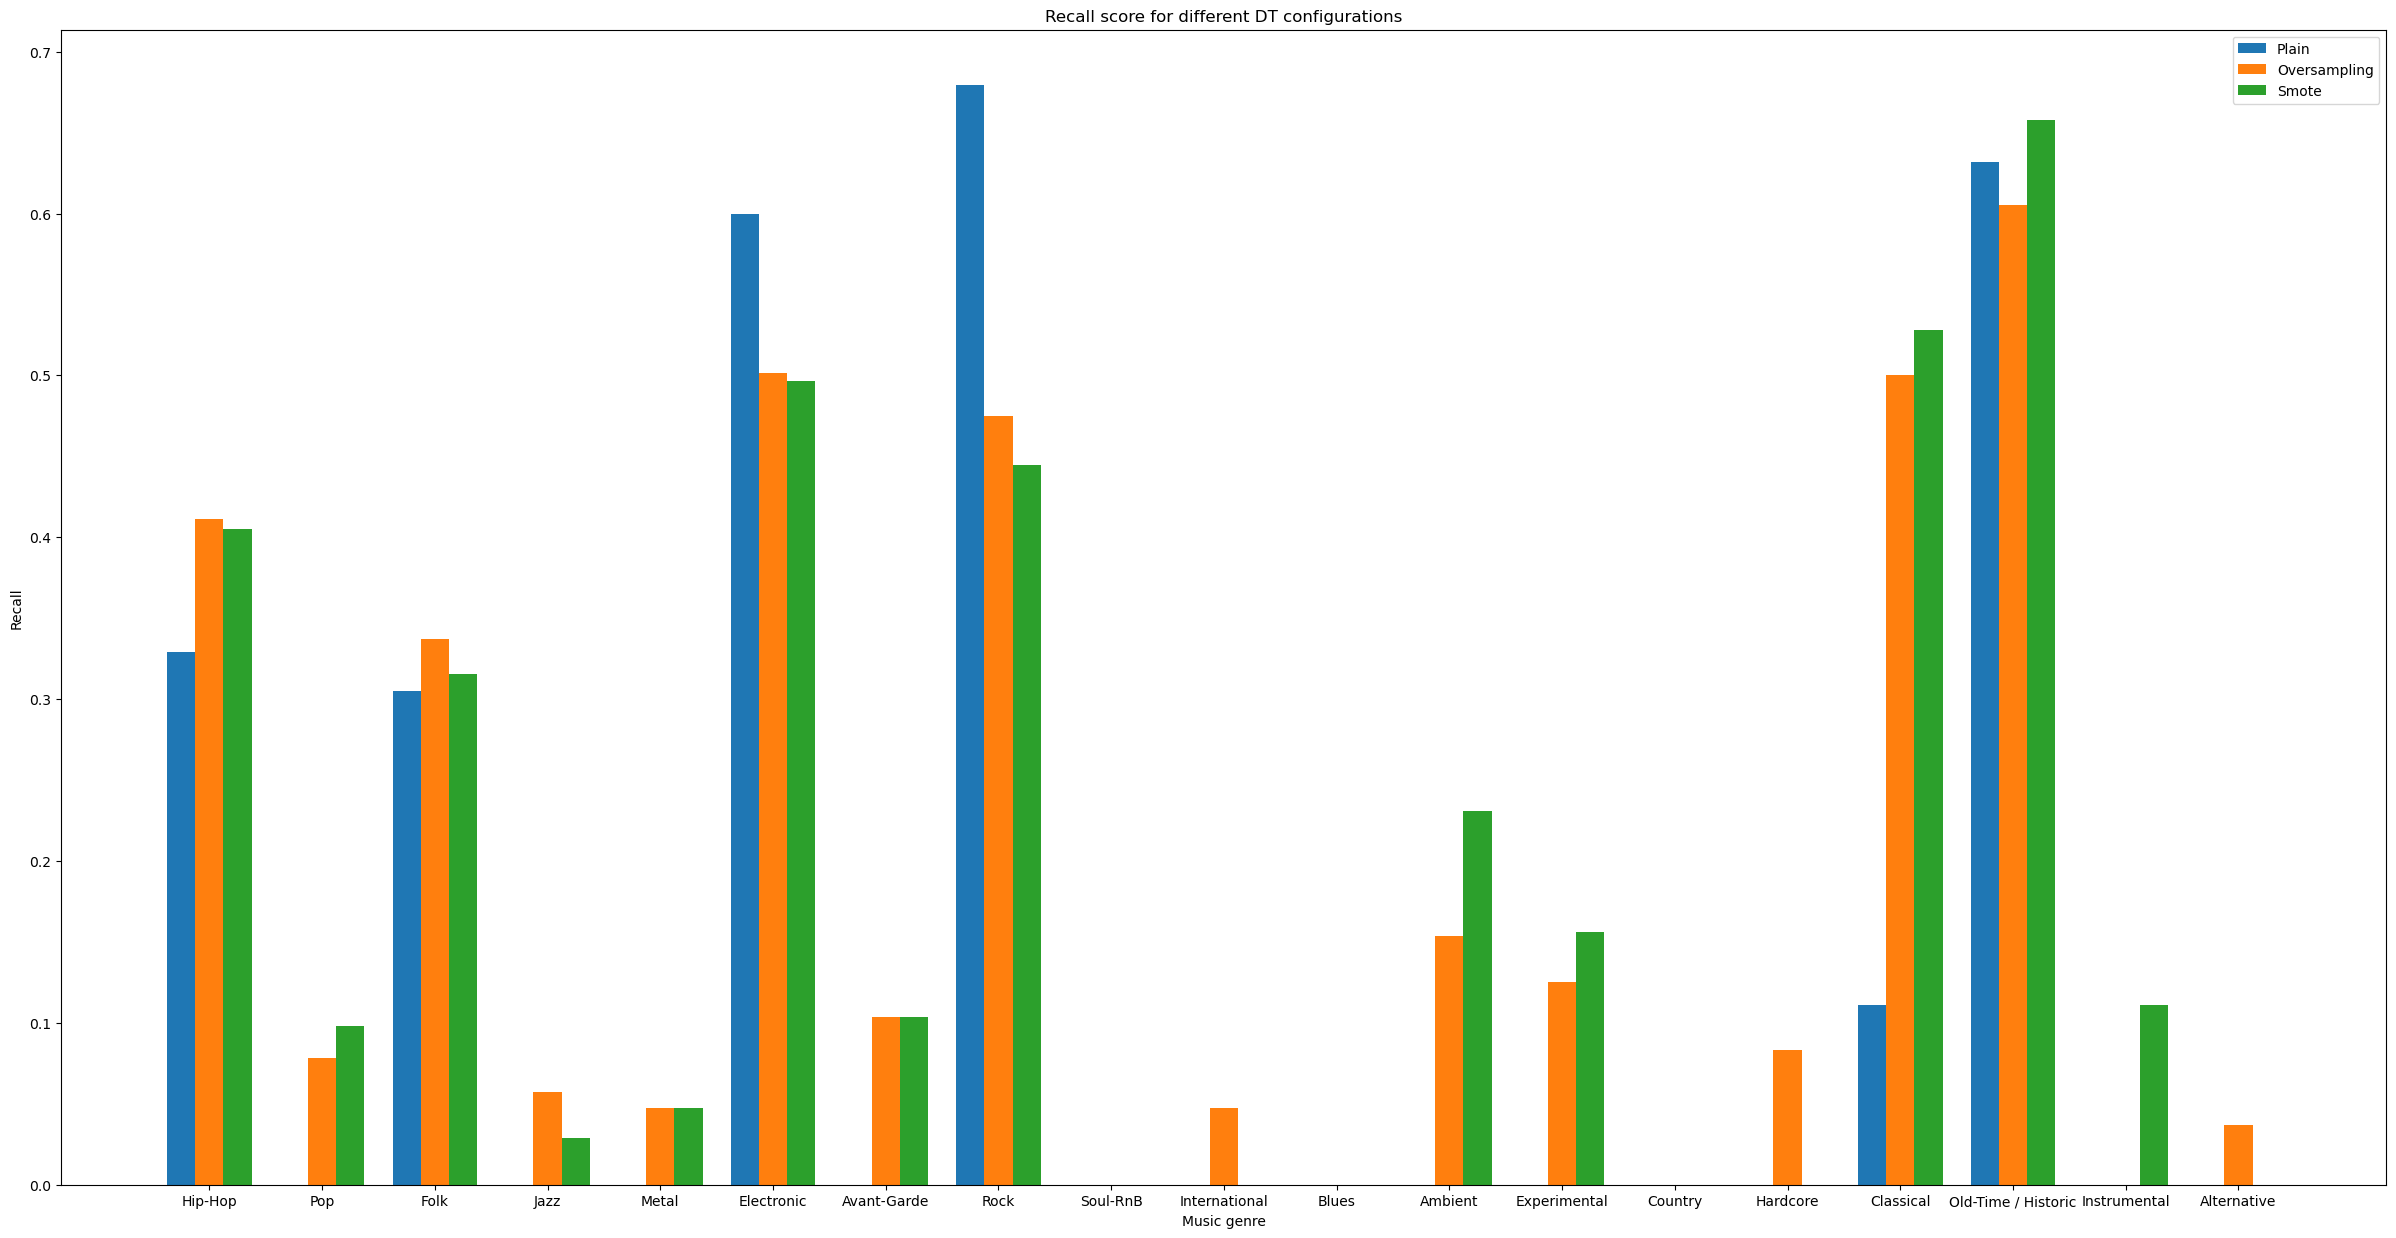

In [133]:
three_group_bar_plot(dt_recall, dt_recall_os, dt_recall_smote, 
                     le.inverse_transform(labels), 
                     "Recall score for different DT configurations", "Music genre", 
                    "Recall", legend_validation)

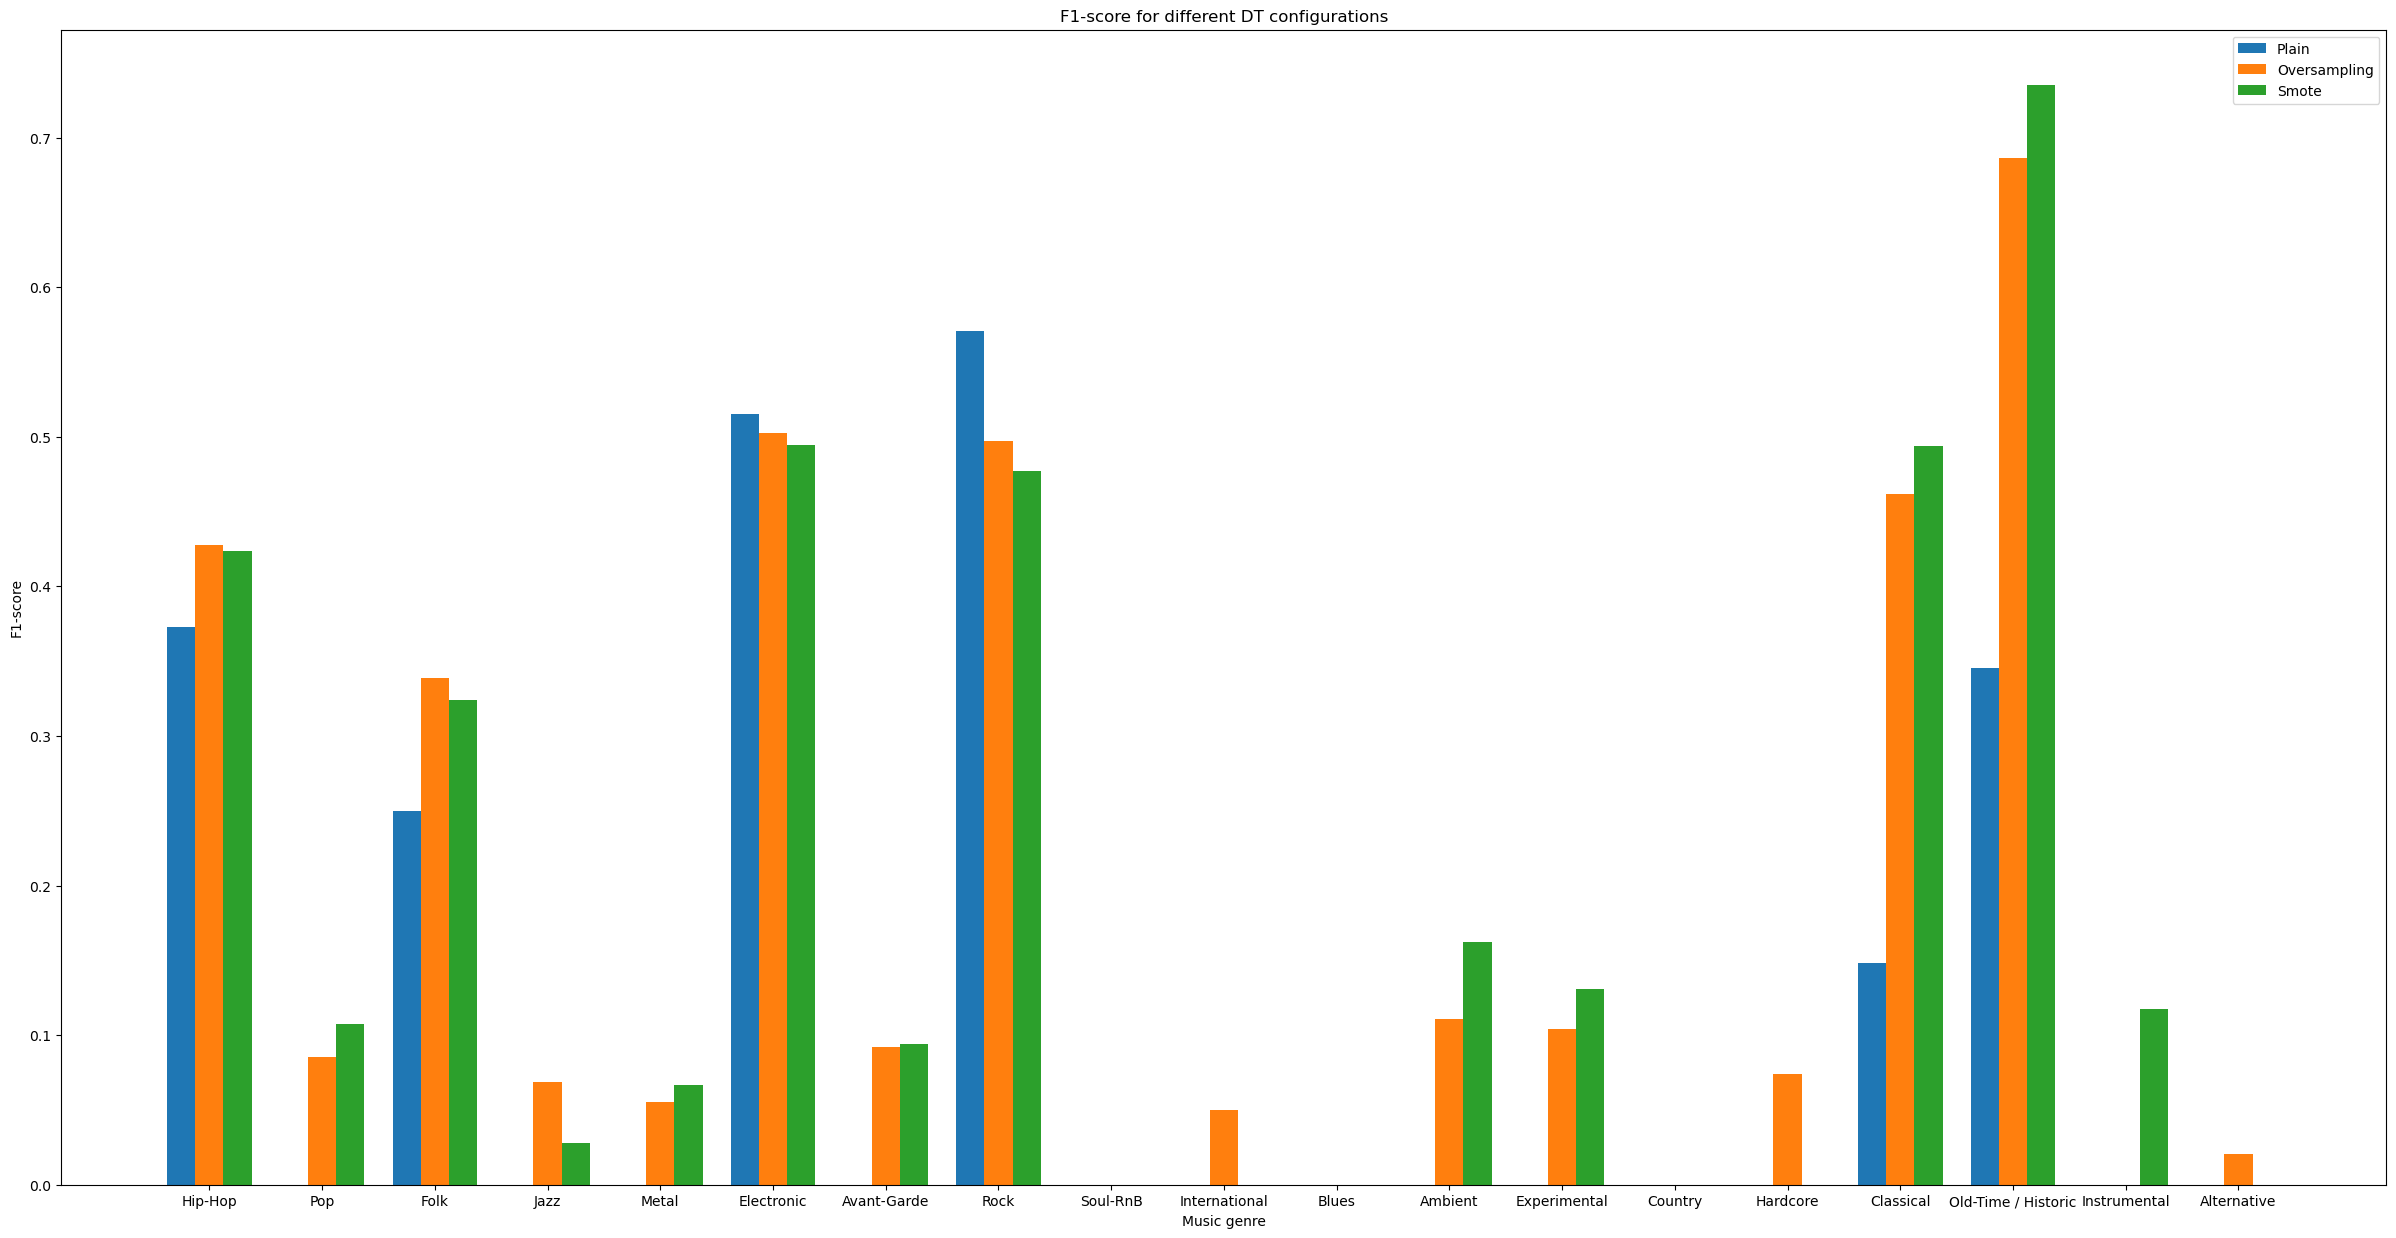

In [134]:
three_group_bar_plot(dt_f1, dt_f1_os, dt_f1_smote, 
                     le.inverse_transform(labels), 
                     "F1-score for different DT configurations", "Music genre", 
                    "F1-score", legend_validation)

### DT on test set
Best case: OVERS

In [7]:
orig_labels = le.inverse_transform(labels)
dt_clf = DecisionTreeClassifier(min_samples_leaf=overs['DT']['min_samples_leaf'], 
                               min_samples_split=overs['DT']['min_samples_split']).fit(X_train_os, y_train_os)
dt_test_preds = dt_clf.predict(X_test)

dt_results_test = compute_class_metrics(
    predictions=le.inverse_transform(dt_test_preds), 
    y_set=le.inverse_transform(y_test), 
    labels= orig_labels
)

dt_report_test = dt_results_test[0]
dt_precision_test = dt_results_test[1]
dt_recall_test = dt_results_test[2]
dt_f1_test = dt_results_test[3]

In [28]:
pca = PCA(n_components=overs_pca['DT']['n_components'])
X_train_pca = pca.fit_transform(X_train_os, y_train_os)
X_test_pca = pca.transform(X_test)

dt_clf = DecisionTreeClassifier(min_samples_leaf=overs_pca['DT']['min_samples_leaf'], 
                               min_samples_split=overs_pca['DT']['min_samples_split']).fit(X_train_pca, y_train_os)

dt_test_preds_pca = dt_clf.predict(X_test_pca)

dt_results_test_pca = compute_class_metrics(
    predictions=le.inverse_transform(dt_test_preds_pca), 
    y_set=le.inverse_transform(y_test), 
    labels= orig_labels
)

dt_report_test_pca = dt_results_test_pca[0]
dt_precision_test_pca = dt_results_test_pca[1]
dt_recall_test_pca = dt_results_test_pca[2]
dt_f1_test_pca = dt_results_test_pca[3]

In [8]:
dt_clf = DecisionTreeClassifier(min_samples_leaf=overs['DT']['min_samples_leaf'], 
                               min_samples_split=overs['DT']['min_samples_split']).fit(
    X_train_os_fs, y_train_os_fs)

dt_test_preds_fs = dt_clf.predict(X_test_fs)

dt_results_test_fs = compute_class_metrics(
    predictions=le.inverse_transform(dt_test_preds_fs), 
    y_set=le.inverse_transform(y_test_fs), 
    labels= orig_labels
)

dt_report_test_fs = dt_results_test_fs[0]
dt_precision_test_fs = dt_results_test_fs[1]
dt_recall_test_fs = dt_results_test_fs[2]
dt_f1_test_fs = dt_results_test_fs[3]

In [9]:
print_acc_table(dt_results_test[4])

Metric     Score
0  Accuracy  0.403846

In [10]:
print("---------------------- DT Metrics on test set with oversampling ------------------------")
dt_report_test

---------------------- DT Metrics on test set with oversampling ------------------------


precision    recall  f1-score  support
Hip-Hop               0.523810  0.450292  0.484277      171
Pop                   0.092308  0.095238  0.093750       63
Folk                  0.390625  0.431034  0.409836      116
Jazz                  0.137255  0.159091  0.147368       44
Metal                 0.242424  0.222222  0.231884       36
Electronic            0.473684  0.479167  0.476410      432
Avant-Garde           0.068966  0.083333  0.075472       24
Rock                  0.534954  0.495775  0.514620      355
Soul-RnB              0.050000  0.090909  0.064516       11
International         0.275862  0.258065  0.266667       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.035714  0.035714  0.035714       28
Experimental          0.074627  0.084746  0.079365       59
Country               0.166667  0.285714  0.210526        7
Hardcore              0.160000  0.250000  0.195122       16
Classical             0.675676  0.609756  0.641026       41
Old-Time / Historic   0.854167  0.773585  0.811881       53
Instrumental          0.347826  0.296296  0.320000       27
Alternative           0.062500  0.060606  0.061538       33
macro avg             0.271951  0.271660  0.269472     1560
weighted avg          0.419436  0.403846  0.410665     1560

In [29]:
print_acc_table(dt_results_test_pca[4])

Metric     Score
0  Accuracy  0.317949

In [30]:
print("------------------ DT Metrics on test set with oversampling (PCA) --------------------")
dt_report_test_pca

------------------ DT Metrics on test set with oversampling (PCA) --------------------


precision    recall  f1-score  support
Hip-Hop               0.513514  0.444444  0.476489      171
Pop                   0.038462  0.031746  0.034783       63
Folk                  0.365385  0.327586  0.345455      116
Jazz                  0.115385  0.136364  0.125000       44
Metal                 0.090909  0.166667  0.117647       36
Electronic            0.548780  0.312500  0.398230      432
Avant-Garde           0.058824  0.166667  0.086957       24
Rock                  0.511013  0.326761  0.398625      355
Soul-RnB              0.022727  0.090909  0.036364       11
International         0.116883  0.290323  0.166667       31
Blues                 0.017857  0.076923  0.028986       13
Ambient               0.126582  0.357143  0.186916       28
Experimental          0.090909  0.067797  0.077670       59
Country               0.057143  0.285714  0.095238        7
Hardcore              0.139535  0.375000  0.203390       16
Classical             0.489796  0.585366  0.533333       41
Old-Time / Historic   0.728814  0.811321  0.767857       53
Instrumental          0.204082  0.370370  0.263158       27
Alternative           0.048387  0.090909  0.063158       33
macro avg             0.225526  0.279711  0.231891     1560
weighted avg          0.411746  0.317949  0.346504     1560

In [11]:
print_acc_table(dt_results_test_fs[4])

Metric     Score
0  Accuracy  0.340385

In [12]:
print("------------------ DT Metrics on test set with oversampling (fs) --------------------")
dt_report_test_fs

------------------ DT Metrics on test set with oversampling (fs) --------------------


precision    recall  f1-score  support
Hip-Hop               0.435897  0.397661  0.415902      171
Pop                   0.112903  0.111111  0.112000       63
Folk                  0.206522  0.163793  0.182692      116
Jazz                  0.064516  0.090909  0.075472       44
Metal                 0.205882  0.194444  0.200000       36
Electronic            0.449772  0.456019  0.452874      432
Avant-Garde           0.027778  0.041667  0.033333       24
Rock                  0.484375  0.436620  0.459259      355
Soul-RnB              0.000000  0.000000  0.000000       11
International         0.166667  0.193548  0.179104       31
Blues                 0.000000  0.000000  0.000000       13
Ambient               0.054054  0.071429  0.061538       28
Experimental          0.059524  0.084746  0.069930       59
Country               0.000000  0.000000  0.000000        7
Hardcore              0.000000  0.000000  0.000000       16
Classical             0.395349  0.414634  0.404762       41
Old-Time / Historic   0.883721  0.716981  0.791667       53
Instrumental          0.151515  0.185185  0.166667       27
Alternative           0.000000  0.000000  0.000000       33
macro avg             0.194657  0.187302  0.189747     1560
weighted avg          0.359044  0.340385  0.348604     1560

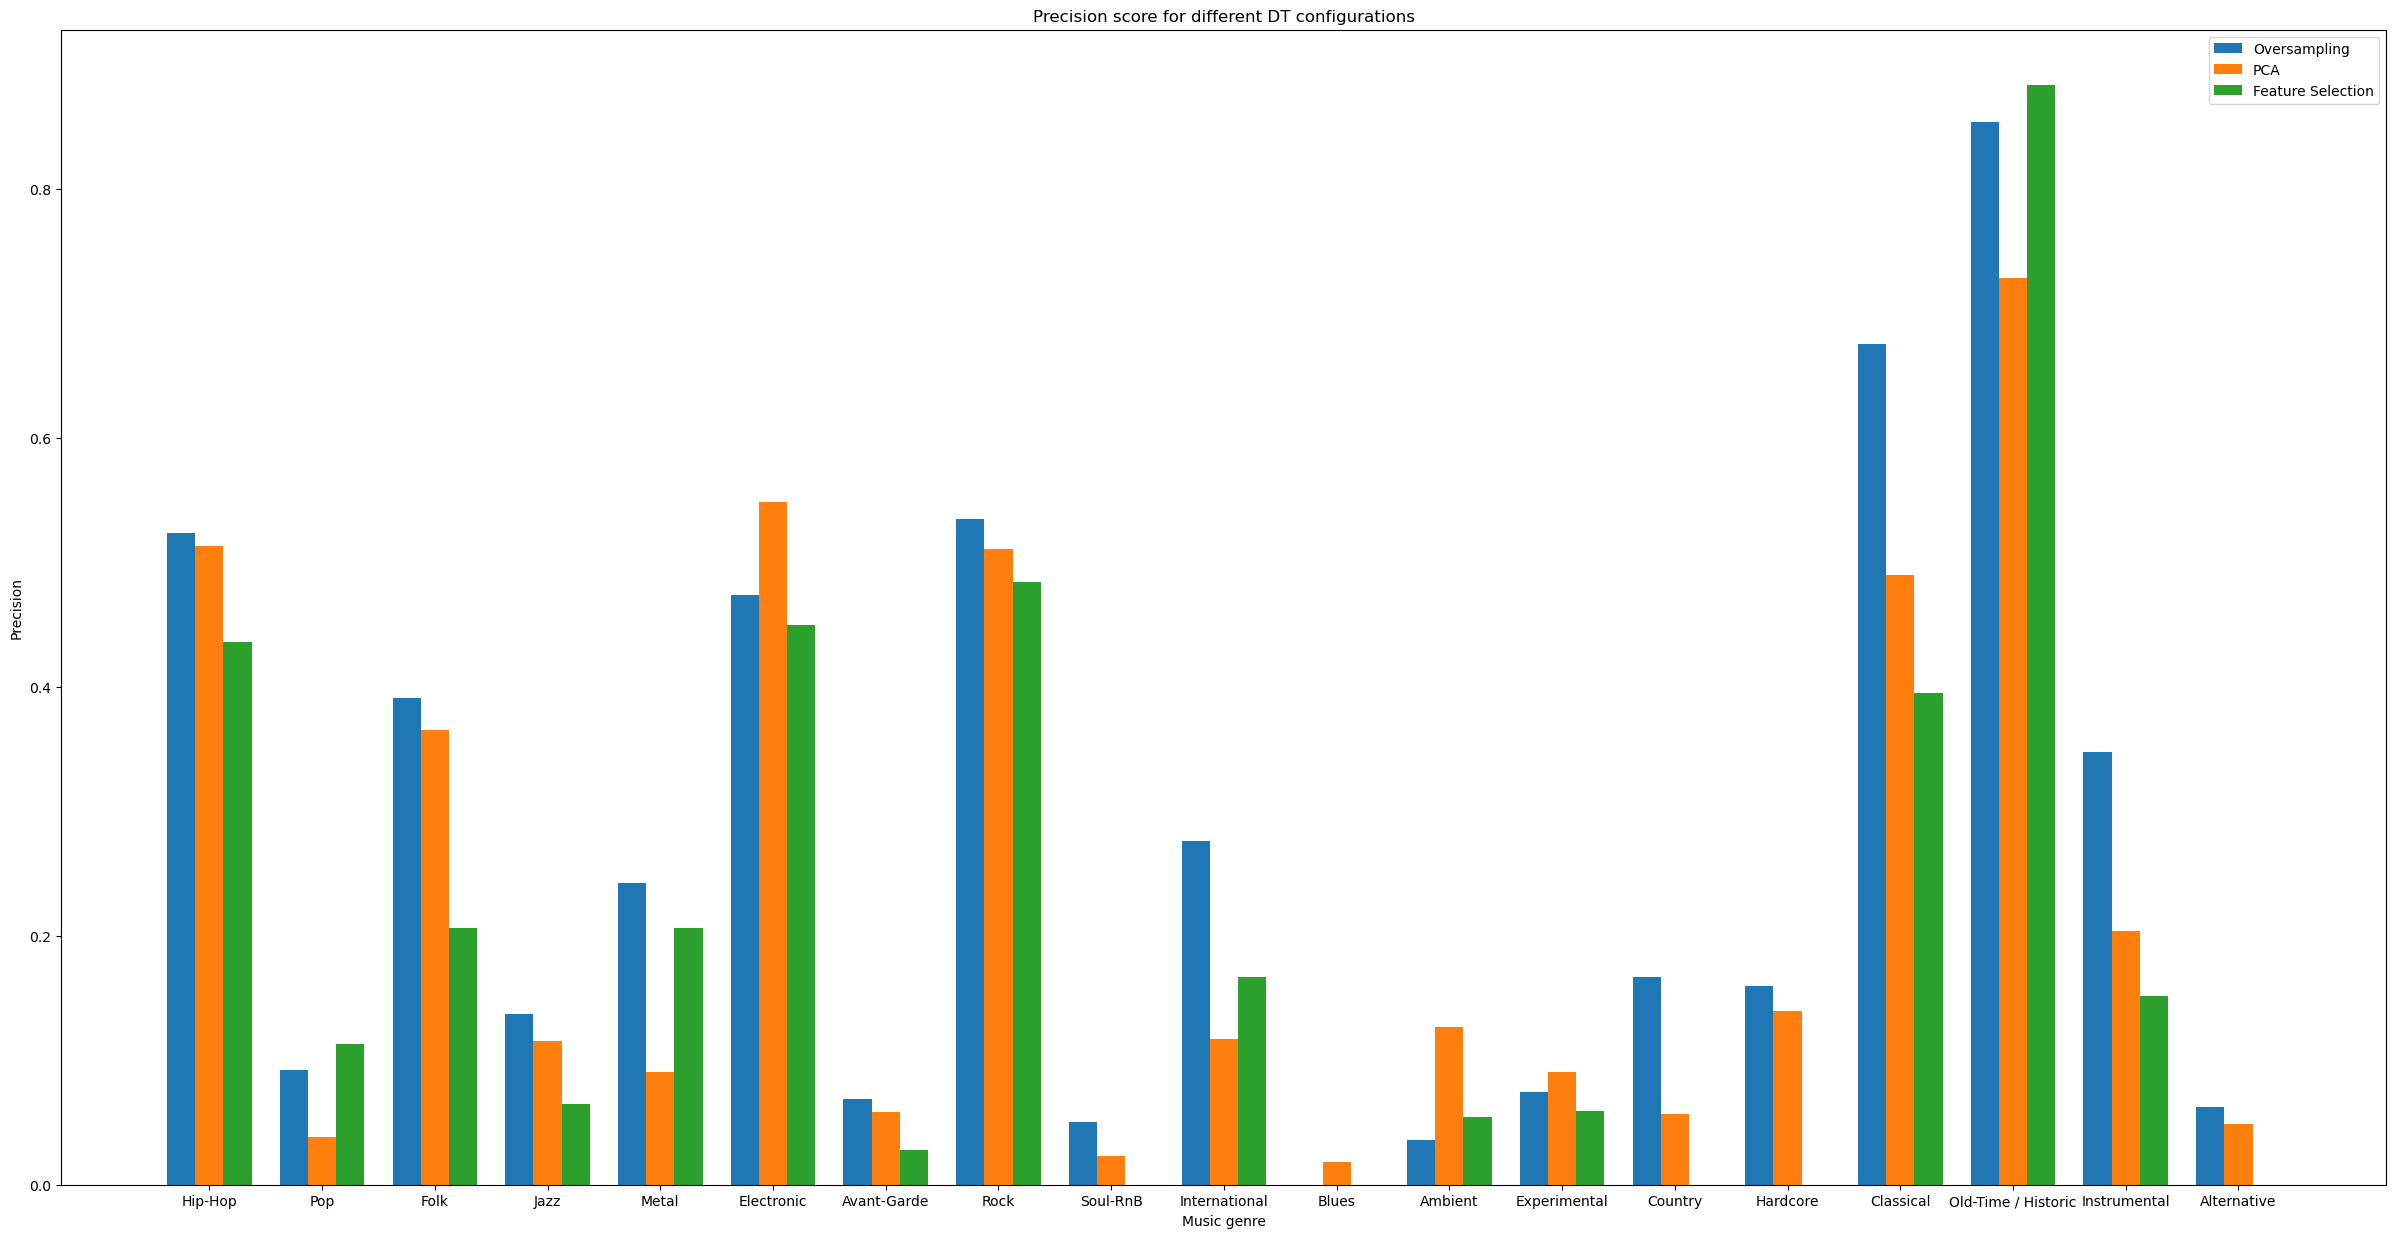

In [31]:
three_group_bar_plot(dt_precision_test, dt_precision_test_pca, dt_precision_test_fs, 
                     le.inverse_transform(labels), 
                     "Precision score for different DT configurations", "Music genre", 
                    "Precision", ["Oversampling"]+legend_test)

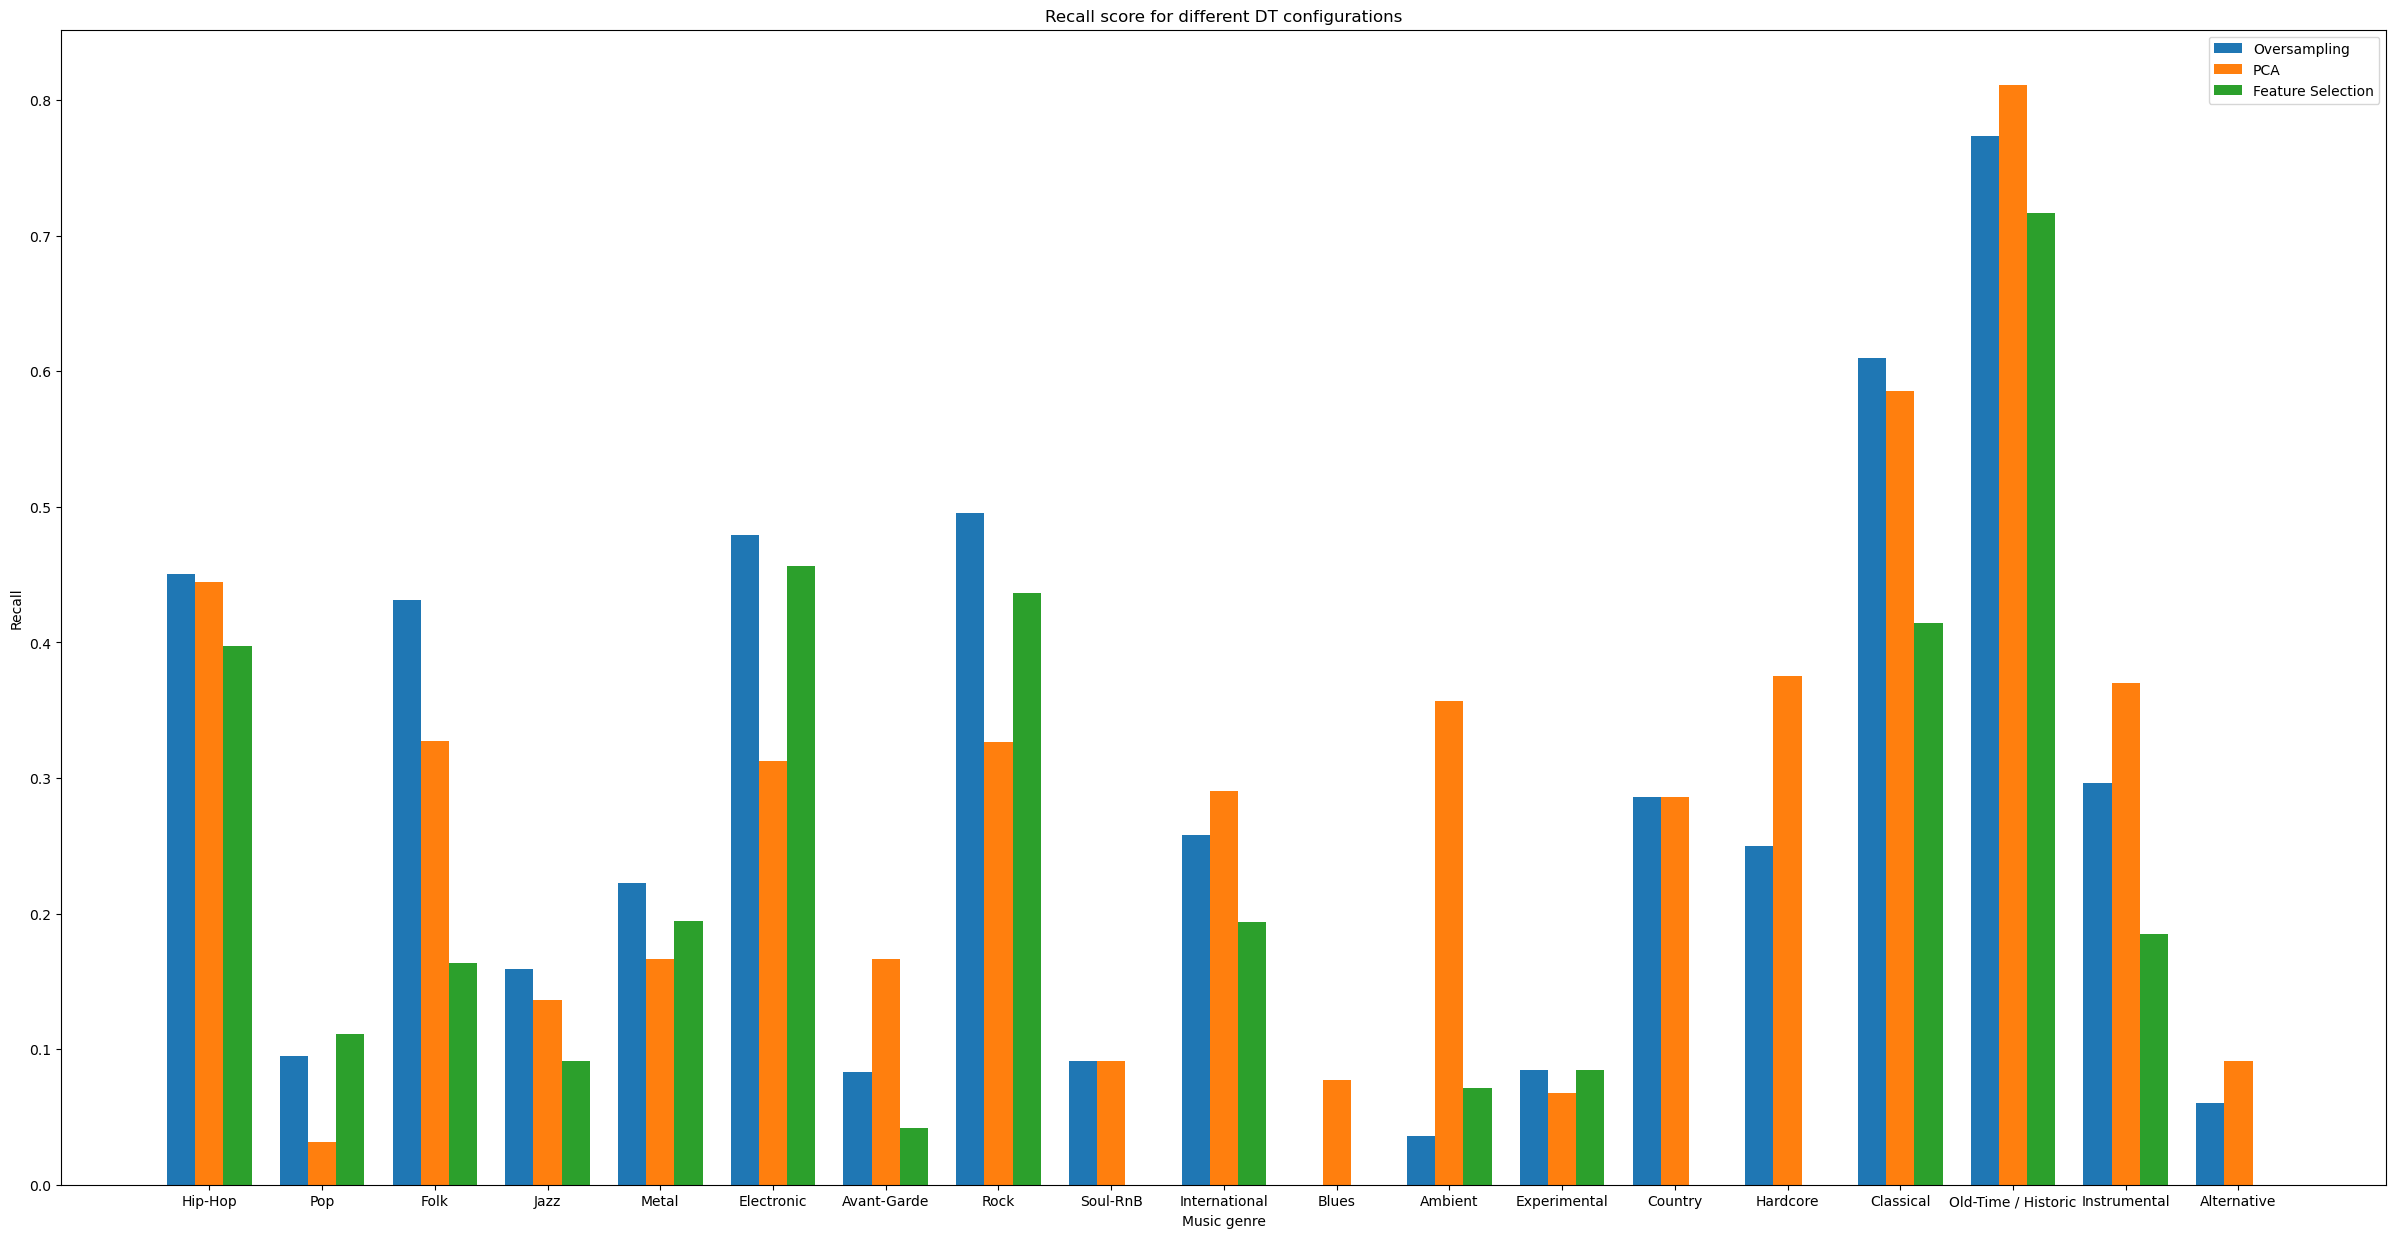

In [32]:
three_group_bar_plot(dt_recall_test, dt_recall_test_pca, dt_recall_test_fs, 
                     le.inverse_transform(labels), 
                     "Recall score for different DT configurations", "Music genre", 
                    "Recall", ["Oversampling"]+legend_test)

In [33]:
three_group_bar_plot(dt_f1_test, dt_f1_test_pca, dt_f1_test_fs, 
                     le.inverse_transform(labels), 
                     "F1-score for different DT configurations", "Music genre", 
                    "F1-score", ["Oversampling"]+legend_test)

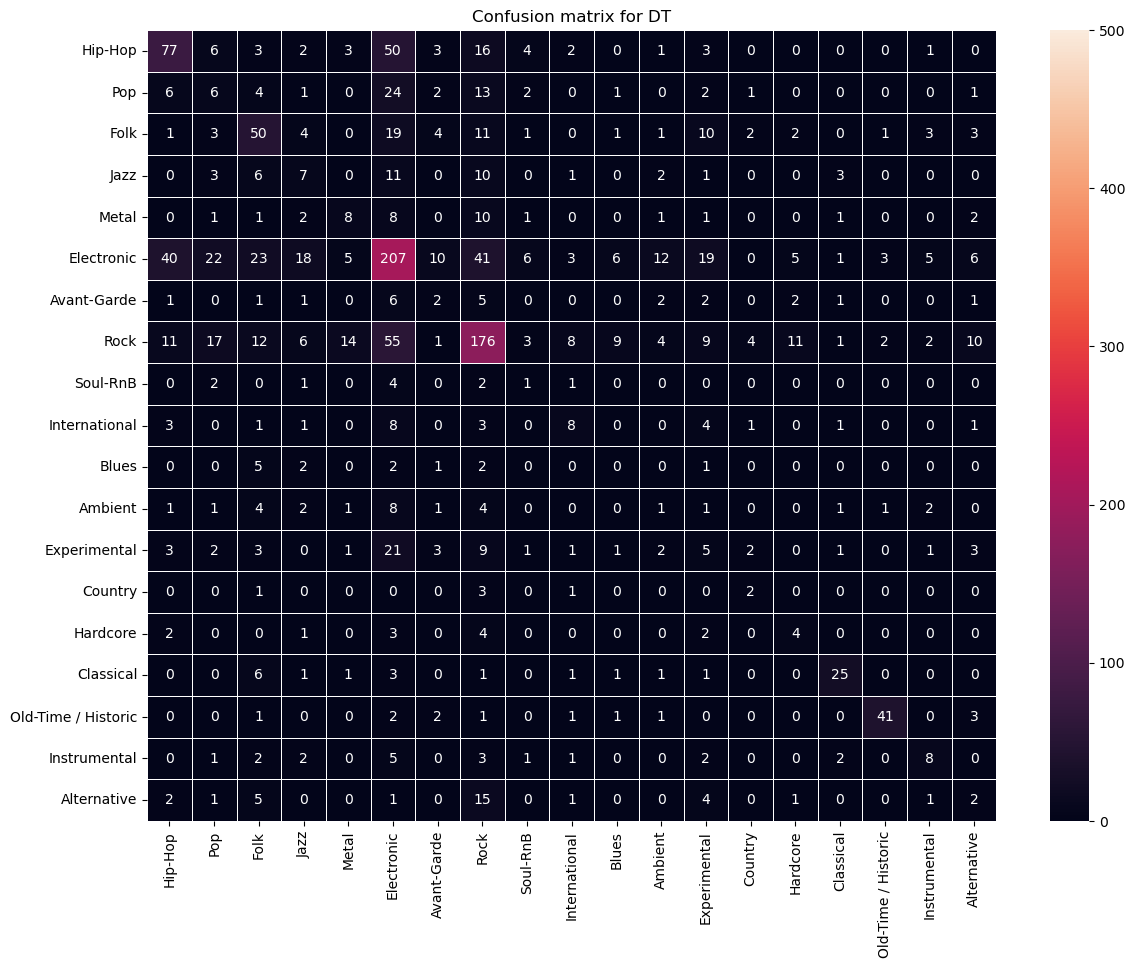

In [13]:
# Confusion matrix
dt_cm_test = confusion_matrix(y_test, dt_test_preds, labels=labels)
print_cm(dt_cm_test, orig_labels, "Confusion matrix for DT")

## Comparison between classifiers
<br>
After analyzing the performance of each classifier, a comparison is made between them. For each classifier, we chose the case in which its performance seems to be the best. <br>
The results of this comparison are shown below, both in tabular and graphic form. <br>

In [24]:
classifiers = ["Support Vector Machine", "Logistic Regression", "KNeighbors", 
               "Multilayer Perceptron", "Decision Tree"]

classifs_acc_dict = {"Classifier":[], "Accuracy":[]}
for classifier in classifiers:
    classifs_acc_dict["Classifier"].append(classifier)

classifs_acc_dict["Accuracy"].append(svm_results_test[4])
classifs_acc_dict["Accuracy"].append(lr_results_test[4])
classifs_acc_dict["Accuracy"].append(knn_results_test_pca[4])
classifs_acc_dict["Accuracy"].append(mlp_results_test_pca[4])
classifs_acc_dict["Accuracy"].append(dt_results_test[4])

accuracy_table = pd.DataFrame.from_dict(classifs_acc_dict)
accuracy_table = accuracy_table.astype({"Accuracy": float})
accuracy_table

Classifier  Accuracy
0  Support Vector Machine  0.467308
1     Logistic Regression  0.576923
2              KNeighbors  0.477564
3   Multilayer Perceptron  0.441667
4           Decision Tree  0.403846

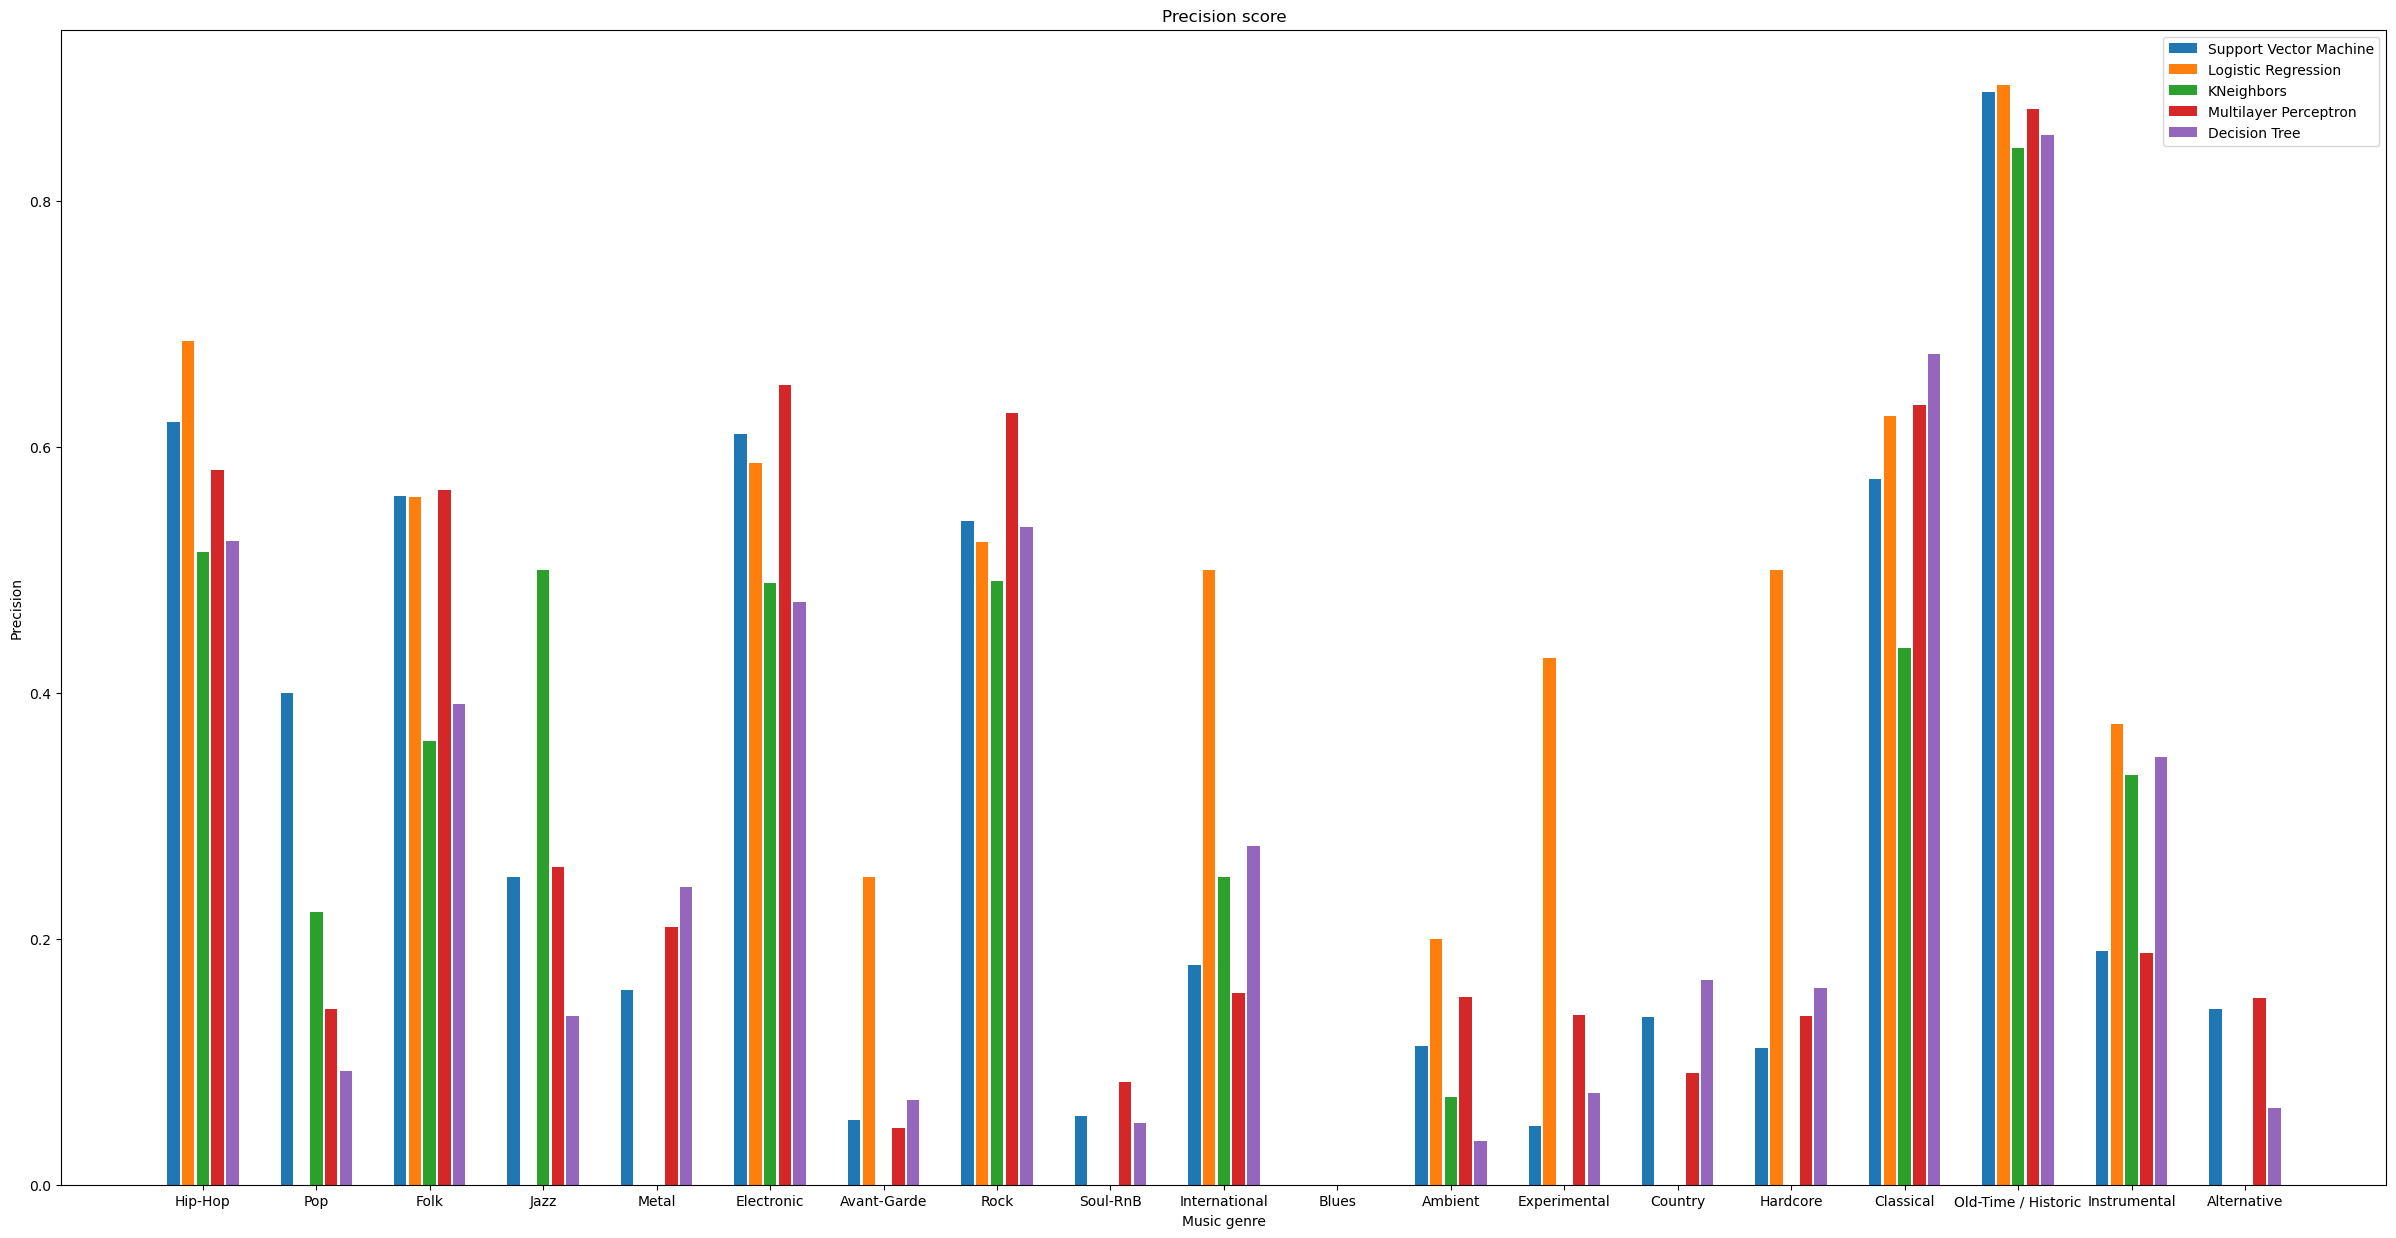

In [25]:
five_group_bar_plot(svm_precision_test, lr_precision_test, knn_precision_test_pca, 
                    mlp_precision_test_pca,dt_precision_test, le.inverse_transform(labels), 
                     "Precision score", "Music genre", 
                    "Precision", classifiers)

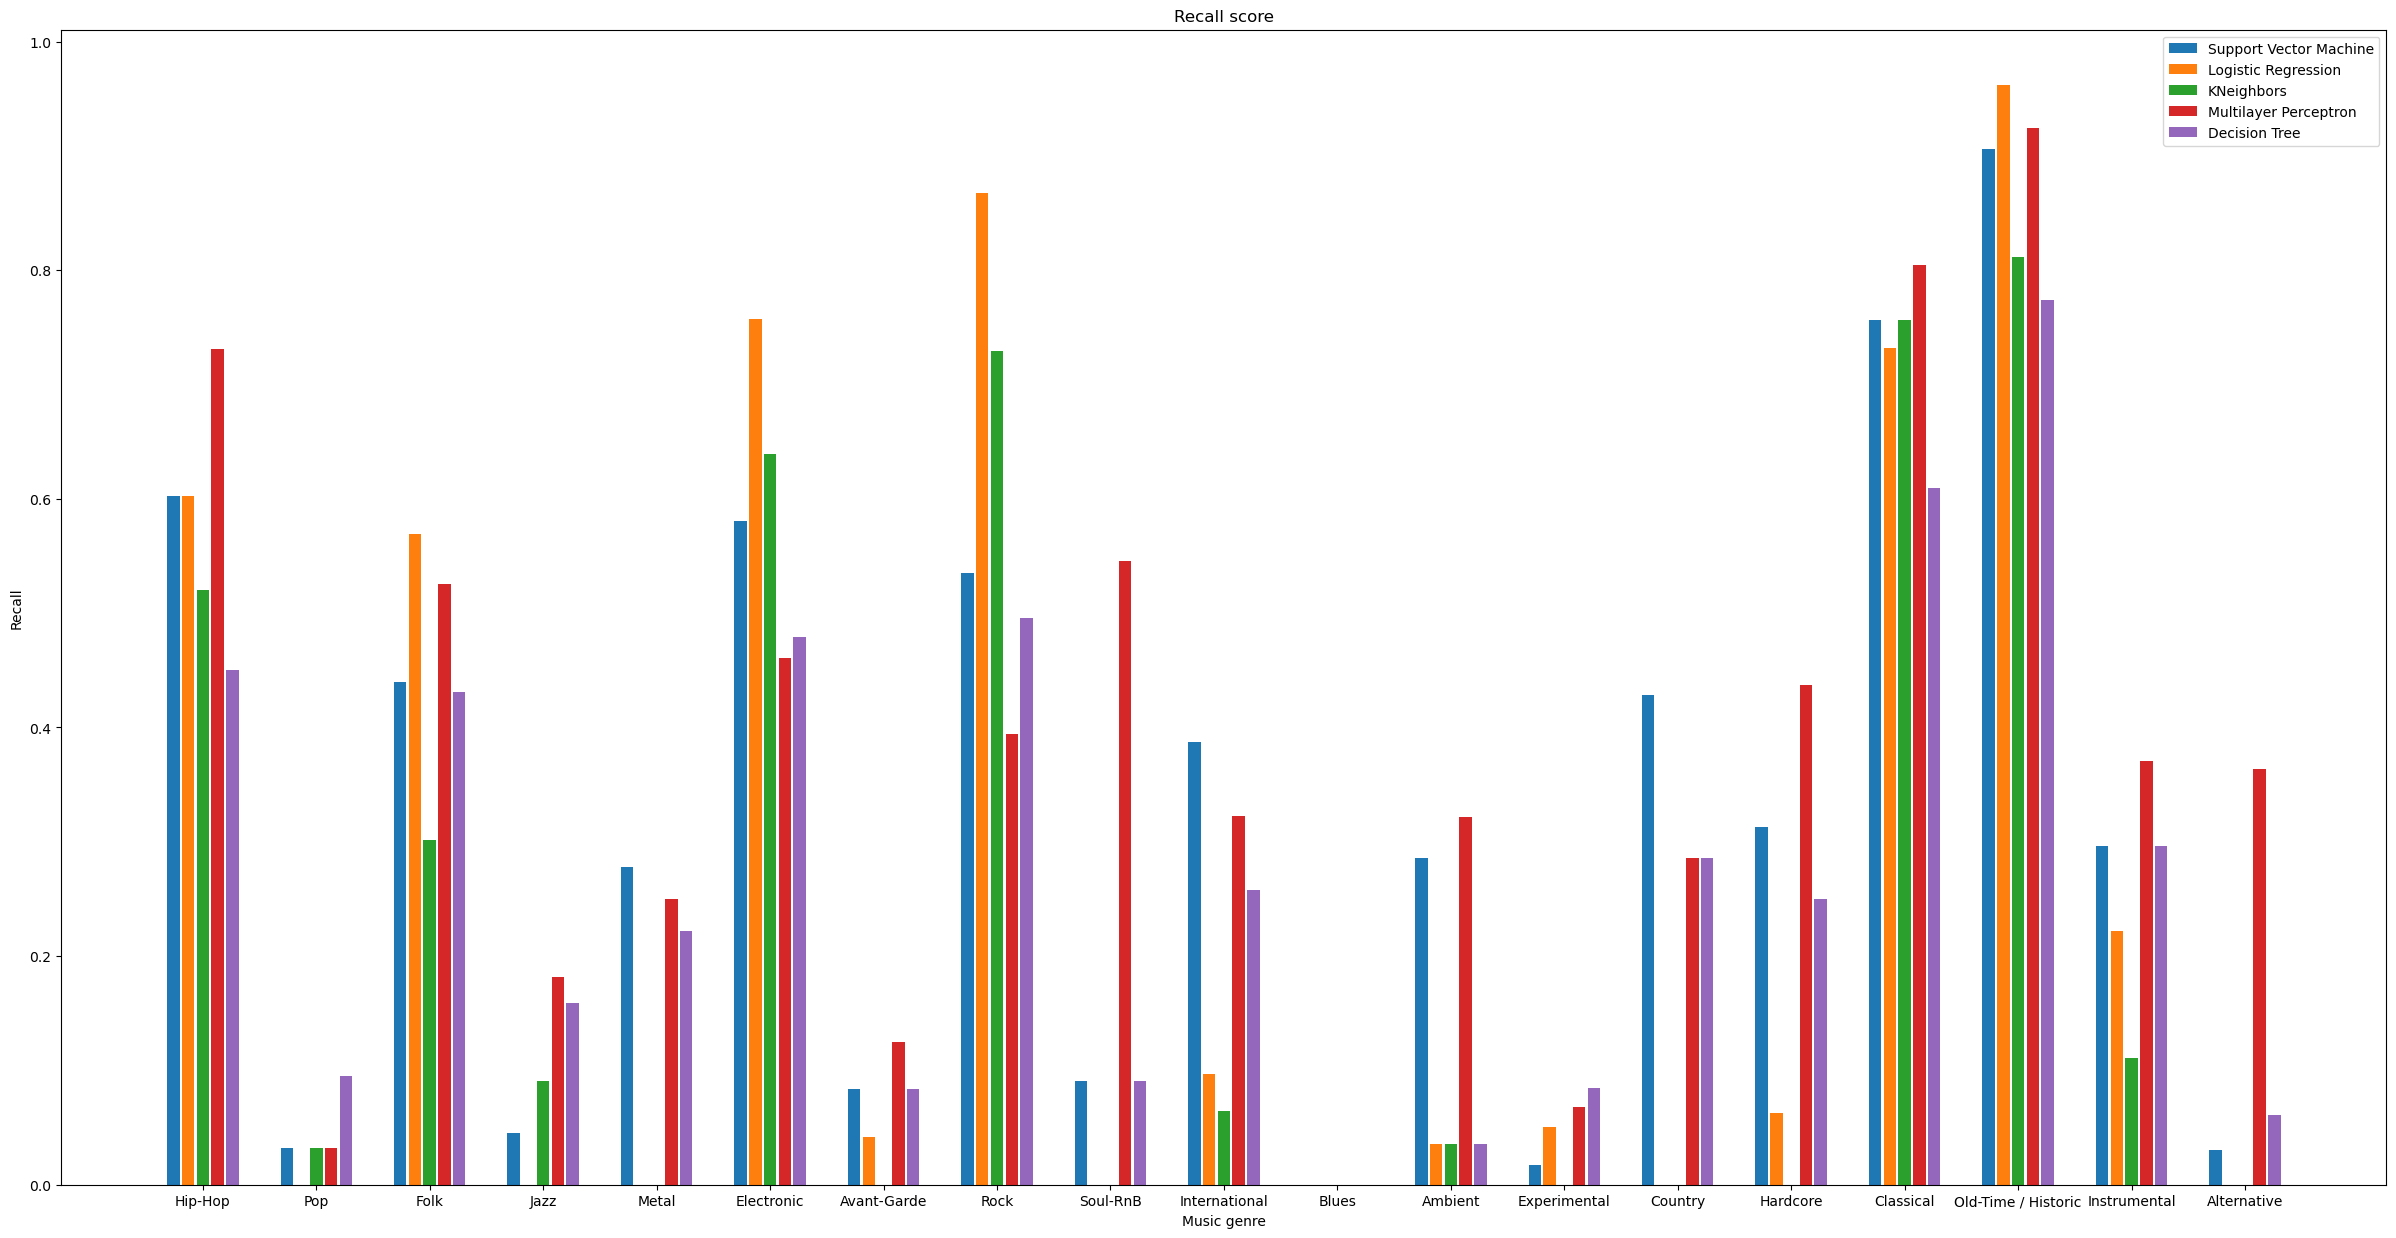

In [26]:
five_group_bar_plot(svm_recall_test, lr_recall_test, knn_recall_test_pca, mlp_recall_test_pca,
                    dt_recall_test, le.inverse_transform(labels), 
                     "Recall score", "Music genre", 
                    "Recall", classifiers)

In [27]:
five_group_bar_plot(svm_f1_test, lr_f1_test, knn_f1_test_pca, mlp_f1_test_pca,
                    dt_f1_test, le.inverse_transform(labels), 
                     "F1-score", "Music genre", 
                    "F1-score", classifiers)

## Conclusions
As shown by the results, __Logistic Regression__ has the best performance in general, but other classifiers can recognize genres that it's not able to guess. <br>
For example, __Support Vector Machine__, __Decision Tree__ and __Multilayer Perceptron__ can recognize at least one track for almost each target genre, while Logistic Regression predicts only 12 of the 19 genres in the dataset.<br>
The overall accuracy of each classifier is between 40% and 58%, so they can predict genres way better than a random classifier, whose value is $\approx \frac{1}{19}$.<br><br>

### Limitations
Generate the dataset requires a lot of processing time, so the .mp3 archive was the medium one with about 24000 tracks unbalanced.<br>
Performances are, in some way, affected by the unbalancing of both training set and test set. Electronic and Rock tracks, because of the larger amount of instances, contribute heavily to the overall metrics.<br>
Indeed, a classifier able to predict this classes correctly will show higher values of accuracy and for the average recall and precision. On the other side, the metrics related to minority classes are slightly better than a random classifier.

# Challenge
To conclude the study, this is a "challenge" among all classifiers considered in the previous sections.
<br>

In particular, a song is opened and loaded, the feature are extracted and all the informations retrived are passed to classifiers in order to make they possible to predict the genre to which that song belongs.<br>
The functions used to retrieve this informations are the same used to generate the original raw dataset.

In [28]:
# Instantiate all the classifiers and fit them
# We select the scenario for each classifier where its performance was best.
svm_clf_chall = skl.svm.SVC(C=overs['SVM']['C_best'], kernel='rbf', probability=True).fit(X_train_os, y_train_os)

lr_clf_chall = LogisticRegression(C=1, penalty=plain['LR']['penalty'], dual=False, 
                             solver=plain['LR']['solver']).fit(X_train, y_train)

knn_clf_chall = KNeighborsClassifier(n_neighbors=plain['kNN']['n_neighbours']).fit(X_train, 
                                                                      y_train)

mlp_clf_chall = MLPClassifier(solver='adam', alpha=smote['MLP']['alpha'], 
                        hidden_layer_sizes=(smote['MLP']['hidden_layer_sizes'],), 
                        random_state=1).fit(X_train_smote, y_train_smote)

dt_clf_chall = DecisionTreeClassifier(min_samples_leaf=overs['DT']['min_samples_leaf'], 
                               min_samples_split=overs['DT']['min_samples_split']).fit(X_train_os, y_train_os)

In [48]:
from utils import open_file_dialog
from dataset_generator import get_chroma_stft, get_chroma_cens, get_chroma_cqt, get_melspectrogram, get_mfcc, get_poly_features, get_rms, get_spectral_bandwidth, get_spectral_centroid, get_spectral_contrast, get_spectral_flatness, get_spectral_rolloff, get_tempogram, get_tonnetz, get_zero_crossing_rate

# Open dialogue box and choose the file audio to import
file_path = open_file_dialog()
   
metrics = []

# use librosa to get features about the file
y, sr = librosa.load(file_path, offset=0) #, duration=30)
metrics.extend(calculate_metrics(get_chroma_stft(y, sr)))
metrics.extend(calculate_metrics(get_chroma_cens(y, sr)))
chroma_cqt = get_chroma_cqt(y, sr)
metrics.extend(calculate_metrics(chroma_cqt))
mel = get_melspectrogram(y, sr)
metrics.extend(calculate_metrics(mel))
metrics.extend(calculate_metrics(get_mfcc(y, sr)))
metrics.extend(calculate_metrics(get_poly_features(y, sr)))
metrics.extend(calculate_metrics(get_rms(y)))
metrics.extend(calculate_metrics(get_spectral_bandwidth(y, sr)))
metrics.extend(calculate_metrics(get_spectral_centroid(y, sr)))
metrics.extend(calculate_metrics(get_spectral_contrast(y, sr)))
metrics.extend(calculate_metrics(get_spectral_flatness(y)))
metrics.extend(calculate_metrics(get_spectral_rolloff(y, sr)))
metrics.extend(calculate_metrics(get_tempogram(y, sr)))
tonnetz = get_tonnetz(y, sr)
metrics.extend(calculate_metrics(tonnetz))
metrics.extend(calculate_metrics(get_zero_crossing_rate(y)))

X_test_elem = [metrics]

The function waveshow visualizes a waveform in the time domain.<br>
In particolare we plot an amplitude-envelope view of the signal in two different forms:
1. a monophonic waveform with an envelope view
2. harmonic and percussive components with transparency.

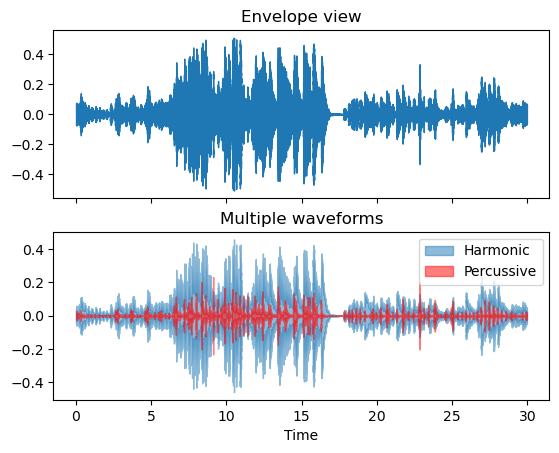

In [30]:
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view')
ax[0].label_outer()
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[1], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[1], label='Percussive')
ax[1].set(title='Multiple waveforms')
ax[1].legend()

On the other side, also raw samples-based views of the signal are plotted.
This is done zooming in on a 0.1 second plot.

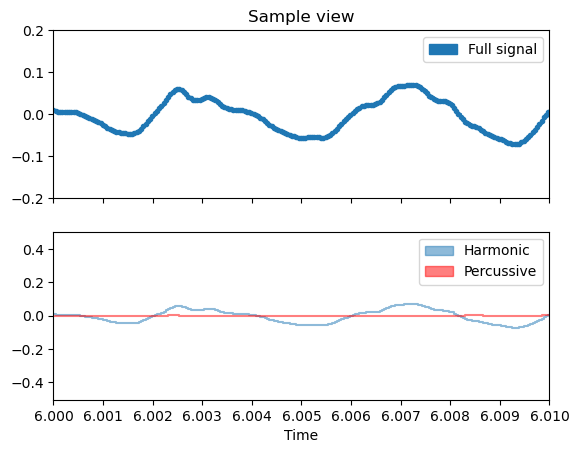

In [31]:
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
ax.set(xlim=[6.0, 6.01], title='Sample view', ylim=[-0.2, 0.2])
librosa.display.waveshow(y, sr=sr, ax=ax, marker='.', label='Full signal')
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax2, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax2, label='Percussive')
ax.label_outer()
ax.legend()
ax2.legend()

### Chromagram stft
The code below computes a chromagram from a waveform or power spectrogram and plots it.<br>
The term chromagram closely relates to the twelve different pitch classes.<br>
A pitch class (p.c. or pc) is a set of all pitches that are a whole number of octaves apart.<bR>
Chroma-based features are a powerful tool for analyzing music whose pitches can be meaningfully categorized and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

Text(0.5, 1.0, 'Stft demonstration')

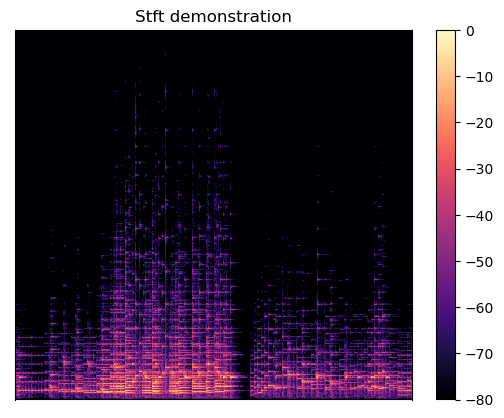

In [32]:
D = librosa.stft(y)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()
plt.title('Stft demonstration')

### Chromagram cqt
The code below computes a Constant-Q chromagram and plots it.<br>
It is similiar to previous case but the constant-Q transform uses a logarithmically spaced frequency axis.

In [33]:
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram demonstration')
fig.colorbar(img, ax=ax)

### Mel spectogram 
The code below computes a mel-scaled spectrogram and plots it.
A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale. Mel scale uses a unit of pitch such that equal distances in pitch sounded equally distant to the listener.

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

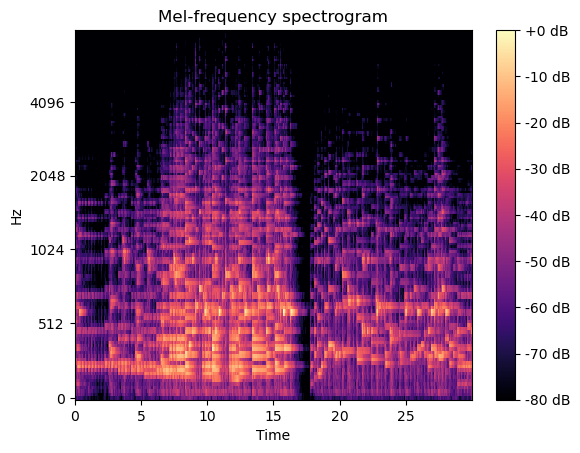

In [34]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

### Tonnetz
The code below computes the tonal centroid features (tonnetz) and plots it.<br>
This representation uses the method of 1 to project chroma features onto a 6-dimensional basis representing the perfect fifth, minor third, and major third each as two-dimensional coordinates.

[Text(0.5, 1.0, 'Tonal Centroids (Tonnetz)')]

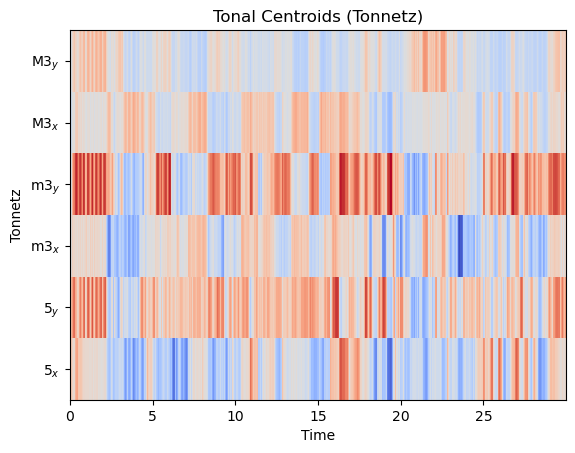

In [36]:
fig, ax = plt.subplots()
img = librosa.display.specshow(tonnetz,
                                y_axis='tonnetz', x_axis='time', ax=ax)
ax.set(title='Tonal Centroids (Tonnetz)')

In [49]:
import warnings
warnings.filterwarnings("ignore")

# Convert predicitions to a dictionary of the form `label_name`:value
#
# @param string_labels: list of labels
# @param probs:         list of predicted probabilites
#
# @returns: dictonary
def preds_to_dict(string_labels, probs):
    probs_dict = {}
    for index in range(0, len(string_labels)):
        probs_dict[string_labels[index]] = probs[index]
    return probs_dict

# Get the probability scores for each classifier.
# We are supposing that the X train and y train are just the one element that we are trying
# to classify.
orig_labels = le.inverse_transform(labels) # convert labels back
orig_labels.sort()

svm_probs = svm_clf_chall.predict_proba(X_test_elem)
lr_probs = lr_clf_chall.predict_proba(X_test_elem)
knn_probs = knn_clf_chall.predict_proba(X_test_elem)
mlp_probs = mlp_clf_chall.predict_proba(X_test_elem)
dt_probs = dt_clf_chall.predict_proba(X_test_elem)

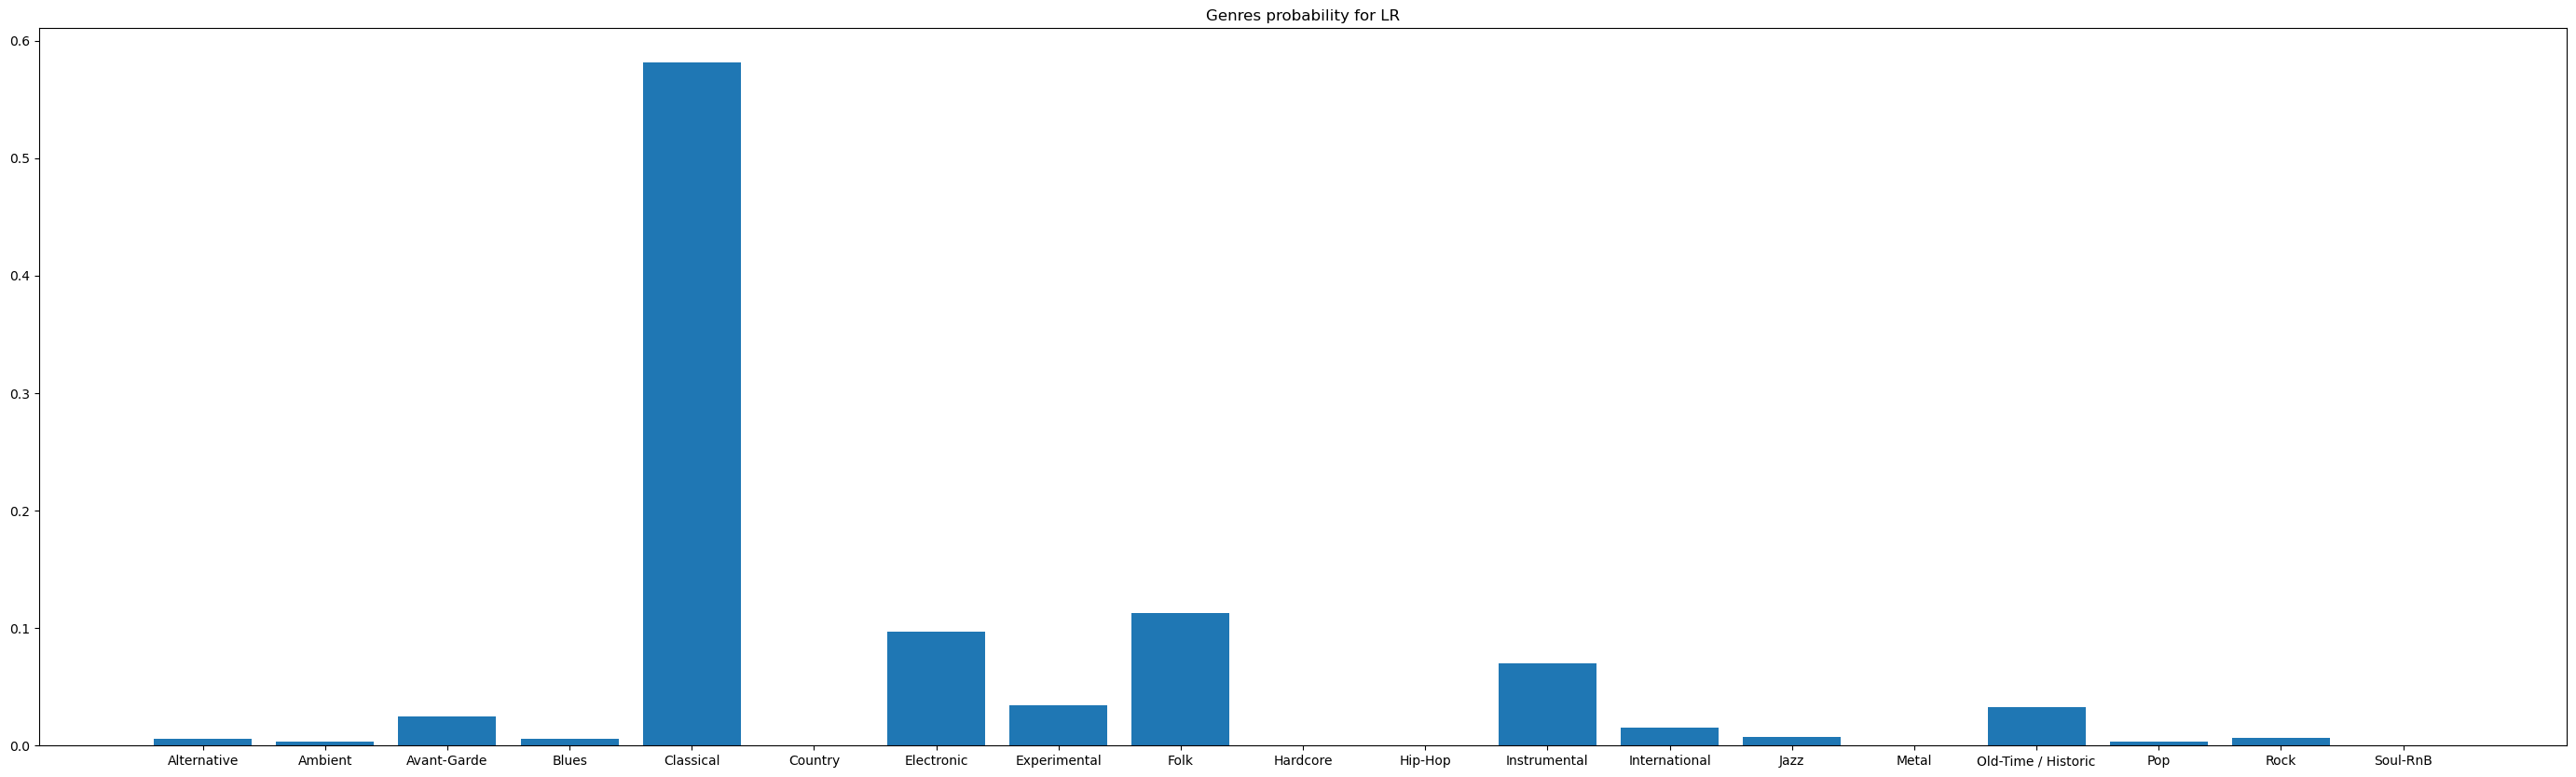

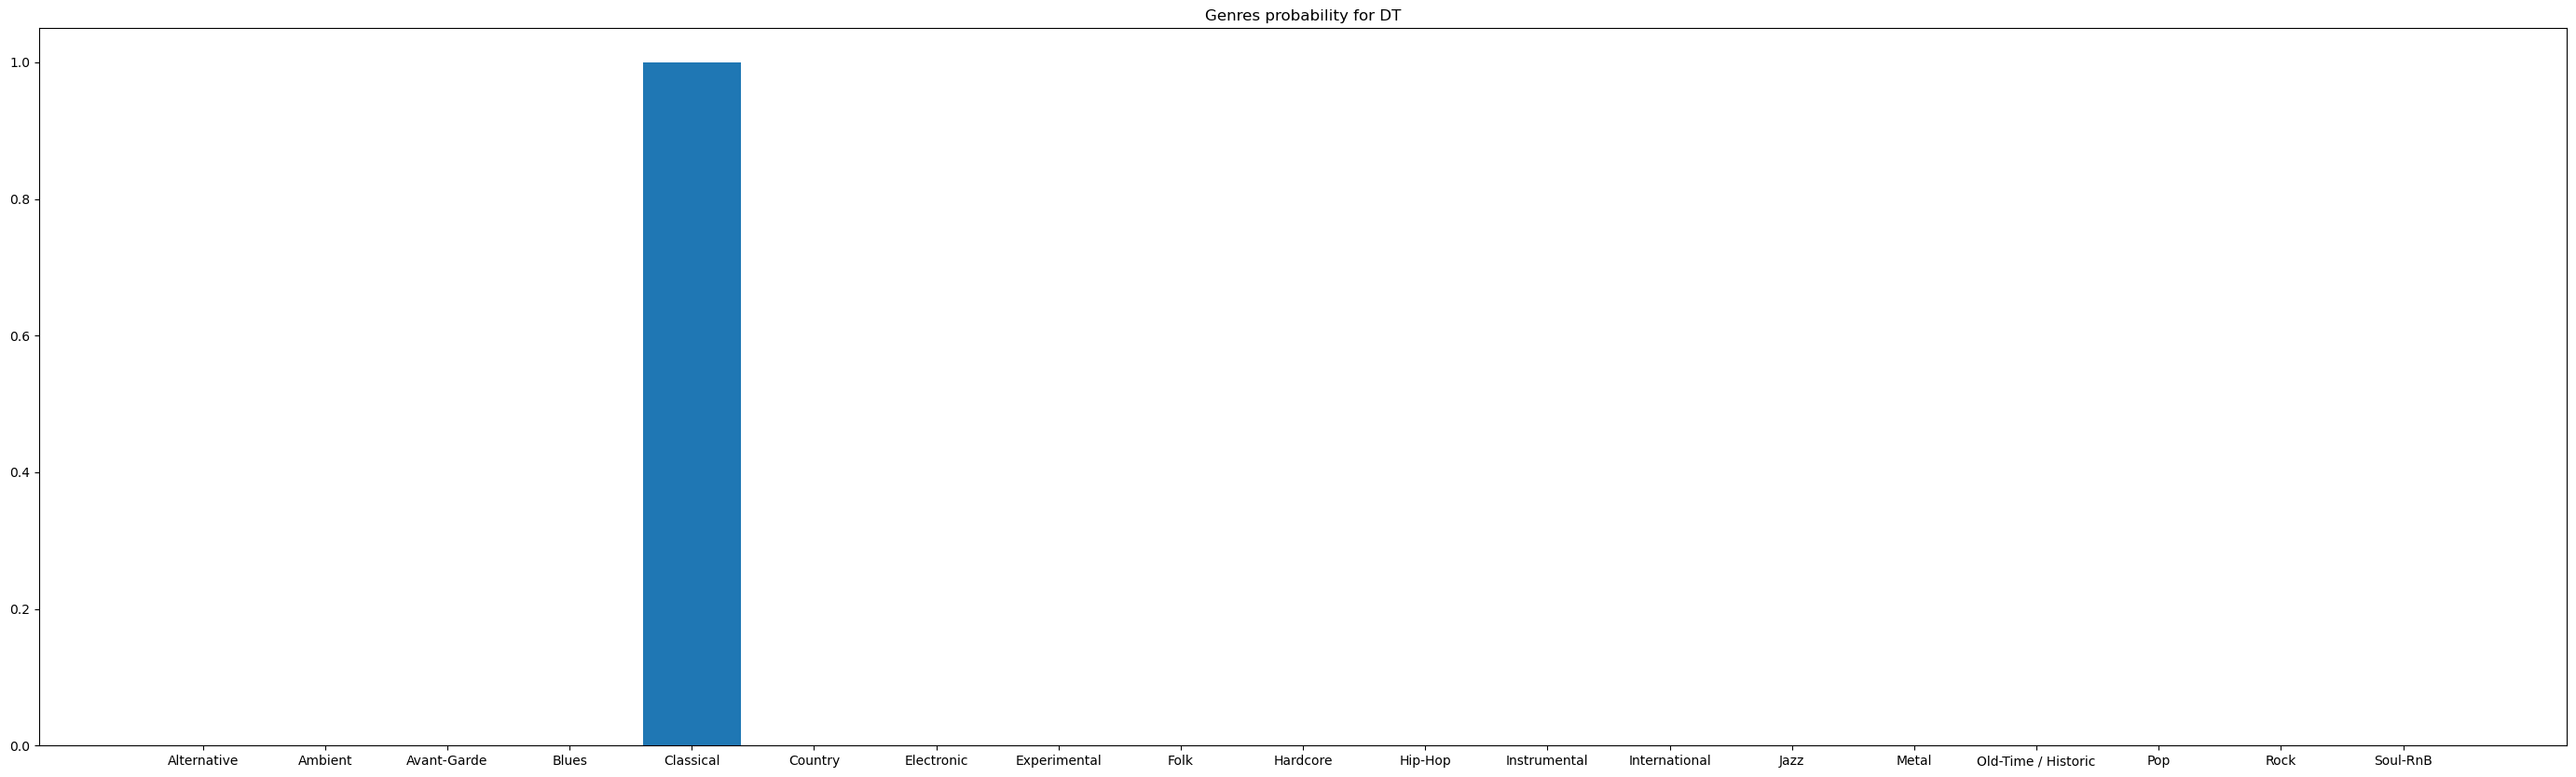

In [50]:
bar_plot((35,10), svm_probs[0], orig_labels, 'Genres probability for SVM')
bar_plot((35,10), lr_probs[0], orig_labels, 'Genres probability for LR')
bar_plot((35,10), knn_probs[0], orig_labels, 'Genres probability for KNN')
bar_plot((35,10), mlp_probs[0], orig_labels, 'Genres probability for MLP')
bar_plot((35,10), dt_probs[0], orig_labels, 'Genres probability for DT')

## Bibliography
1. [FMA paper](https://arxiv.org/abs/1612.01840)
2. [librosa](https://librosa.org)
3. [TinyTag](https://pypi.org/project/tinytag)